In [592]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [593]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
import re
import os

In [594]:
import Forecasting
import Clustering

Исходные данные

In [595]:
data = pd.read_csv("pulp_and_paper.csv", sep=";")#, parse_dates=['time']) #, nrows=10)

In [596]:
columns = list(data.columns[2:]) #time, y
deleted = ['x33']
columns.pop(columns.index(deleted[0]))
len(columns)

60

In [597]:
K=1
labels = data.y[::K].to_numpy()

Анализ результатов

In [477]:
W=20
K=1
DIR = f'./pulp/W{W}_group{K}'
format_string = re.compile("([0-9]+)_([a-zA-Z]+)_N([0-9]+)_w([0-9]+).csv")
dir_format_string = re.compile("./pulp/W([0-9]+)_group([0-9]+)")
final_string = re.compile("./pulp/W([0-9]+)_group([0-9]+)/([0-9]+)_([a-zA-Z]+)_N([0-9]+)_w([0-9]+).csv")

In [498]:
eps = 1e-15
def calc_mae(data, N_clusters=1, mask=None, mode=None): #dataframe
    if mode is not None:
        data = data[data['mode'] == mode]
    data = data.to_numpy()
    Q = data.shape[1] // 2 - 1
    if mask is not None:
        data = np.column_stack((data[:, mask], data[:, Q+mask], data[:, 2*Q:]))
        print(f"new shape {data.shape}")
        Q = data.shape[1] // 2 - 1
    maes = np.zeros((N_clusters, Q))
    maes.fill(np.inf)
    for cl in range(N_clusters):
        mask = data[:, -2] == cl
        if not mask.any():
            continue
        d = data[mask]
        maes[cl] = np.abs(d[:, :Q] - d[:, Q:2*Q]).sum(axis=0) / d.shape[0]
    return maes

def calc_mase(data, N_clusters, mask=None, mode=None):
    if mode is not None:
        data = data[data['mode'] == mode]
    Q = data.shape[1] // 2 - 1
    d = data.to_numpy()
    if mask is not None:
        d = np.column_stack((d[:, mask], d[:, Q+mask], d[:, 2*Q:]))
        print(f"new shape {d.shape}")
        Q = d.shape[1] // 2 - 1
    mases = np.zeros((N_clusters, Q))
    mases.fill(np.inf)
    for cl in range(N_clusters):
        mask = data['cluster_num'] == cl
        if not mask.any() or mask.shape[0] == 1:
            continue
        continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
        if continuity.sum() == 0:
            mases[cl] = np.inf
        else:
            mases[cl] = np.abs(d[:-1, :Q][continuity] - d[:-1, Q:2*Q][continuity]).sum(axis=0) / np.sum(continuity)
#         print(np.mean(mases[cl]), np.mean(np.abs(d[1:, :Q][continuity] - d[:-1, :Q][continuity]).sum(axis=0) / np.sum(continuity)))
            mases[cl] /= np.maximum(eps, np.abs(d[1:, :Q][continuity] - d[:-1, :Q][continuity]).sum(axis=0) / np.sum(continuity))
#             print("naive", np.mean(np.maximum(eps, np.abs(d[1:, :Q][continuity] - d[:-1, :Q][continuity]).sum(axis=0) / np.sum(continuity))))
    return mases

def calc_mae_naive(data, mask=None, mode=None):
    if mode is not None:
        data = data[data['mode'].astype(int) == mode]
    Q = data.shape[1] // 2 - 1
    d = data.to_numpy()
    if mask is not None:
        d = np.column_stack((d[:, mask], d[:, Q+mask], d[:, 2*Q:]))
        print(f"new shape {d.shape}")
        Q = d.shape[1] // 2 - 1
    mae = np.mean(np.abs(d[1:, :Q] - d[:-1, :Q]))
    return mae

In [471]:
#tests
p = pd.DataFrame([[0, 1, 0, 1, 0, 0], [2, 1, 0, 1, 1, 0]], columns=["0", "1", "3", "4", 'cluster_num', 'mode'])
a = pd.DataFrame([
    [0, 10, 0, 9, 0, 1],
    [1, 10, 1, 10, 0, 1],
    [0, 10, 2, 9, 1, 0],
    [1, 12, 1, 12, 1, 0]
], columns = [str(x) for x in range(4)] + ['cluster_num'] + ['mode'])
print(calc_mae(p, N_clusters=2, mask=None, mode=0))
#[0, 0], [2, 0]
print(calc_mae(a, N_clusters=2, mask=None, mode=0))
#[[inf, inf], [1, 0.5]]

[[0. 0.]
 [2. 0.]]
[[inf inf]
 [1.  0.5]]


In [472]:
print(calc_mase(a, N_clusters=2, mask=None, mode=None))
#[0, inf] [2, 0.5]
print(calc_mase(a, N_clusters=2, mask=np.array([1, 0]), mode=0))
#[inf, inf] [0.5, 2]

[[0.e+00 1.e+15]
 [2.e+00 5.e-01]]
new shape (2, 6)
[[inf inf]
 [0.5 2. ]]


/tmp/ipykernel_2609316/2270737732.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


In [568]:
cur_maes, cur_mases, cur_mases_, cluster_sizes, files = [], [], [], [], []
# DIR = f'./pulp/W20_group1'
DIRS = ["./pulp/W20_group1", "./pulp/W10_group1", "./pulp/W20_group2", "./pulp/W30_group1"]
for DIR in DIRS:
    for i, file in enumerate(os.listdir(DIR)):
        print(i, file)
        match_res = format_string.match(file) 
        match_dir = dir_format_string.match(DIR)
        if match_res is None or match_dir is None:
            print("No match")
            continue
        ind, alg, n, w = [match_res[i] for i in [1, 2, 3, 4]]
        group_k, W_for = [match_dir[i] for i in [1, 2]]
    #     if (int(ind) < 20):
    #         continue
        n, w = [int(x) for x in [n, w]]
        data = pd.read_csv(os.path.join(DIR, file))
        files.append(os.path.join(DIR, file))

        _, cluster_sz = np.unique(data.to_numpy()[:, -2], return_counts=True)
        cluster_sizes.append(cluster_sz)
        cur_maes.append(calc_mae(data, N_clusters=n, mode=2)) #(cl, Q)
        cur_mases.append(calc_mase(data, N_clusters=n, mode=2))
        cur_mases_.append(cur_maes[-1] / calc_mae_naive(data, mode=0))

0 31_Kmeans_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


1 03_Kmeans_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


2 00_MeanShift_N43_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


3 01_MeanShift_N40_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


4 04_Kmeans_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


5 01_Kmeans_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


6 28_Kmeans_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


7 05_Kmeans_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


8 27_Kmeans_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


9 06_Agglomer_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


10 24_Agglomer_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


11 21_Agglomer_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


12 00_MeanShift_N6_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


13 10_Agglomer_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


14 30_Kmeans_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


15 30_Agglomer_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


16 05_Agglomer_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


17 21_Kmeans_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


18 20_MeanShift_N39_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


19 29_Kmeans_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


20 28_Agglomer_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


21 04_Agglomer_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


22 22_Agglomer_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


23 23_Agglomer_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


24 26_Agglomer_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


25 02_Kmeans_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


26 31_Agglomer_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


27 27_Agglomer_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


28 07_Agglomer_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


29 26_Kmeans_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


30 03_Kmeans_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


31 00_Kmeans_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


32 24_Kmeans_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


33 11_Agglomer_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


34 02_Kmeans_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


35 02_Agglomer_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


36 29_Agglomer_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


37 00_Kmeans_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


38 00_Kmeans_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


39 25_Kmeans_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


40 20_Agglomer_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


41 22_MeanShift_N265_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


42 01_Kmeans_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


43 25_Agglomer_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


44 08_Agglomer_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


45 22_Kmeans_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


46 01_Kmeans_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


47 07_Agglomer_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


48 09_Agglomer_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


49 03_Agglomer_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


50 20_Kmeans_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


51 06_Agglomer_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


52 23_Kmeans_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


53 21_MeanShift_N142_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


0 31_Kmeans_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


1 32_Agglomer_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


2 28_Kmeans_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


3 27_Kmeans_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


4 24_Agglomer_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


5 30_Kmeans_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


6 21_Kmeans_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


7 30_Agglomer_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


8 20_MeanShift_N39_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


9 29_Kmeans_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


10 26_Agglomer_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


11 28_Agglomer_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


12 27_Agglomer_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


13 26_Kmeans_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


14 25_Agglomer_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


15 31_Agglomer_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


16 24_Kmeans_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


17 23_Agglomer_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


18 33_Agglomer_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


19 25_Kmeans_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


20 22_MeanShift_N265_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


21 29_Agglomer_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


22 22_Kmeans_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


23 20_Kmeans_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


24 23_Kmeans_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


25 34_Agglomer_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


26 21_MeanShift_N142_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


0 26_Agglomer_N11_w10.csv
1 03_Kmeans_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


2 13_MeanShift_N16_w5.csv
3 16_Agglomer_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


4 23_Agglomer_N2_w10.csv
5 17_Agglomer_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


6 08_Kmeans_N2_w10.csv
7 09_Kmeans_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


8 04_Kmeans_N2_w5.csv
9 24_Agglomer_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


10 06_Kmeans_N9_w5.csv
11 07_Kmeans_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


12 14_MeanShift_N21_w10.csv
13 10_Kmeans_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


14 05_Kmeans_N5_w5.csv
15 19_Agglomer_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


16 18_Agglomer_N11_w1.csv
17 15_Agglomer_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


18 12_MeanShift_N7_w1.csv
19 25_Agglomer_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


20 02_Kmeans_N9_w1.csv
21 00_Kmeans_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


22 22_Agglomer_N11_w5.csv
23 01_Kmeans_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


24 11_Kmeans_N11_w10.csv
25 21_Agglomer_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])
/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


26 20_Agglomer_N5_w5.csv
0 31_Kmeans_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


1 32_Agglomer_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


2 28_Kmeans_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


3 27_Kmeans_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


4 24_Agglomer_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


5 30_Kmeans_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


6 21_Kmeans_N5_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


7 30_Agglomer_N11_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


8 20_MeanShift_N39_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


9 29_Kmeans_N5_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


10 26_Agglomer_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


11 28_Agglomer_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


12 27_Agglomer_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


13 26_Kmeans_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


14 25_Agglomer_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


15 31_Agglomer_N2_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


16 24_Kmeans_N2_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


17 23_Agglomer_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


18 33_Agglomer_N9_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


19 25_Kmeans_N5_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


20 22_MeanShift_N265_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


21 29_Agglomer_N9_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


22 22_Kmeans_N9_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


23 20_Kmeans_N2_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


24 23_Kmeans_N11_w1.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


25 34_Agglomer_N11_w10.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


26 21_MeanShift_N142_w5.csv


/tmp/ipykernel_2609316/2768270320.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


In [601]:
files

['./pulp/W20_group1/31_Kmeans_N11_w10.csv',
 './pulp/W20_group1/03_Kmeans_N2_w5.csv',
 './pulp/W20_group1/00_MeanShift_N43_w10.csv',
 './pulp/W20_group1/01_MeanShift_N40_w5.csv',
 './pulp/W20_group1/04_Kmeans_N5_w5.csv',
 './pulp/W20_group1/01_Kmeans_N5_w10.csv',
 './pulp/W20_group1/28_Kmeans_N2_w10.csv',
 './pulp/W20_group1/05_Kmeans_N9_w5.csv',
 './pulp/W20_group1/27_Kmeans_N11_w5.csv',
 './pulp/W20_group1/06_Agglomer_N2_w1.csv',
 './pulp/W20_group1/24_Agglomer_N2_w5.csv',
 './pulp/W20_group1/21_Agglomer_N5_w1.csv',
 './pulp/W20_group1/00_MeanShift_N6_w1.csv',
 './pulp/W20_group1/10_Agglomer_N5_w5.csv',
 './pulp/W20_group1/30_Kmeans_N9_w10.csv',
 './pulp/W20_group1/30_Agglomer_N9_w10.csv',
 './pulp/W20_group1/05_Agglomer_N5_w10.csv',
 './pulp/W20_group1/21_Kmeans_N5_w1.csv',
 './pulp/W20_group1/20_MeanShift_N39_w1.csv',
 './pulp/W20_group1/29_Kmeans_N5_w10.csv',
 './pulp/W20_group1/28_Agglomer_N2_w10.csv',
 './pulp/W20_group1/04_Agglomer_N2_w10.csv',
 './pulp/W20_group1/22_Agglomer_N

In [558]:
tmp = [[np.min(cur_mases[i] - cur_mases_[i]), np.max(cur_mases[i] - cur_mases_[i])] for i in range(len(files))]
tmp = np.array(tmp).reshape(-1)

/tmp/ipykernel_2609316/2881364715.py:1: RuntimeWarning: invalid value encountered in subtract
  tmp = [[np.min(cur_mases[i] - cur_mases_[i]), np.max(cur_mases[i] - cur_mases_[i])] for i in range(len(files))]


(array([  2.,   0.,   0.,   0.,   0.,   3.,   0.,   1.,   3., 109.]),
 array([-2263.17285478, -2038.58039887, -1813.98794297, -1589.39548706,
        -1364.80303116, -1140.21057526,  -915.61811935,  -691.02566345,
         -466.43320755,  -241.84075164,   -17.24829574]),
 <BarContainer object of 10 artists>)

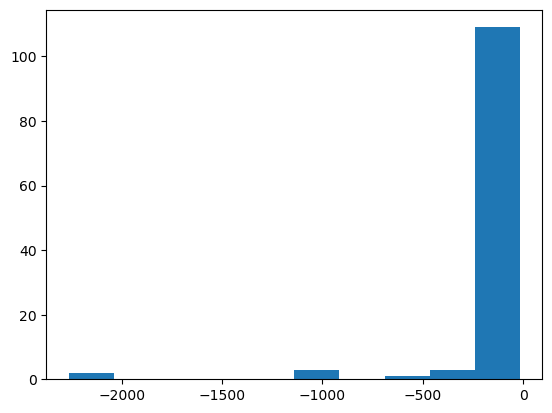

In [559]:
plt.hist(tmp[tmp <= 0])

In [560]:
#(ind_alg, cl, var)

In [612]:
mae_on_max_cluster = np.array([cur_maes[i][np.argmax(cluster_sizes[i])].mean() for i in range(len(cur_maes))]) 
mase_on_max_cluster = np.array([cur_mases[i][np.argmax(cluster_sizes[i])].mean() for i in range(len(cur_maes))]) 

In [613]:
# print(*zip(mase_on_max_cluster, files), sep="\n")

In [614]:
mase_on_max_cluster[36]

32512212368.657185

In [615]:
results_for_algs = {}
for ind in range(len(files)):
    match_res = final_string.match(files[ind]) 
    group_k, W_forecast, _, alg, n, w = [match_res[i] for i in [1, 2, 3, 4, 5, 6]]
    if alg not in results_for_algs:
        results_for_algs[alg] = [(mase_on_max_cluster[ind], mae_on_max_cluster[ind], ind)]
    else:
        results_for_algs[alg].append((mase_on_max_cluster[ind], mae_on_max_cluster[ind], ind))


In [616]:
for alg, res in results_for_algs.items():
    results_for_algs[alg] = sorted(res)

In [617]:
results_for_algs['MeanShift'][:3]

[(11583533.443057097, 1.373929757494894, 3),
 (34784367.27471415, 1.376284841205259, 2),
 (35747838.901967354, 1.3759985685667881, 12)]

In [618]:
results_for_algs['Kmeans'][:3]

[(0.837831862921678, 1.4973070981389944, 70),
 (0.8401873582959496, 1.4961349523373875, 124),
 (0.8421982875611211, 1.4954071707365557, 32)]

In [619]:
results_for_algs['Agglomer'][:5]

[(0.7568785452980009, 1.4297468151168506, 69),
 (0.7638601376068147, 1.4279931846679317, 20),
 (0.7798484288745203, 1.4228073087051427, 123),
 (7938094.720991376, 1.422673170139177, 9),
 (15729713.04640222, 1.4267878034178527, 48)]

In [591]:
files[69]

'./pulp/W10_group1/31_Agglomer_N2_w10.csv'

In [328]:
# mase_on_max_cluster[mase_on_max_cluster > 10] = 0

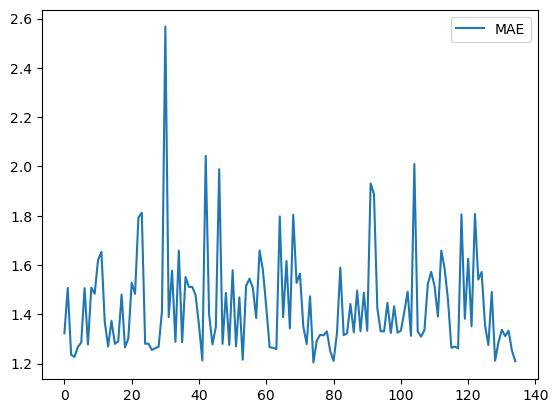

In [526]:
plt.plot(mae_on_max_cluster, label="MAE")
# plt.plot(mase_on_max_cluster, label="MASE")
plt.legend()

In [527]:
ind_mae = np.argmin(mae_on_max_cluster)
best_mae_file = files[ind_mae]
ind_mae, best_mae_file

(74, './pulp/W10_group1/22_MeanShift_N265_w10.csv')

In [528]:
ind_mase = np.argmin(mase_on_max_cluster)
best_mase_file = files[ind_mase]
ind_mase, best_mase_file

(74, './pulp/W10_group1/22_MeanShift_N265_w10.csv')

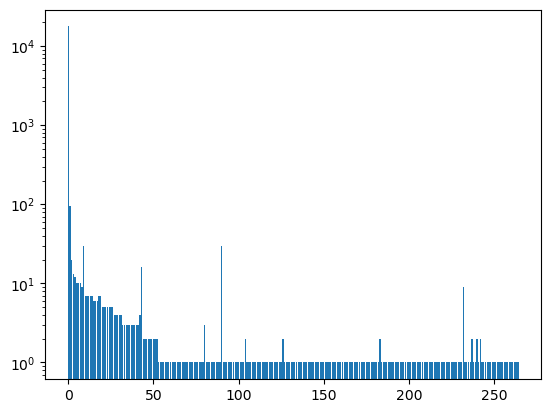

In [530]:
plt.bar(np.arange(cluster_sizes[ind_mae].shape[0]), cluster_sizes[ind_mae])
plt.yscale('log')

In [531]:
cluster_sizes[ind_mae].min()

1

<BarContainer object of 265 artists>

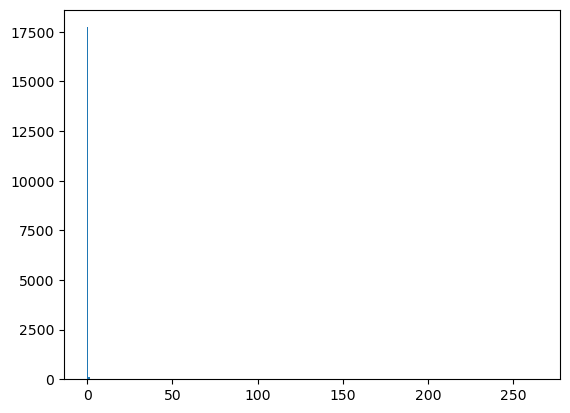

In [532]:
plt.bar(np.arange(cluster_sizes[ind_mase].shape[0]), cluster_sizes[ind_mase])

In [533]:
maes_order = np.argsort(mae_on_max_cluster)
mases_order = np.argsort(mase_on_max_cluster)

In [534]:
maes_order, mases_order

(array([ 74, 134,  80, 128,  41,  53,   3,   2,  79, 133,  26,  63, 117,
         27, 115,  62,  18,  61,   4,  28, 116,  13,  51, 126,  49,   7,
         44,  72,  15,  47,  24,  25,   5,  35, 129,  33,  16,  75,  19,
        106, 131, 103,  77,  83,  76,  84,   0,  81,  97,  99,  86, 105,
         78,  95,  88,  94,  90, 100, 132, 107, 130,  67,  45,  71, 121,
         40, 125,  12,  14, 119,  57,  65,  31, 111,  43, 101,  29,  93,
         60,  98,  85,  96, 114,  52,  73,  39,  17,  21,   9,  48,  89,
        127, 102,  87,   6,   1,  56,   8,  37,  38, 110,  54, 108,  69,
         20, 123,  55,  36,  70, 124, 109,  32,  59,  50, 113,  82,  66,
         10, 120,  11, 112,  34,  58,  22,  64,  68, 118, 122,  23,  92,
         91,  46, 104,  42,  30]),
 array([ 74, 134, 128,  80,  41,  53,   3,   2,  79, 133,  26,  63, 117,
         27, 115,  62,  18,  61,   4,  28, 116,  13,  51, 126,  49,   7,
         44,  72,  15,  47,  24,  25,   5, 129,  35,  33,  16,  75,  19,
        106, 131

ind

Проверка с исходной разметкой

In [278]:
labels.shape

(18398,)

In [541]:
def calc_misses(cur_file, labels, verbose=False):
    print(cur_file)
    data = pd.read_csv(cur_file)
    match_res = final_string.match(best_mae_file) 
    groupk, W_forecast, ind, alg, n, w = [match_res[i] for i in [1, 2, 3, 4, 5, 6]]
    n, w = [int(x) for x in [n, w]]
    data = data.to_numpy()
    dataset_y = labels[-data.shape[0]:]
    
    predicted_labels = np.zeros(data.shape[0])
    misses = [0] * n
    threshold = 0.01
#     TP, FP, TN, FN = 0, 0, 0, 0 #positive - anomaly
    for cl in range(n):
        mask = data[:, -2] == cl
        if not mask.any():
            continue
        lab, lab_cnt = np.unique(dataset_y[mask], return_counts=True)
        cnt = np.array([0, 0])
        cnt[lab] = lab_cnt
        cluster_label = (1 if cnt[1]/(cnt[0] + cnt[1]) > threshold else 0)
        predicted_labels[mask] = cluster_label
        misses[cl] = cnt[1 - cluster_label]
        print(f"{cnt[1]:4}, {mask.sum():5}, {cnt[1] / mask.sum() * 100:.4}")
        if verbose:
            plt.bar(np.where(mask)[0], 1, label="cluster")
#             print(f"{np.argwhere(np.logical_and(mask, dataset_y.astype(np.bool_)) == True)=}")
            plt.bar(np.where(np.logical_and(mask, dataset_y.astype(np.bool_)))[0], 2, label="labels")
            plt.show
            plt.legend()
            plt.title(f"cluster:{cl}")
            plt.show()
#         return np.logical_and(mask, dataset_y.astype(np.bool_))

In [542]:
# for cur_file in np.array(files)[maes_order][:5]:
#     calc_misses(cur_file, labels)
#     print("_____________")

./pulp/W10_group1/22_MeanShift_N265_w10.csv
 101, 17731, 0.5696


/home/lazuhin/anaconda3/envs/the/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


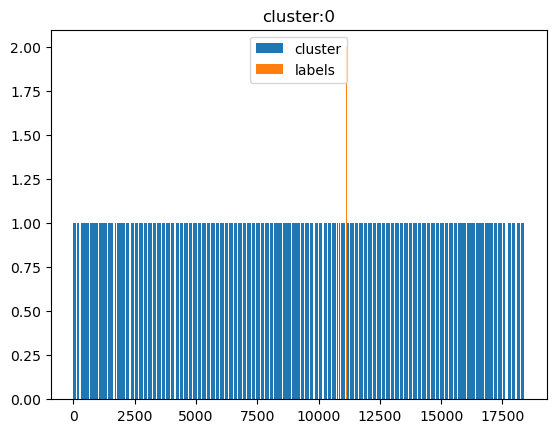

   0,    95, 0.0


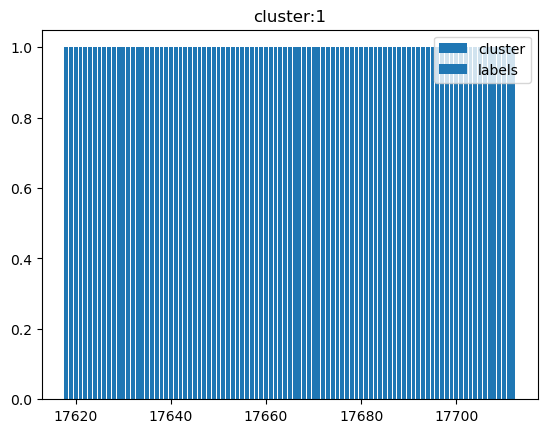

   0,    20, 0.0


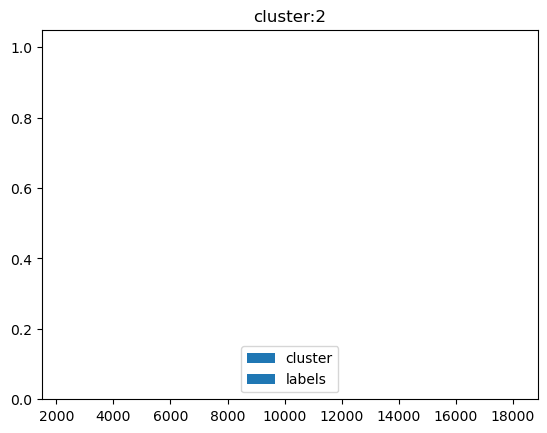

   0,    13, 0.0


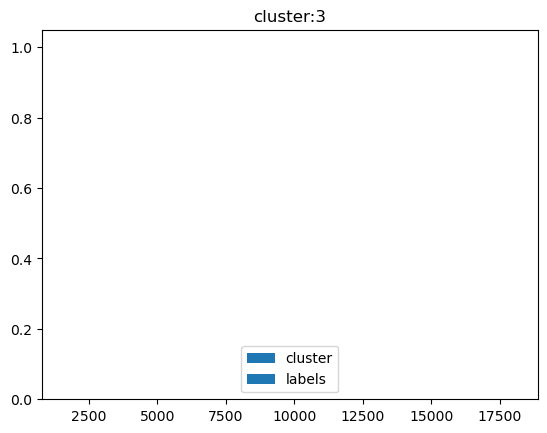

   0,    12, 0.0


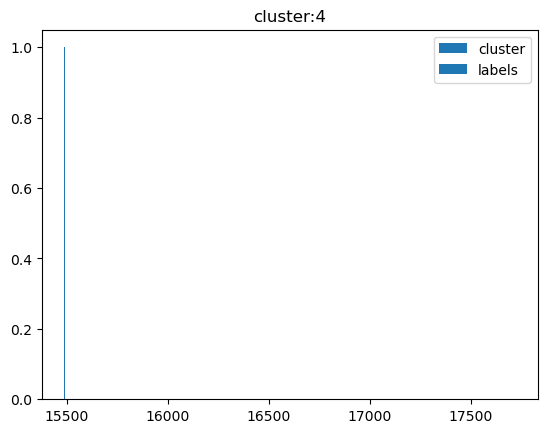

   0,    10, 0.0


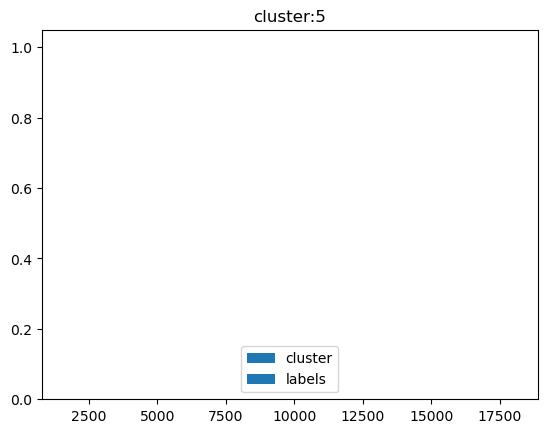

   0,    10, 0.0


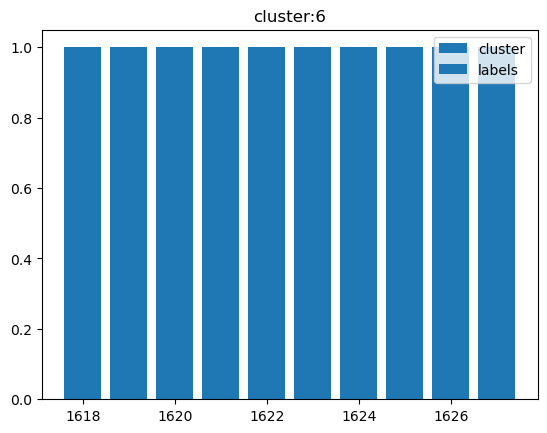

   0,    10, 0.0


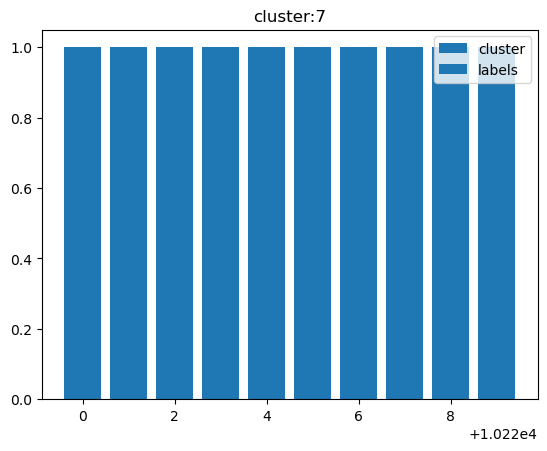

   0,     9, 0.0


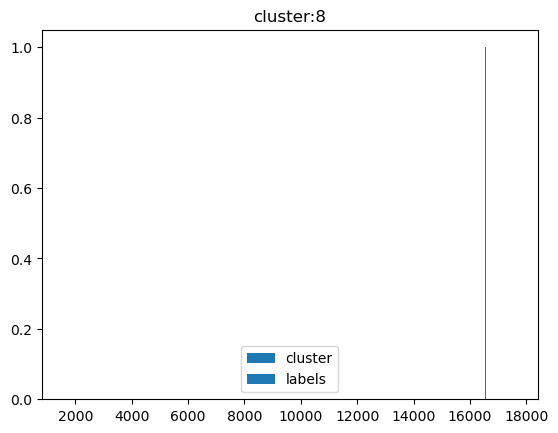

   1,    30, 3.333


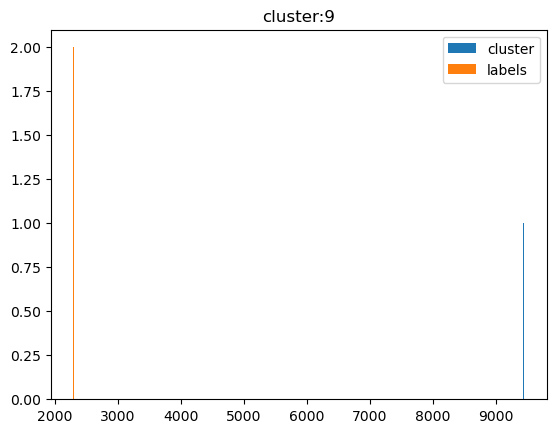

   0,     7, 0.0


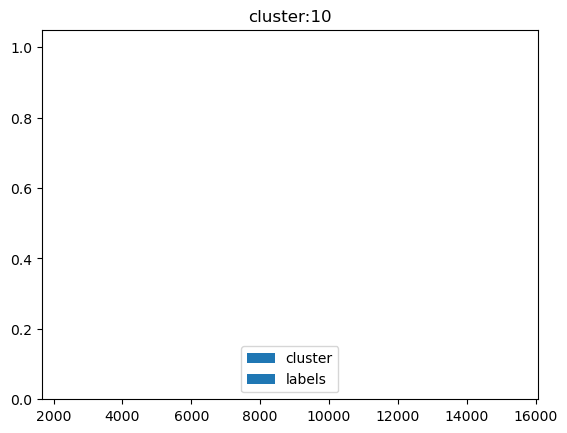

   0,     7, 0.0


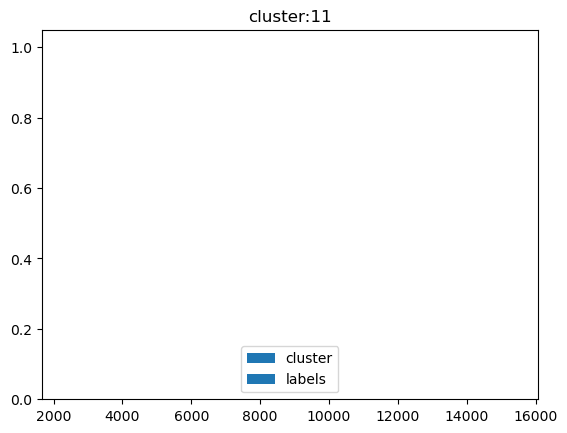

   0,     7, 0.0


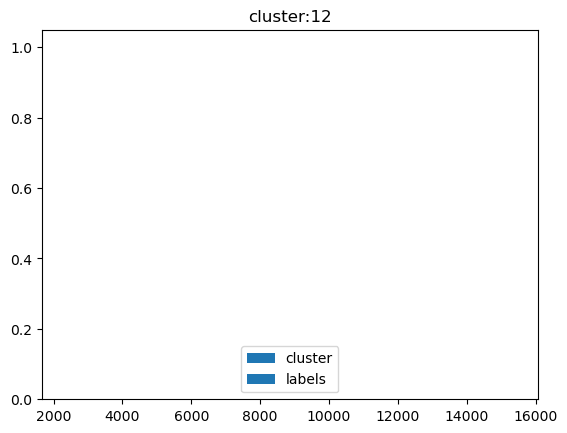

   0,     7, 0.0


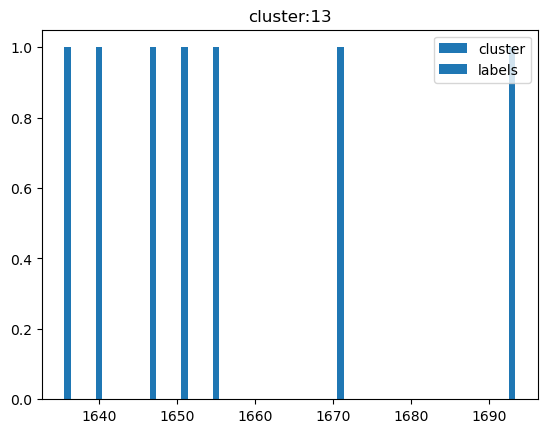

   0,     7, 0.0


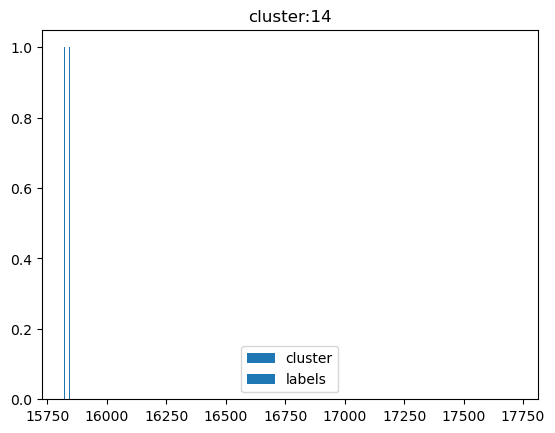

   6,     6, 100.0


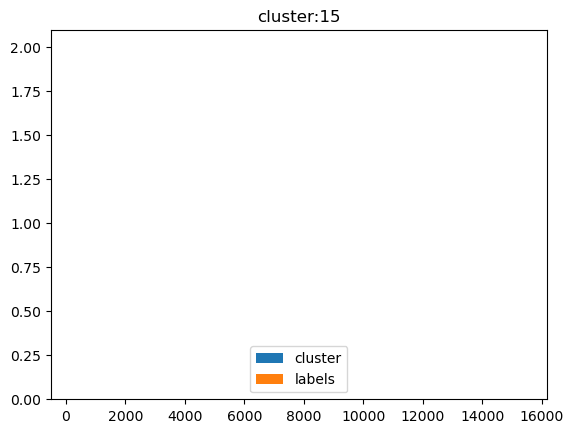

   0,     6, 0.0


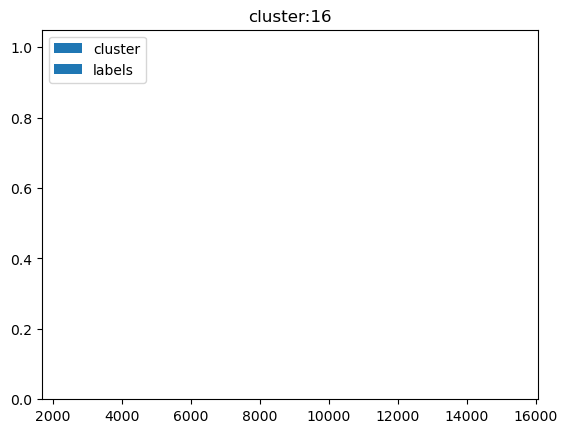

   0,     6, 0.0


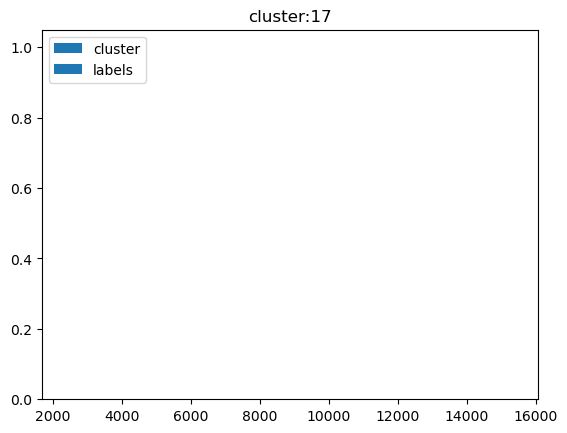

   0,     7, 0.0


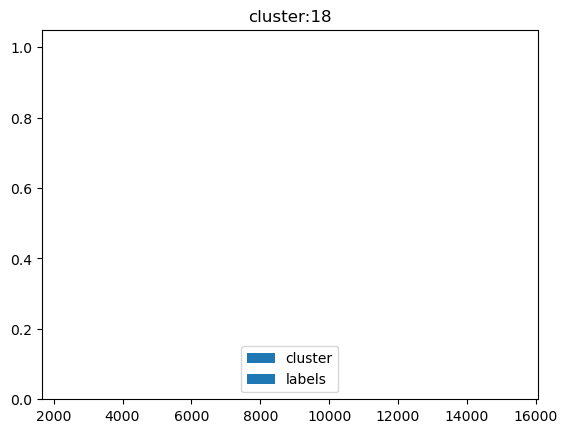

   0,     7, 0.0


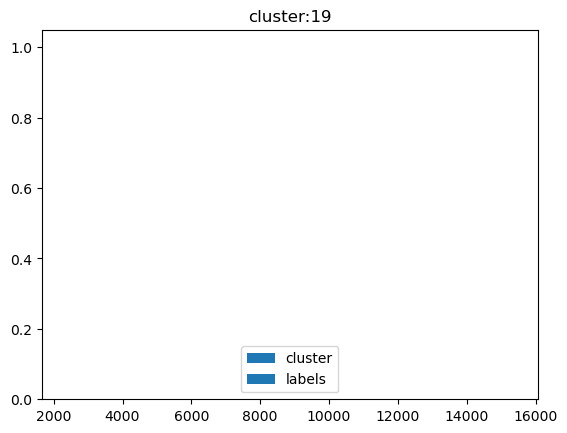

   0,     5, 0.0


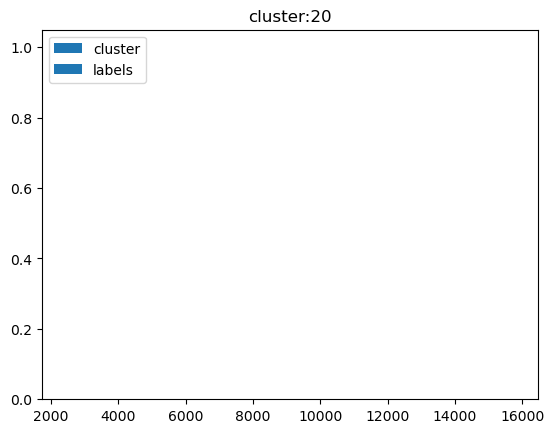

   0,     5, 0.0


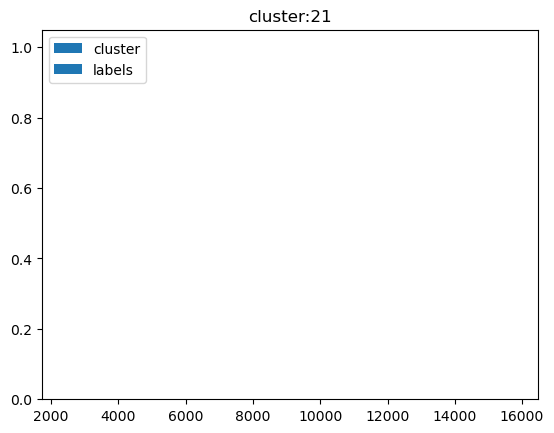

   5,     5, 100.0


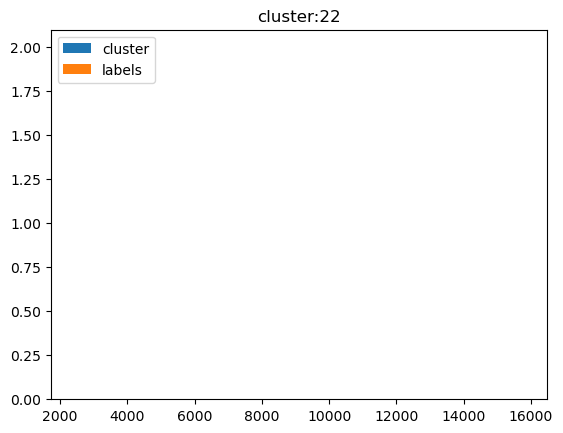

   0,     5, 0.0


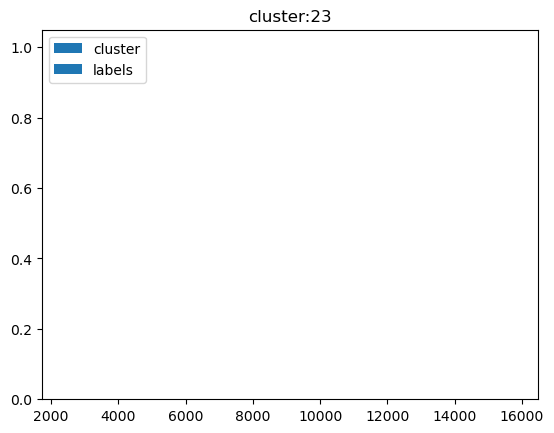

   0,     5, 0.0


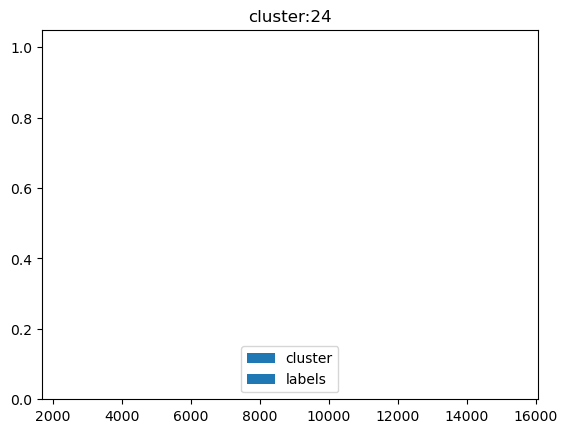

   0,     5, 0.0


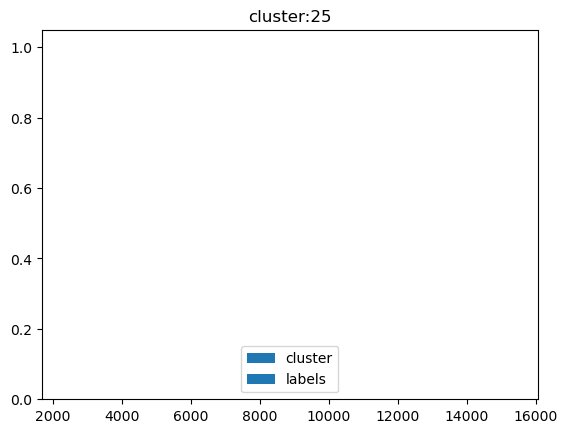

   0,     5, 0.0


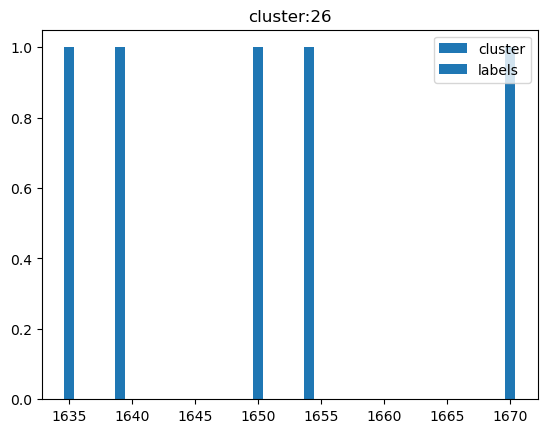

   0,     4, 0.0


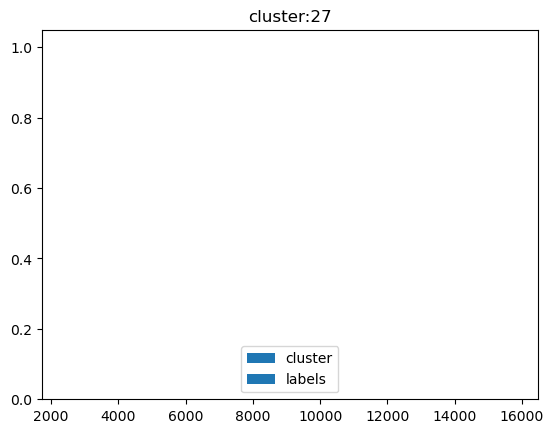

   0,     4, 0.0


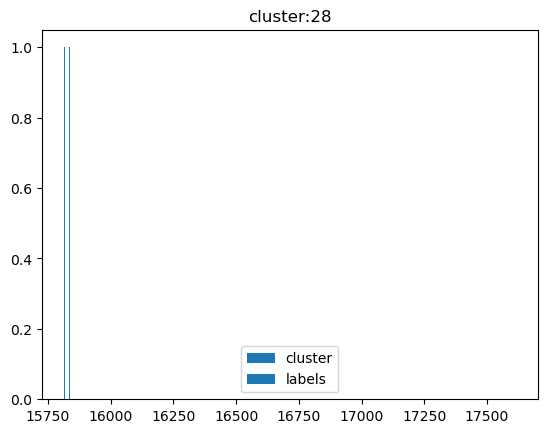

   0,     4, 0.0


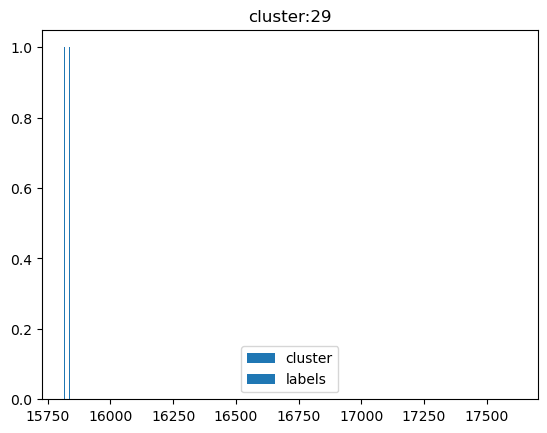

   0,     4, 0.0


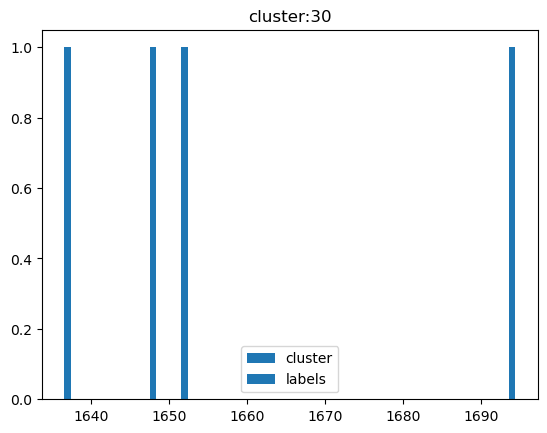

   0,     4, 0.0


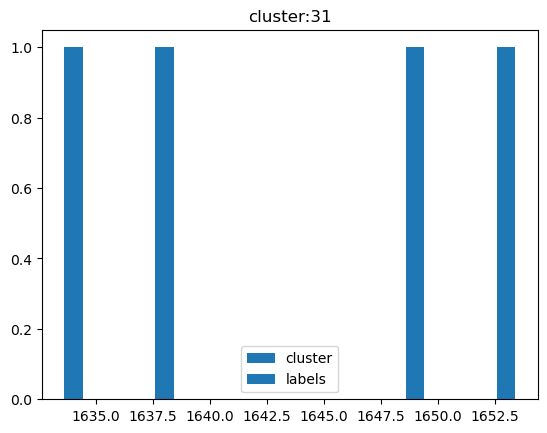

   0,     3, 0.0


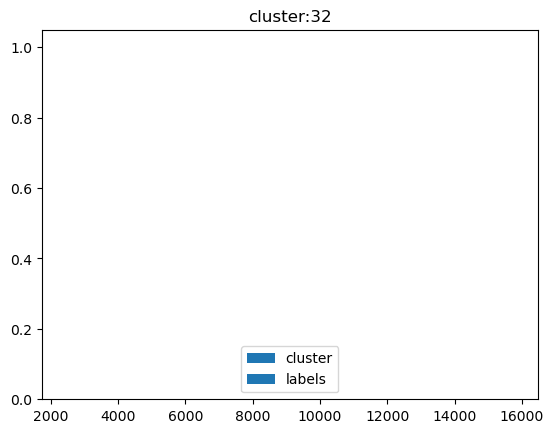

   0,     3, 0.0


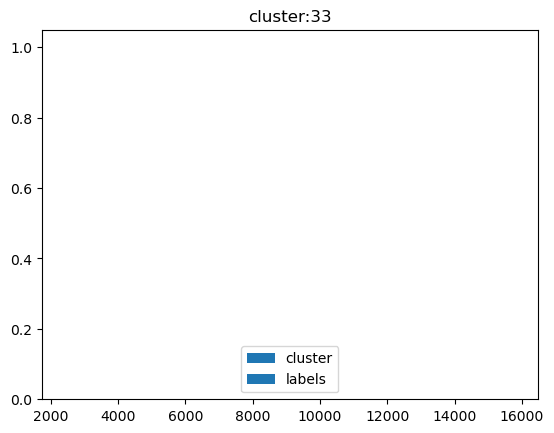

   0,     3, 0.0


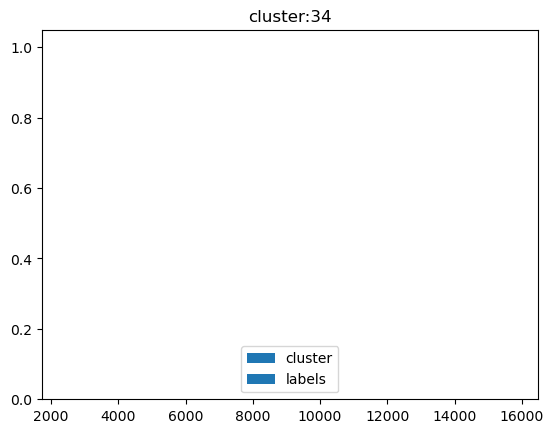

   0,     3, 0.0


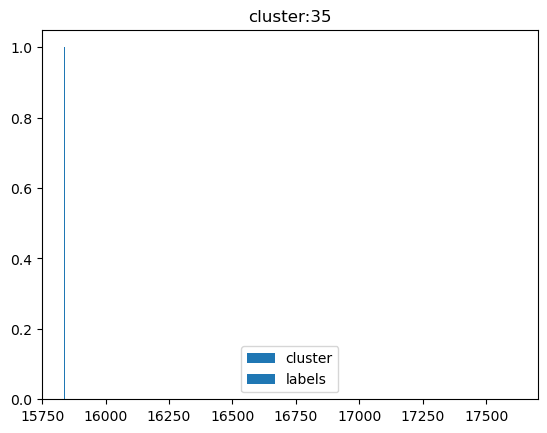

   0,     3, 0.0


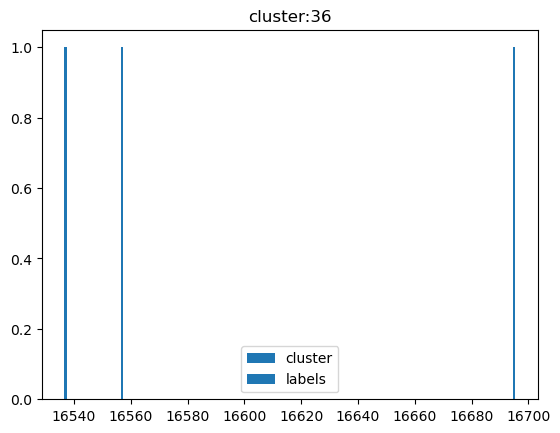

   0,     3, 0.0


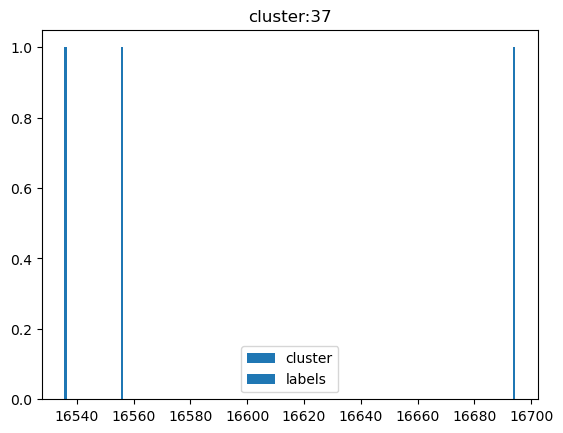

   0,     3, 0.0


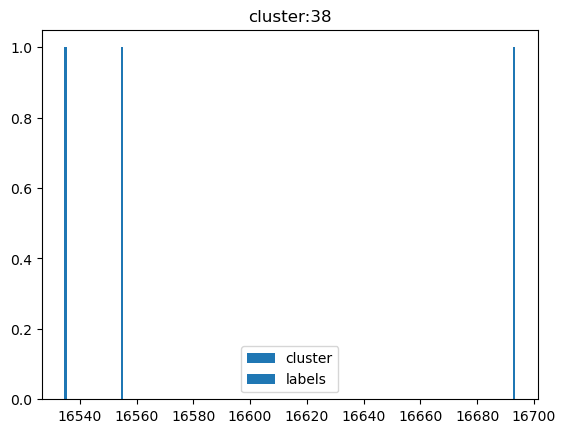

   0,     3, 0.0


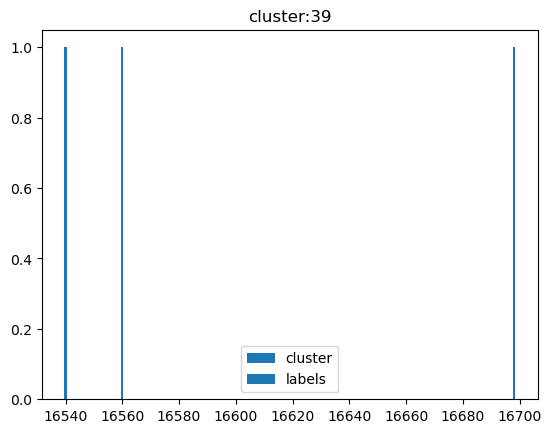

   0,     3, 0.0


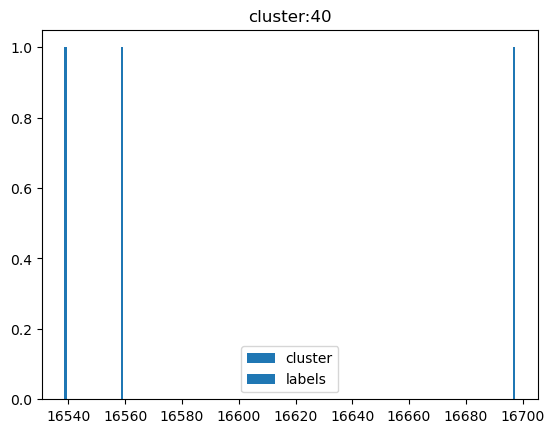

   0,     3, 0.0


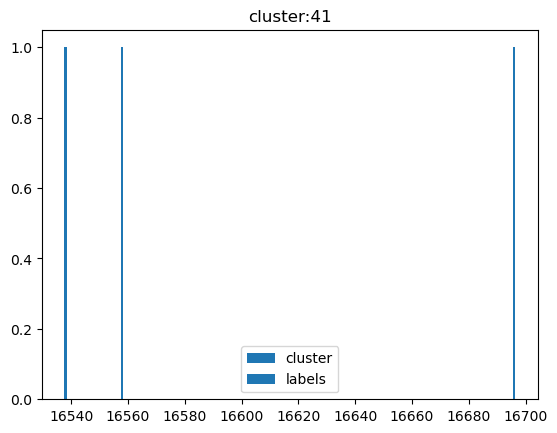

   0,     4, 0.0


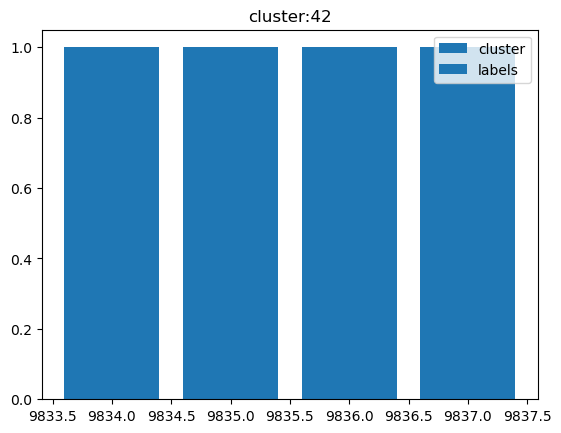

   0,    16, 0.0


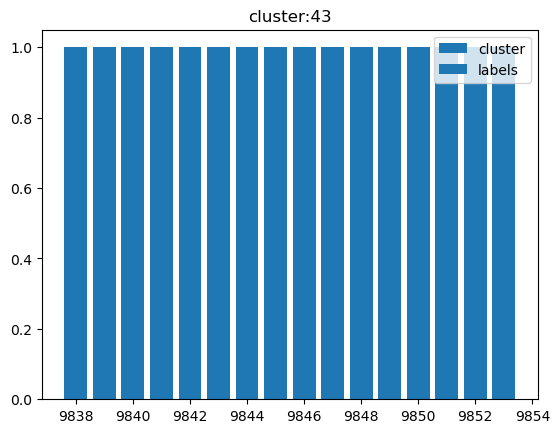

   0,     2, 0.0


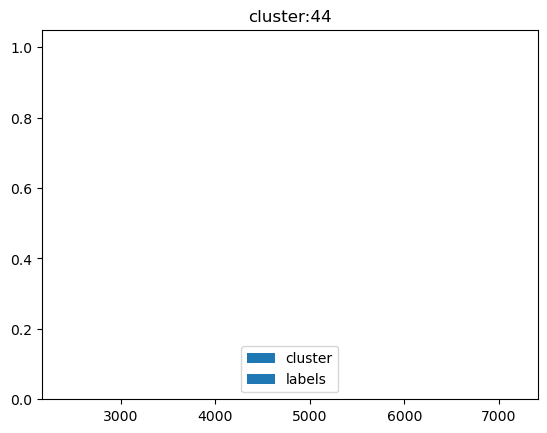

   0,     2, 0.0


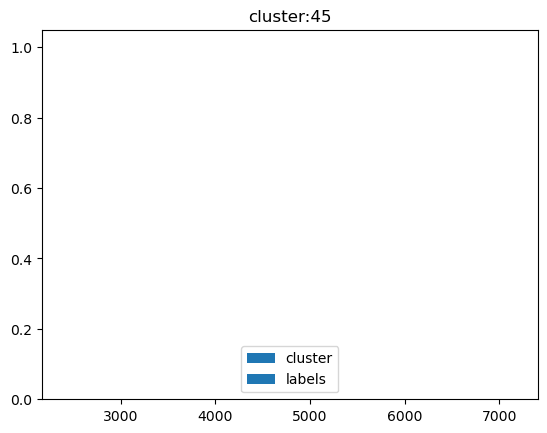

   0,     2, 0.0


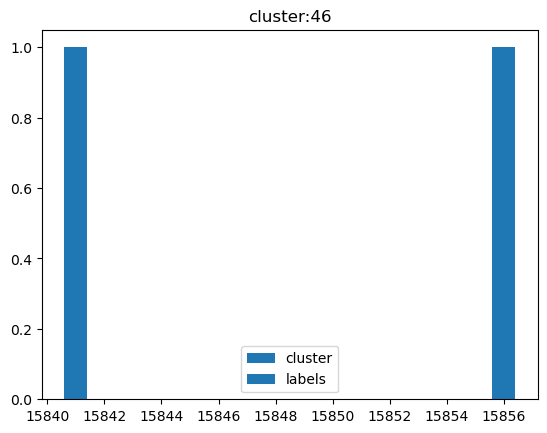

   0,     2, 0.0


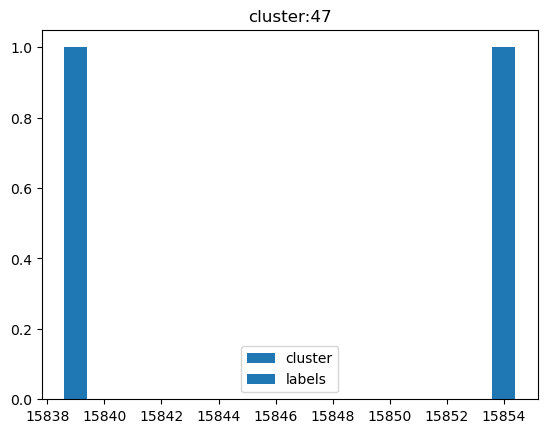

   0,     2, 0.0


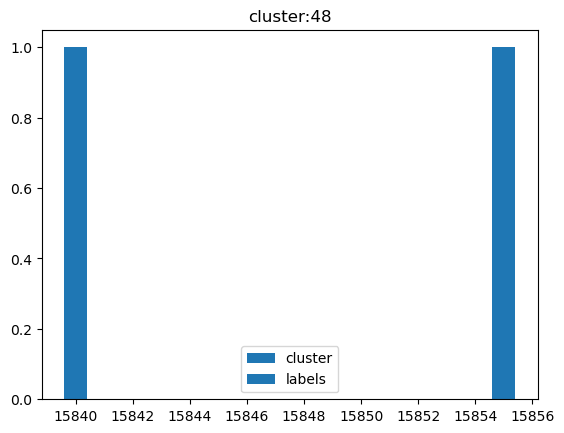

   0,     2, 0.0


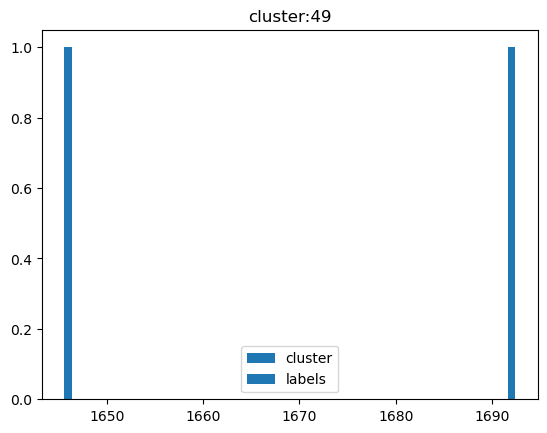

   0,     2, 0.0


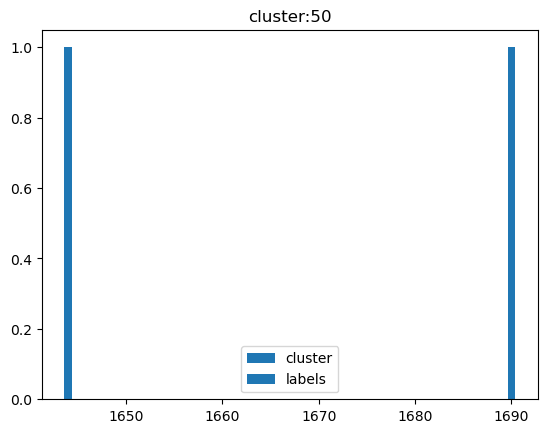

   0,     2, 0.0


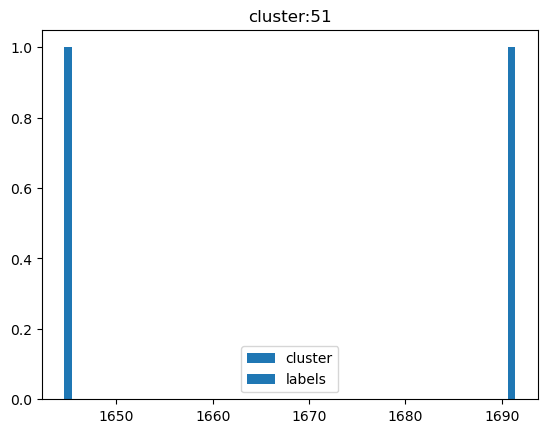

   0,     2, 0.0


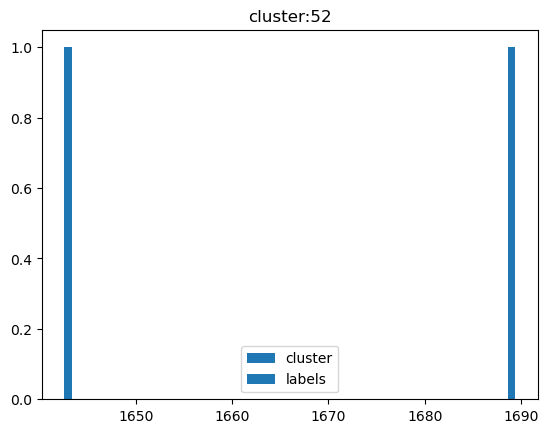

   1,     1, 100.0


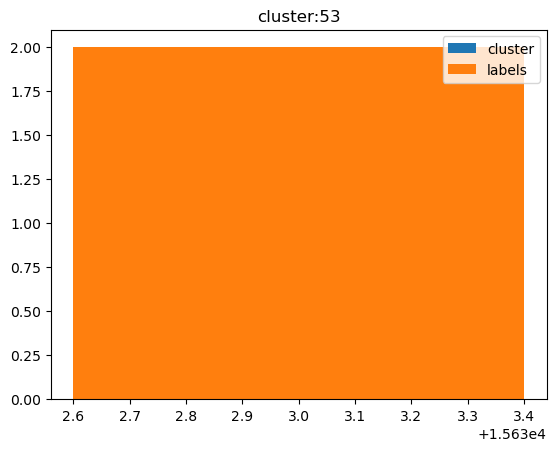

   0,     1, 0.0


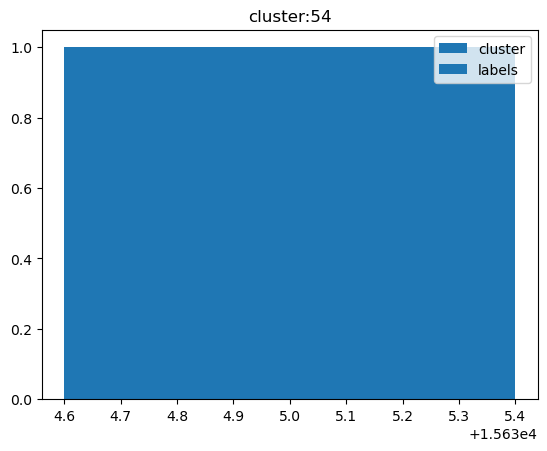

   1,     1, 100.0


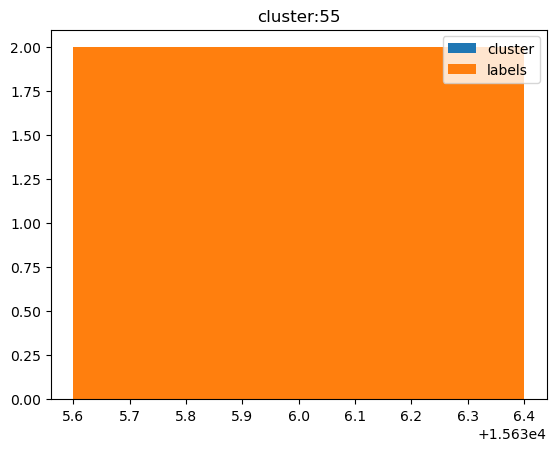

   0,     1, 0.0


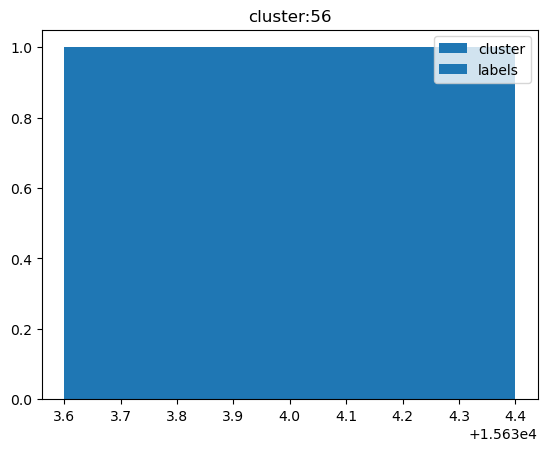

   0,     1, 0.0


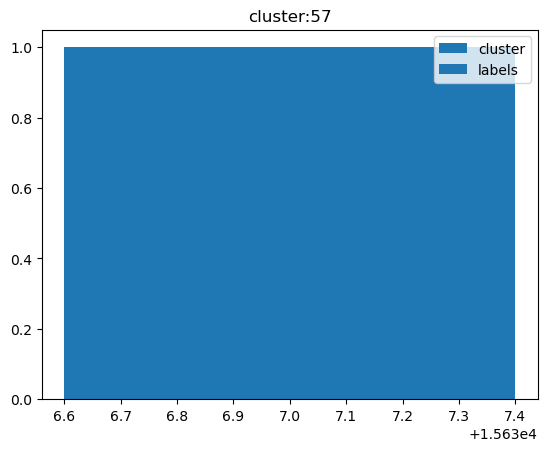

   0,     1, 0.0


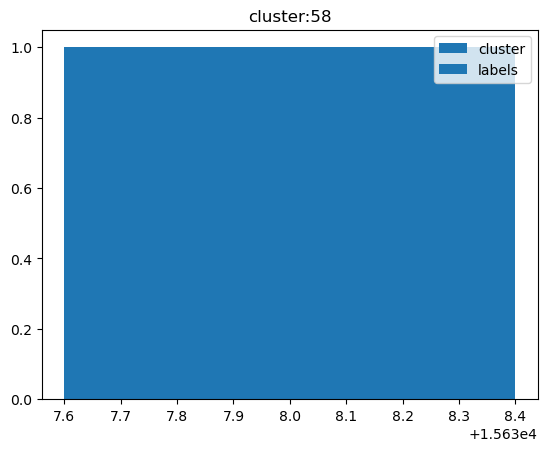

   0,     1, 0.0


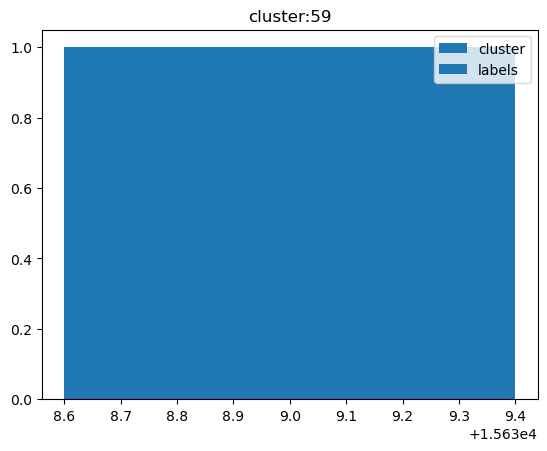

   0,     1, 0.0


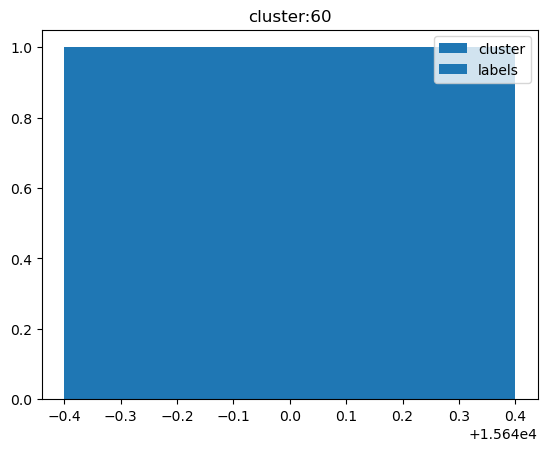

   0,     1, 0.0


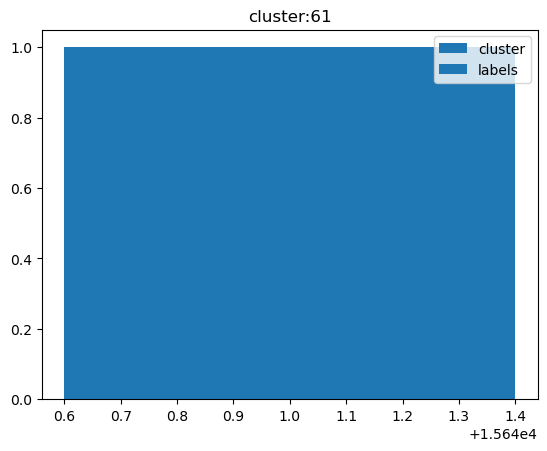

   0,     1, 0.0


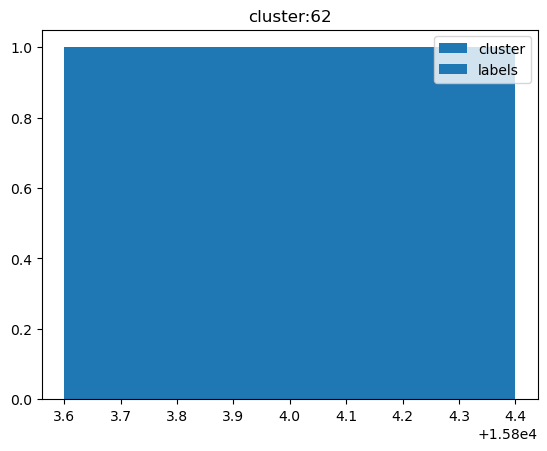

   0,     1, 0.0


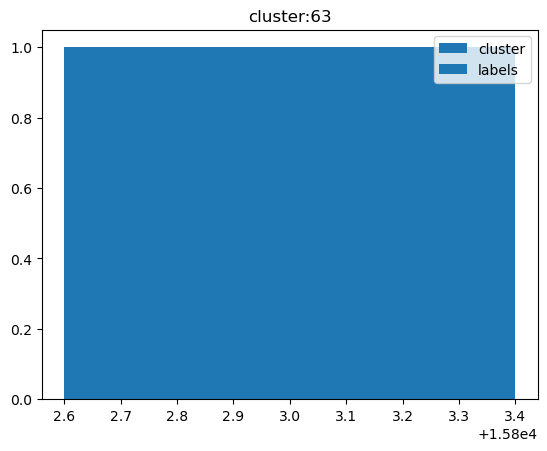

   0,     1, 0.0


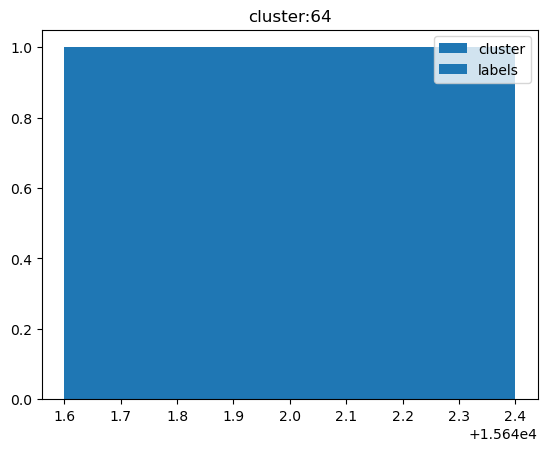

   0,     1, 0.0


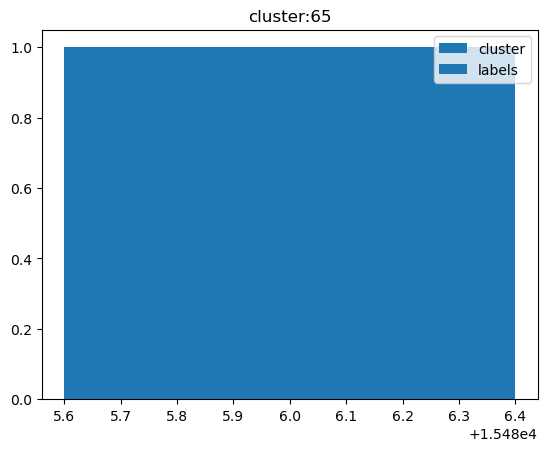

   0,     1, 0.0


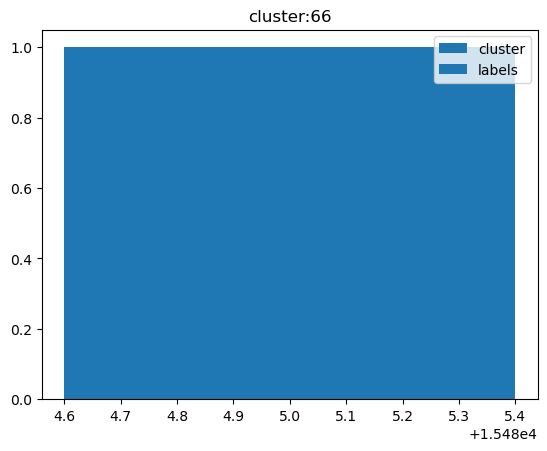

   0,     1, 0.0


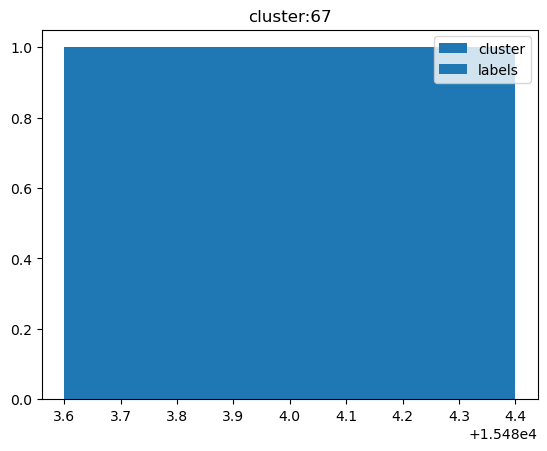

   0,     1, 0.0


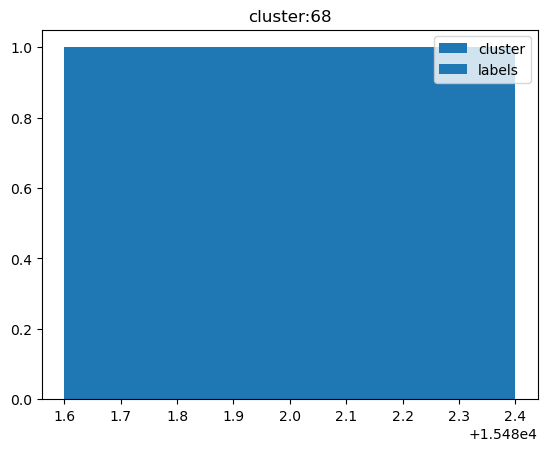

   0,     1, 0.0


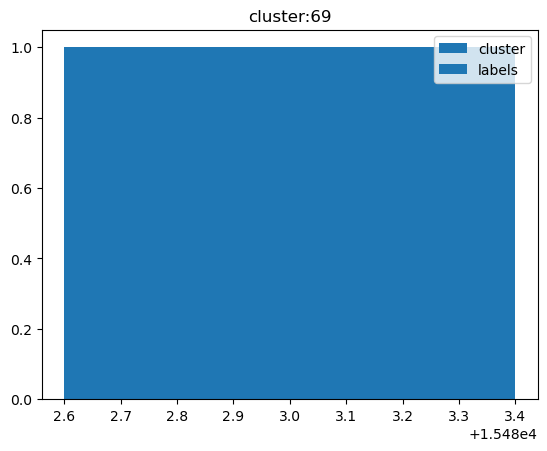

   0,     1, 0.0


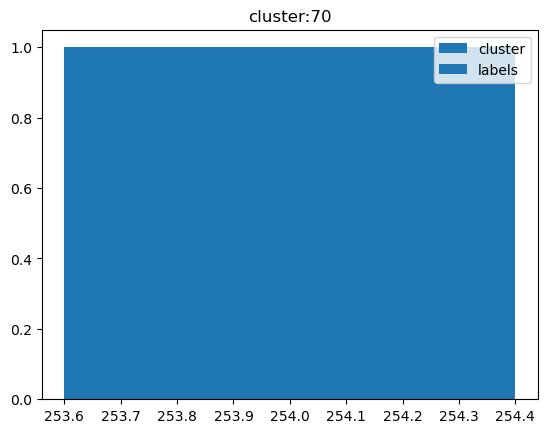

   0,     1, 0.0


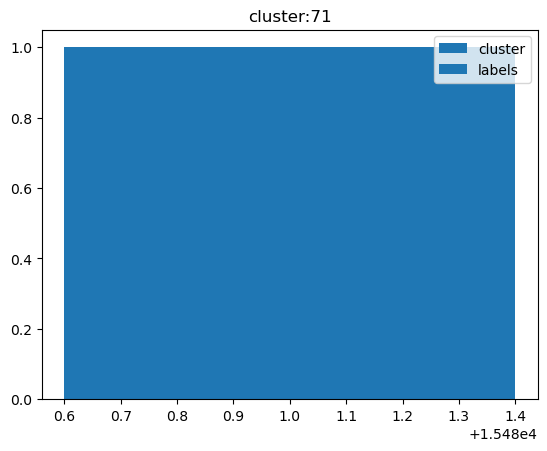

   0,     1, 0.0


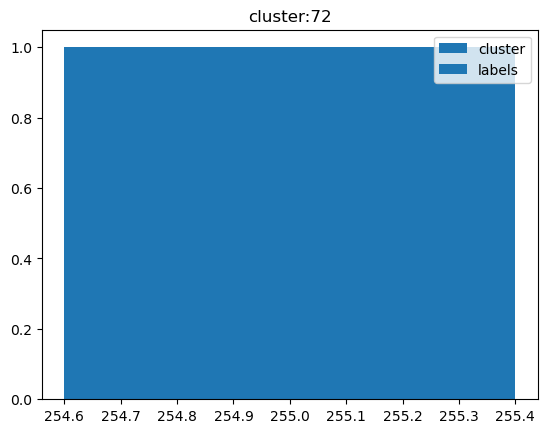

   0,     1, 0.0


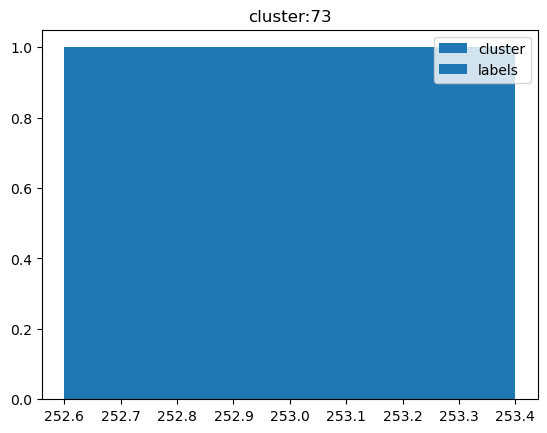

   0,     1, 0.0


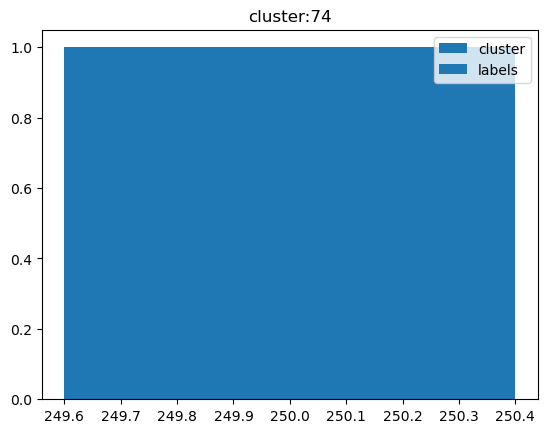

   0,     1, 0.0


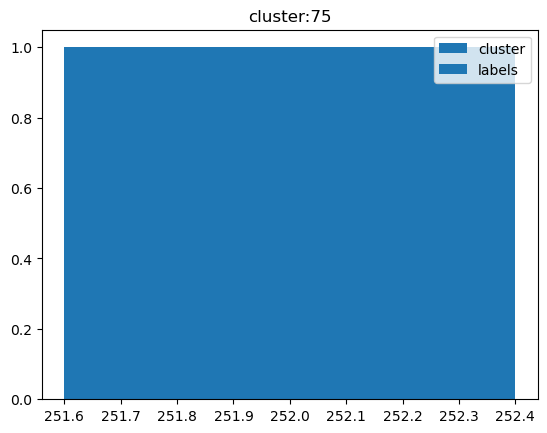

   0,     1, 0.0


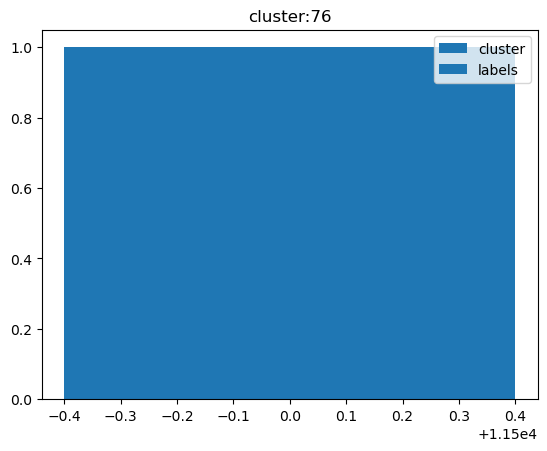

   0,     1, 0.0


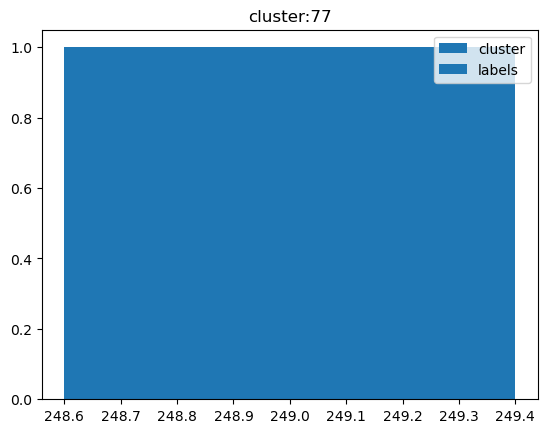

   0,     1, 0.0


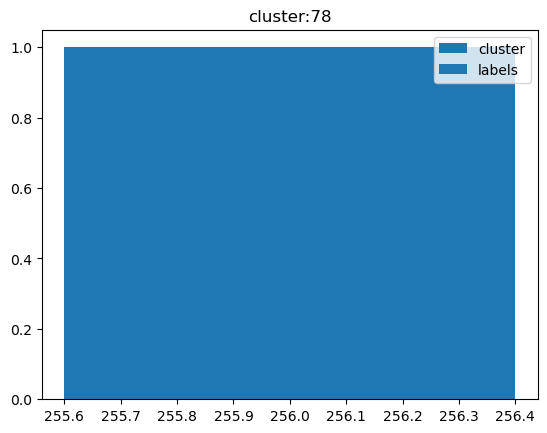

   0,     1, 0.0


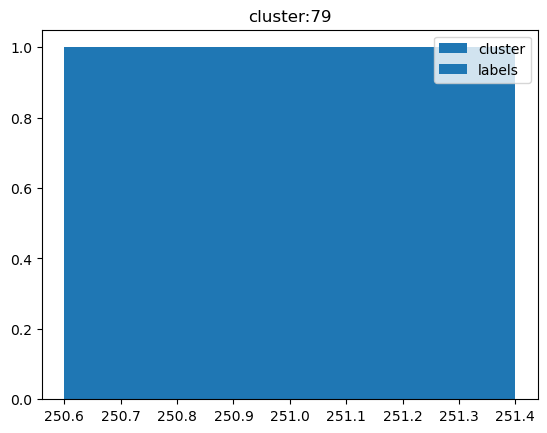

   0,     3, 0.0


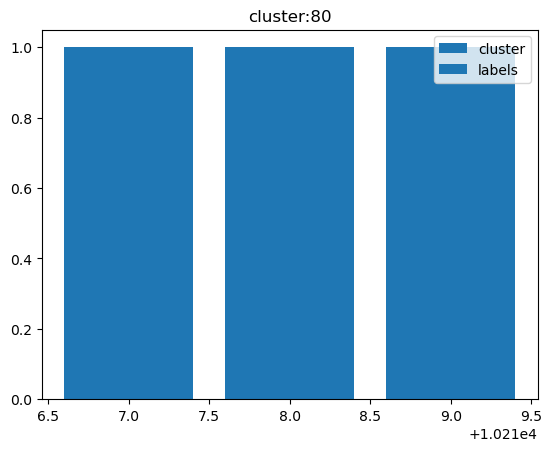

   0,     1, 0.0


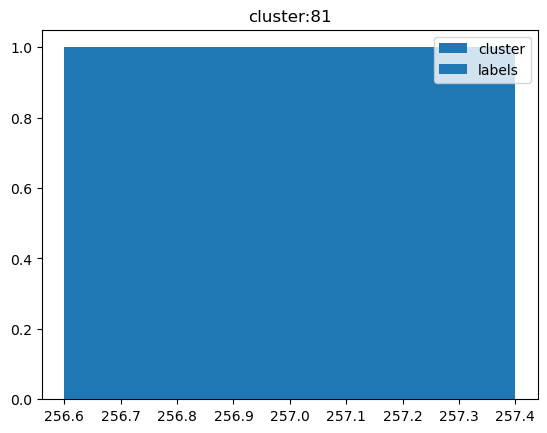

   0,     1, 0.0


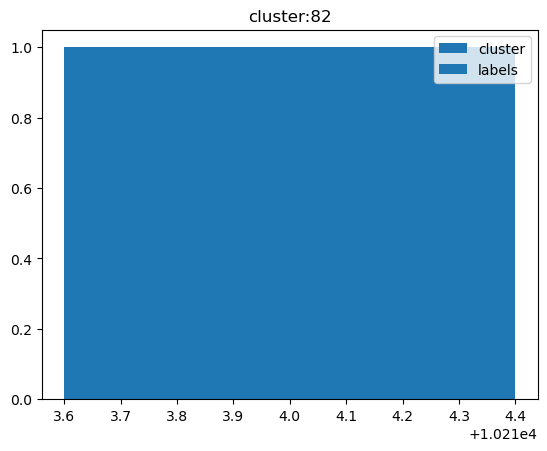

   0,     1, 0.0


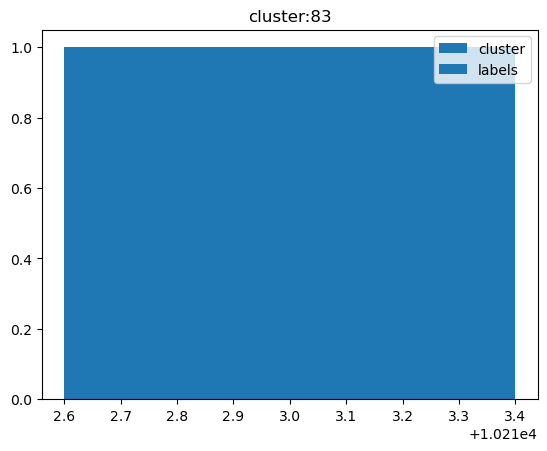

   0,     1, 0.0


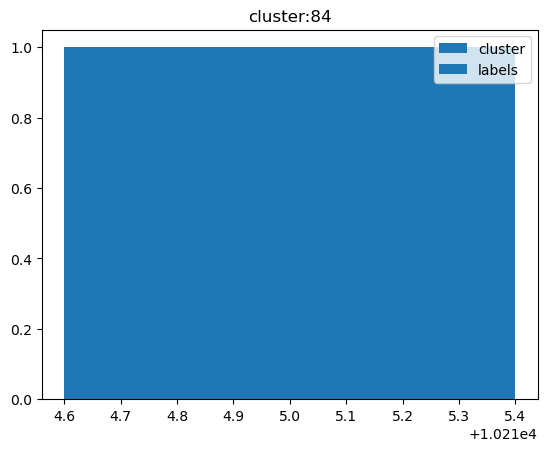

   0,     1, 0.0


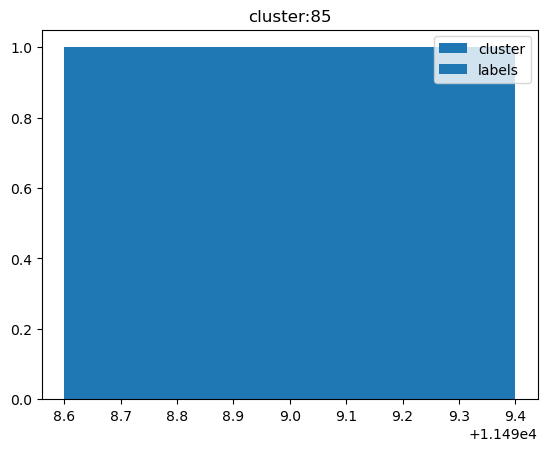

   0,     1, 0.0


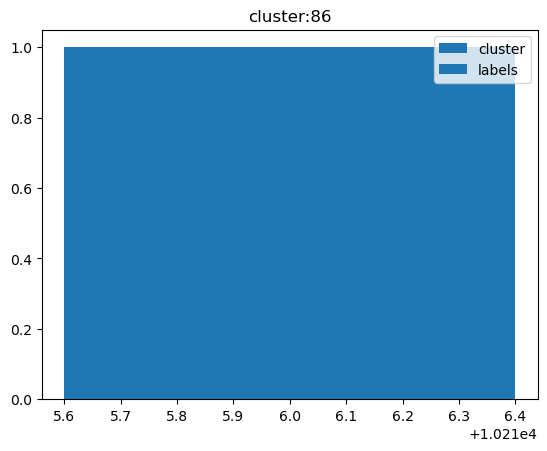

   0,     1, 0.0


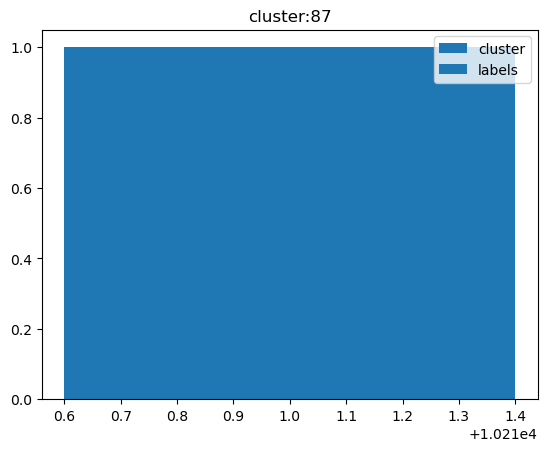

   0,     1, 0.0


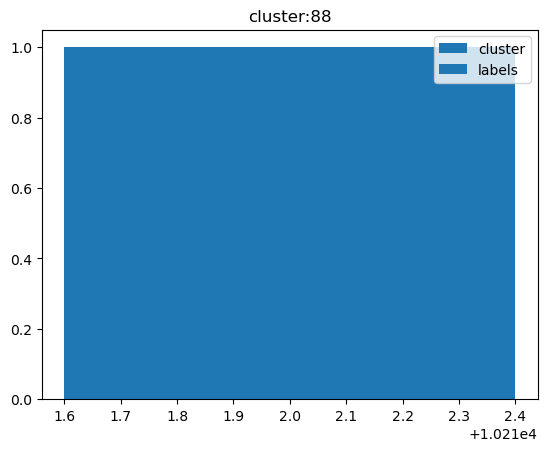

   0,     1, 0.0


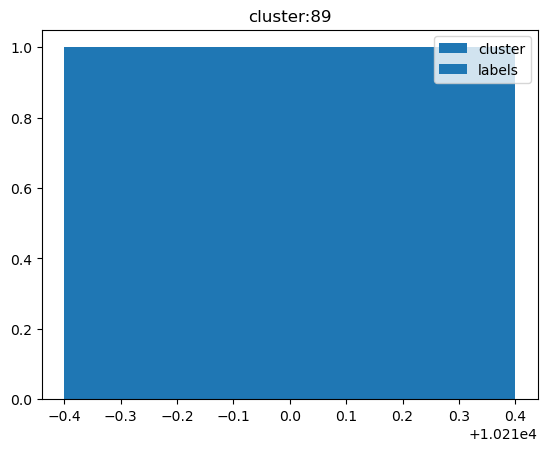

   0,    30, 0.0


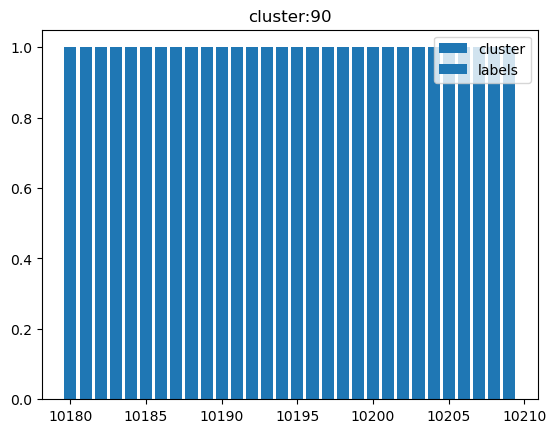

   0,     1, 0.0


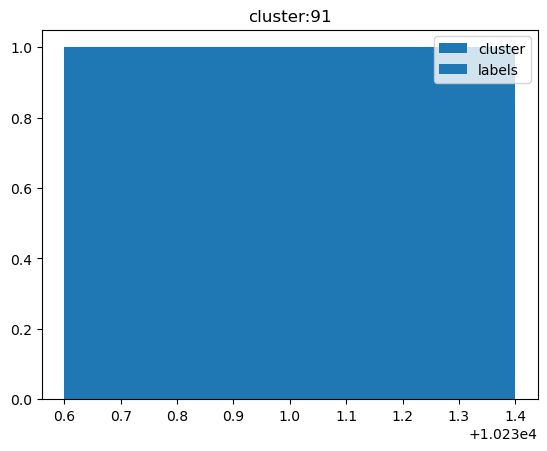

   0,     1, 0.0


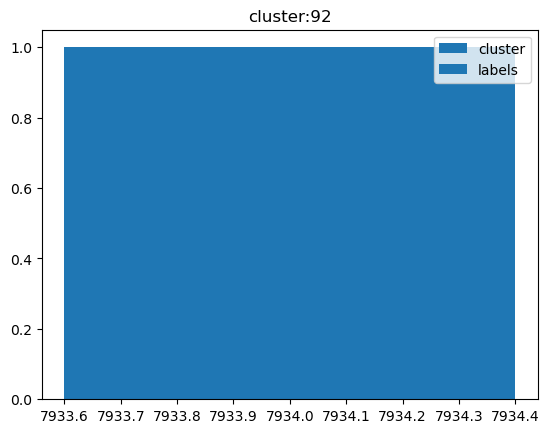

   0,     1, 0.0


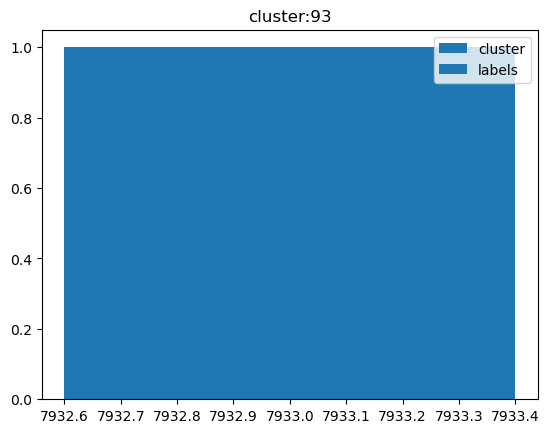

   0,     1, 0.0


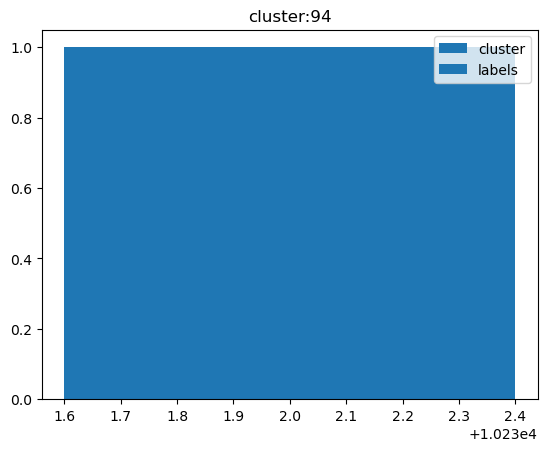

   1,     1, 100.0


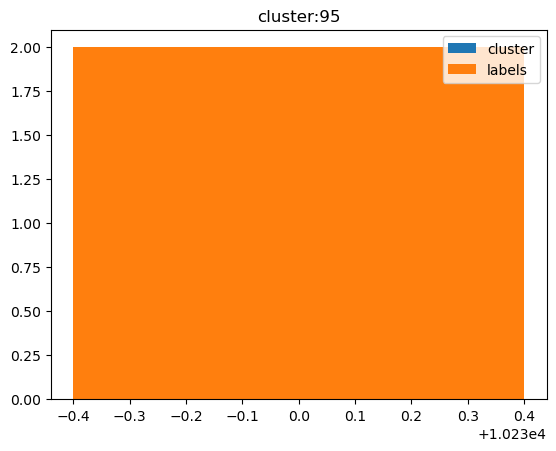

   0,     1, 0.0


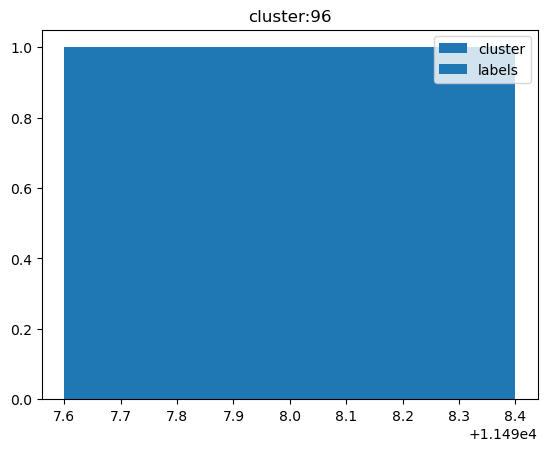

   1,     1, 100.0


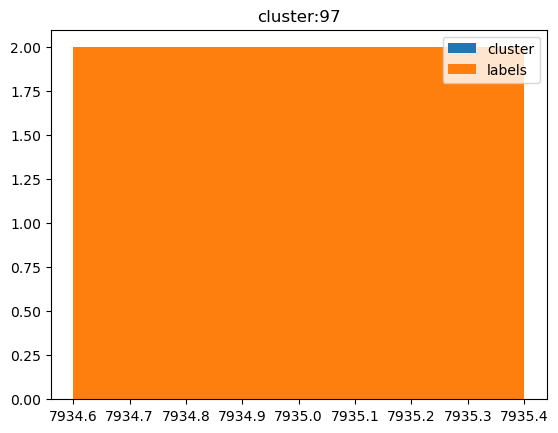

   0,     1, 0.0


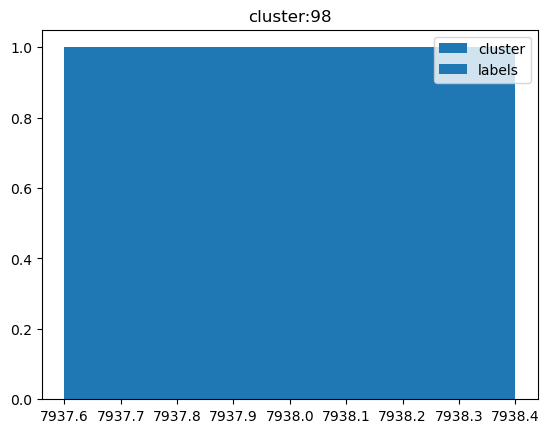

   0,     1, 0.0


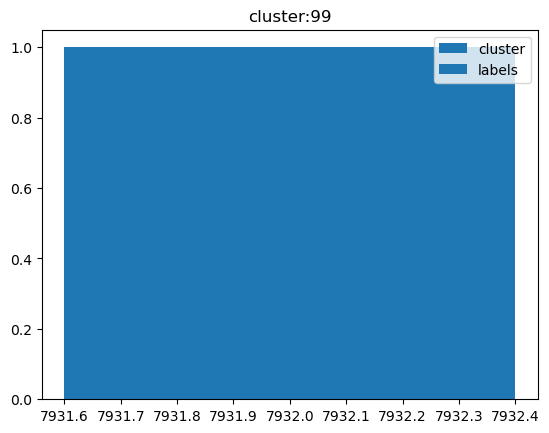

   0,     1, 0.0


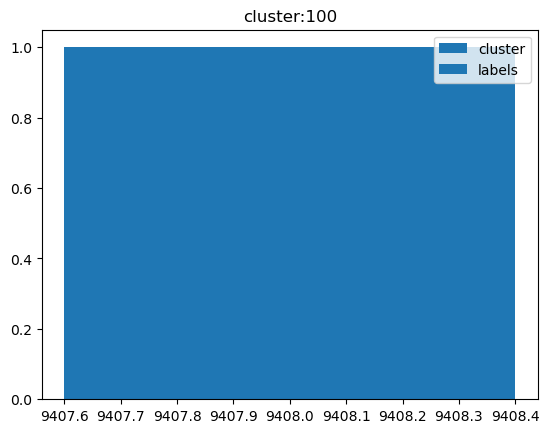

   0,     1, 0.0


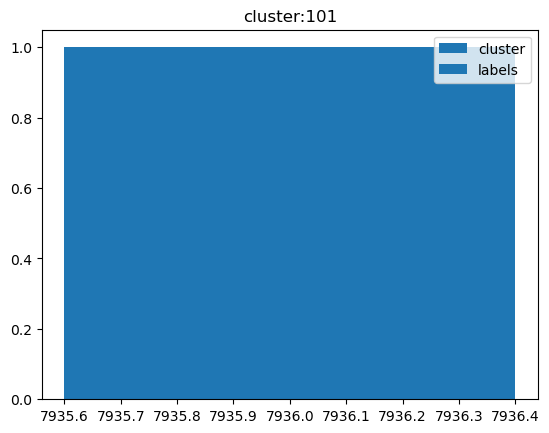

   0,     1, 0.0


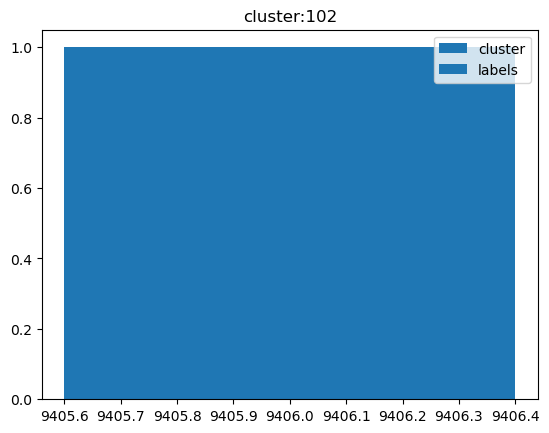

   0,     1, 0.0


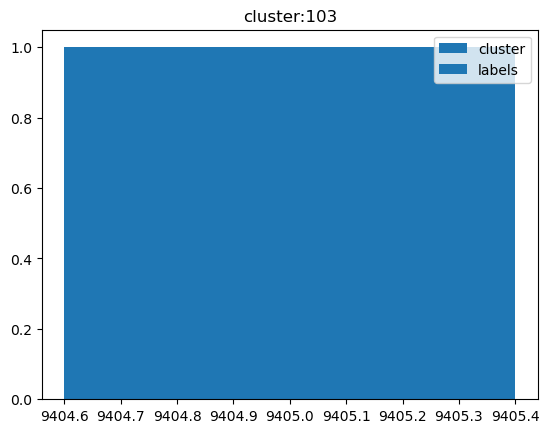

   0,     2, 0.0


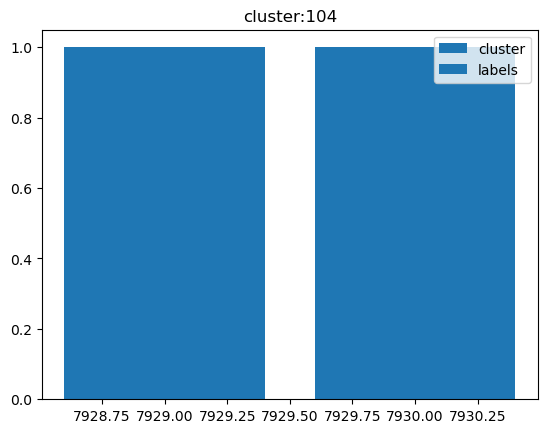

   0,     1, 0.0


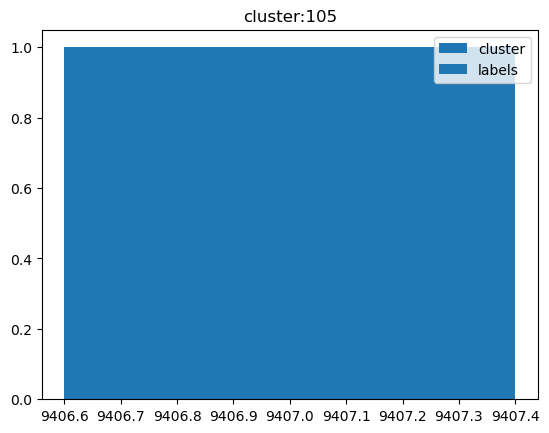

   0,     1, 0.0


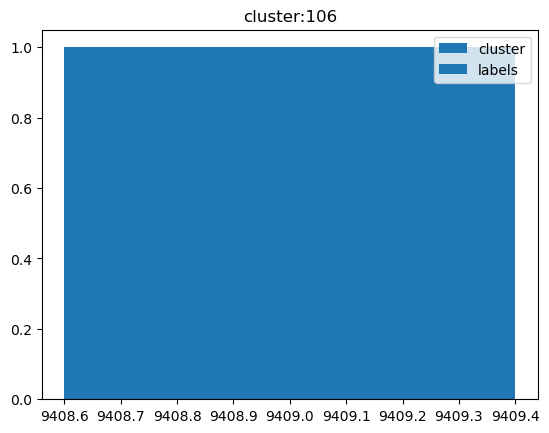

   0,     1, 0.0


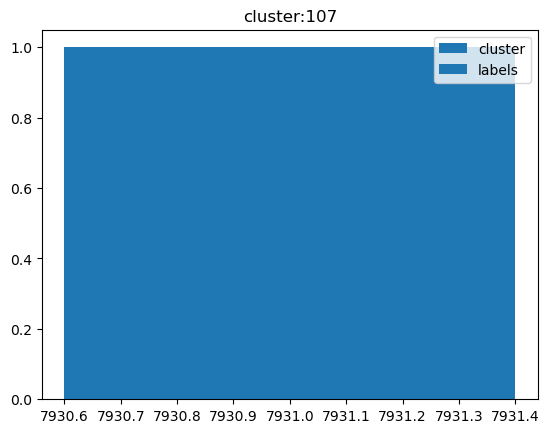

   0,     1, 0.0


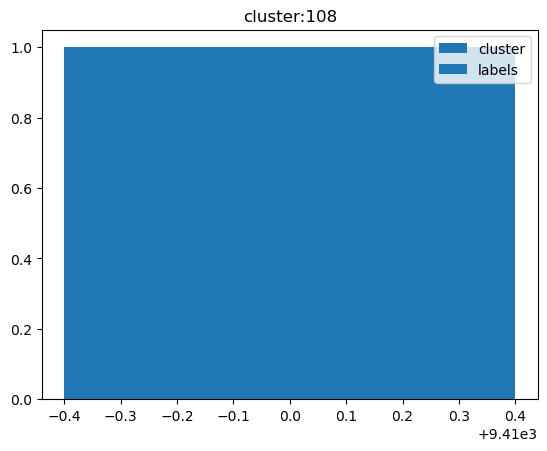

   0,     1, 0.0


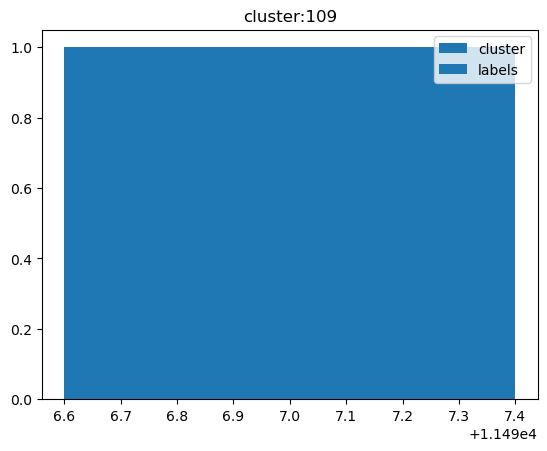

   0,     1, 0.0


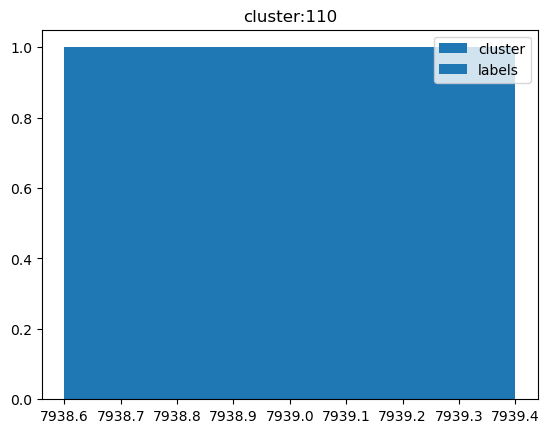

   0,     1, 0.0


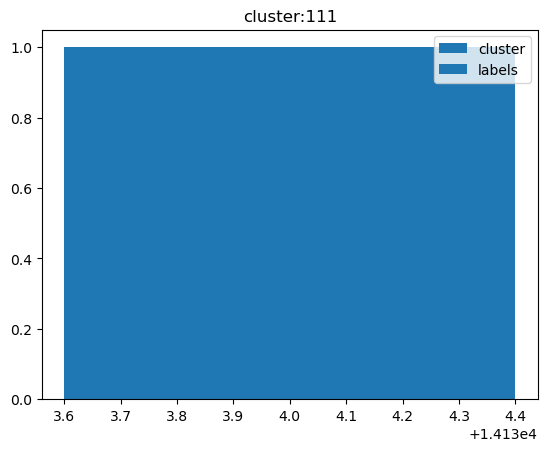

   0,     1, 0.0


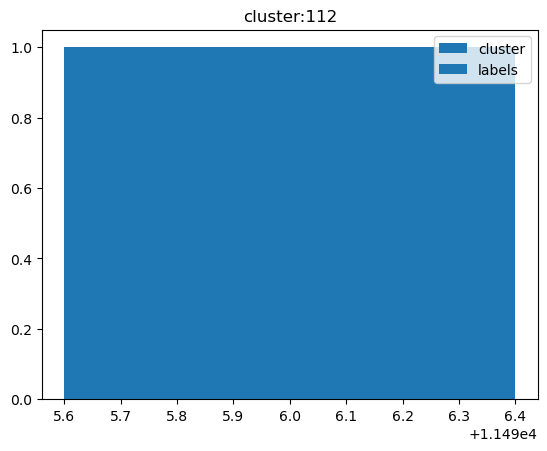

   0,     1, 0.0


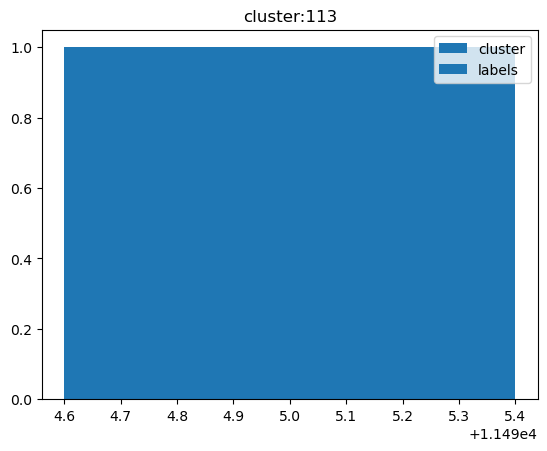

   1,     1, 100.0


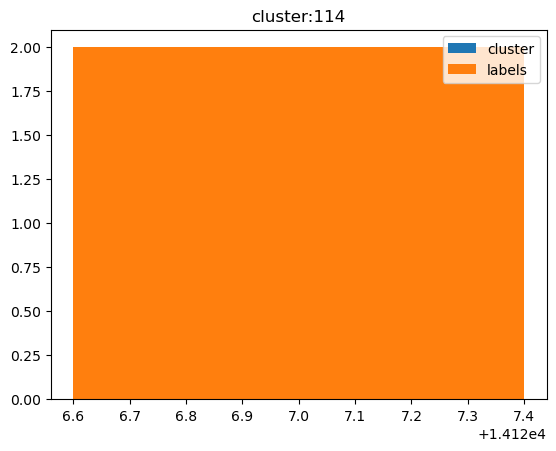

   0,     1, 0.0


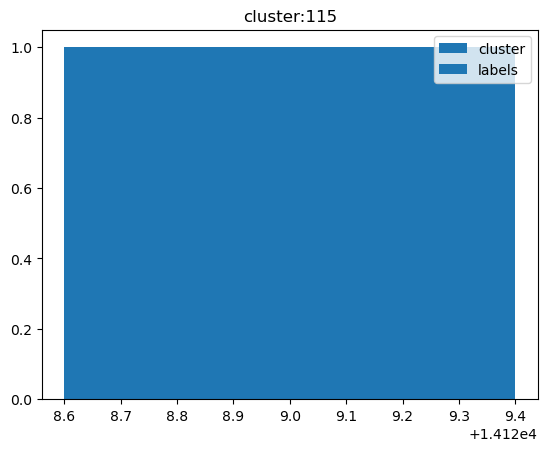

   0,     1, 0.0


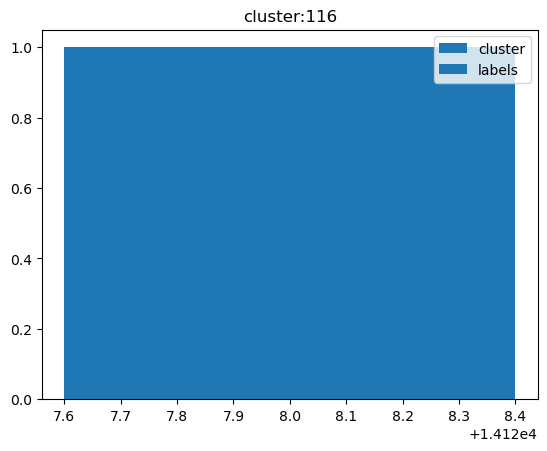

   0,     1, 0.0


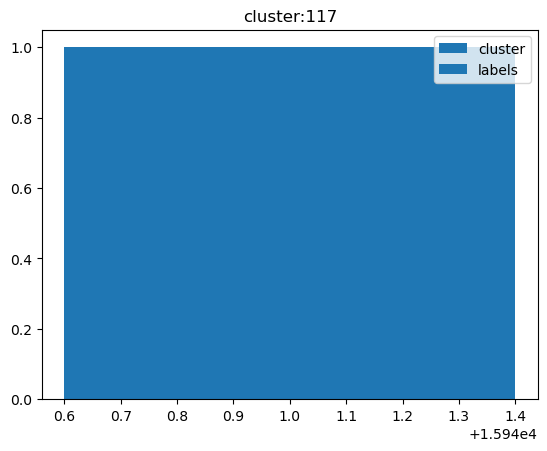

   0,     1, 0.0


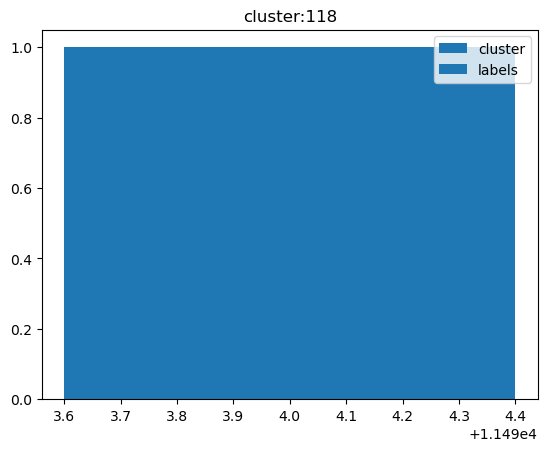

   0,     1, 0.0


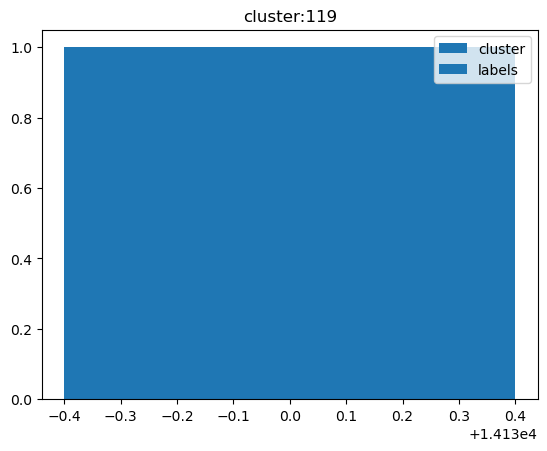

   0,     1, 0.0


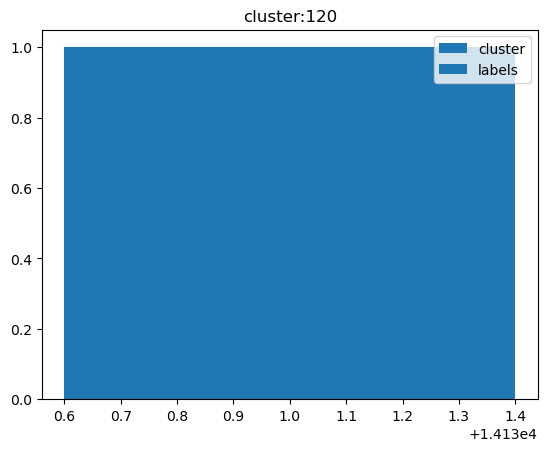

   0,     1, 0.0


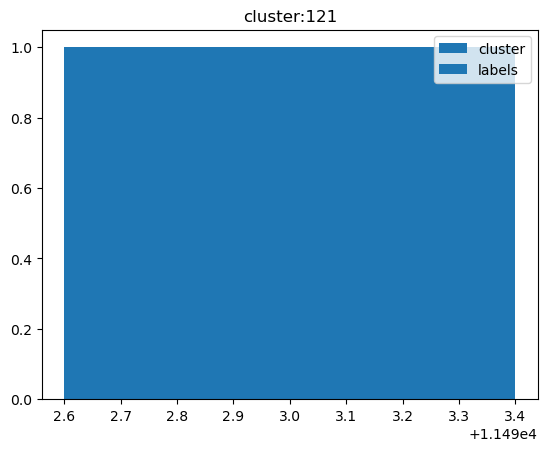

   0,     1, 0.0


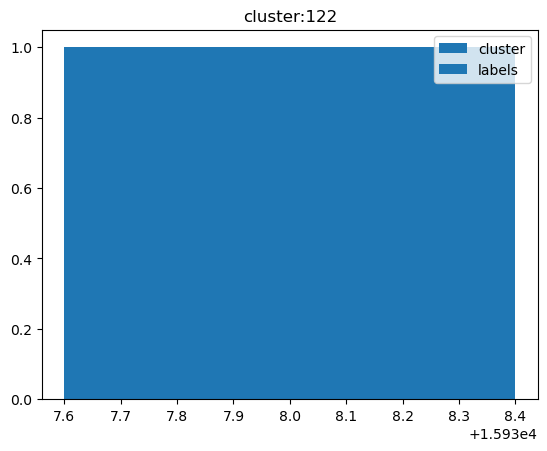

   0,     1, 0.0


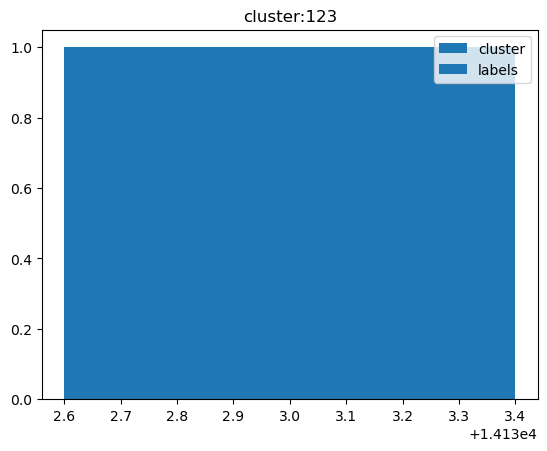

   0,     1, 0.0


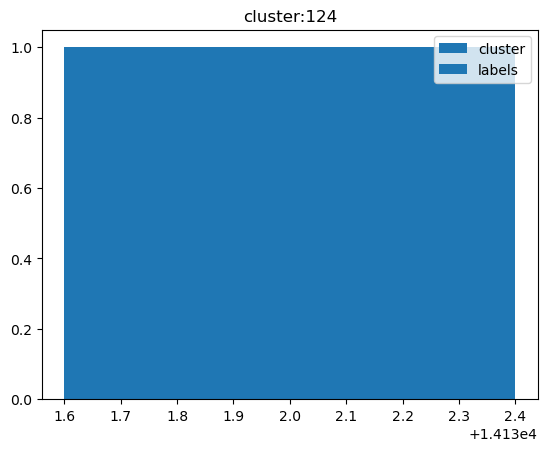

   1,     1, 100.0


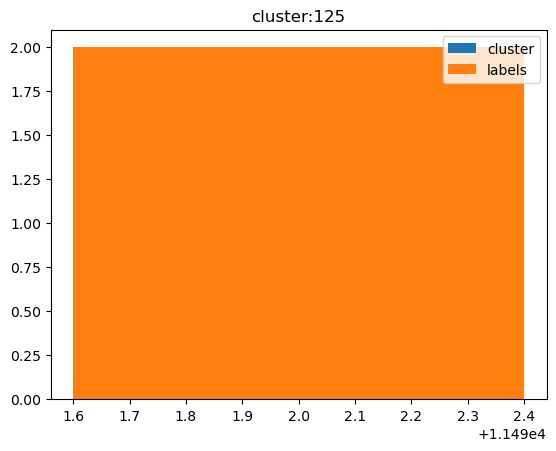

   0,     2, 0.0


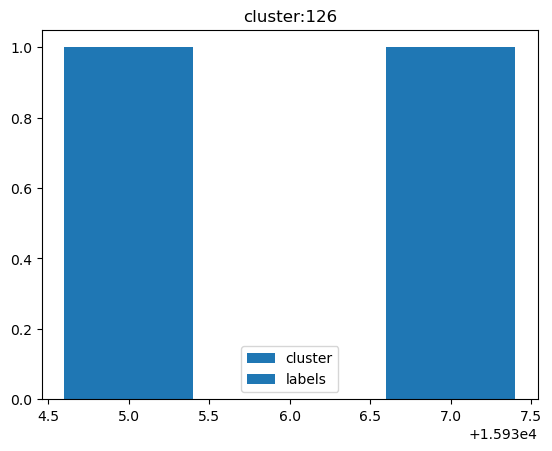

   0,     1, 0.0


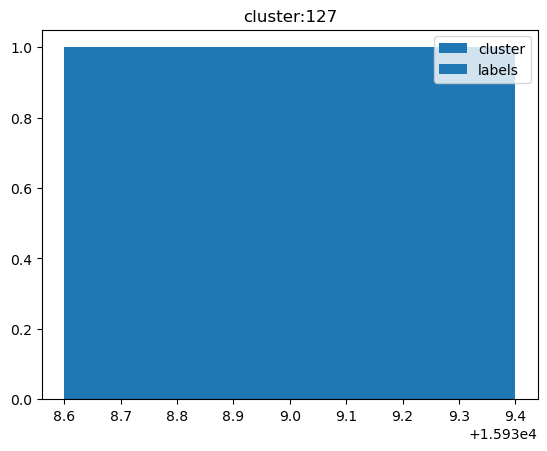

   0,     1, 0.0


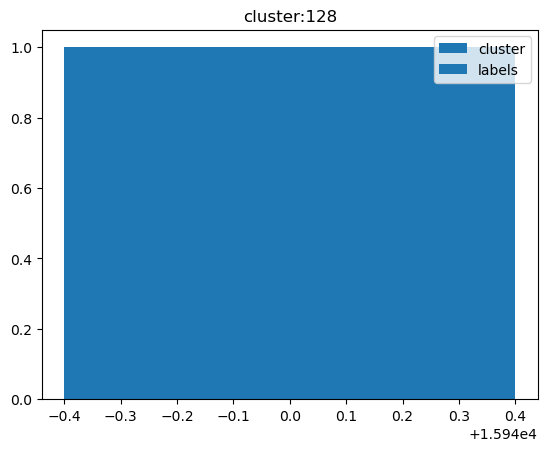

   0,     1, 0.0


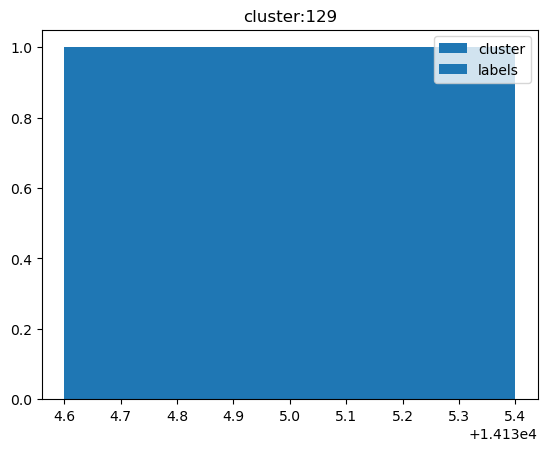

   0,     1, 0.0


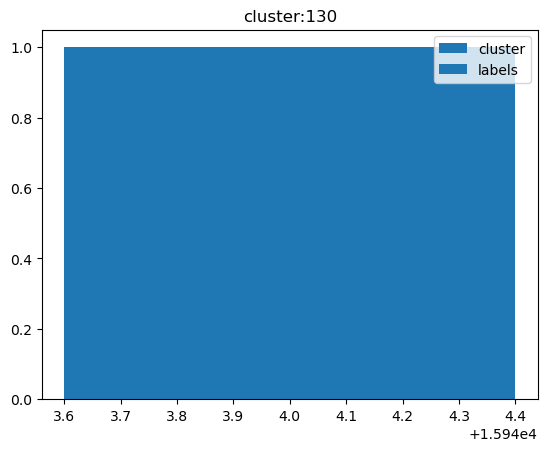

   0,     1, 0.0


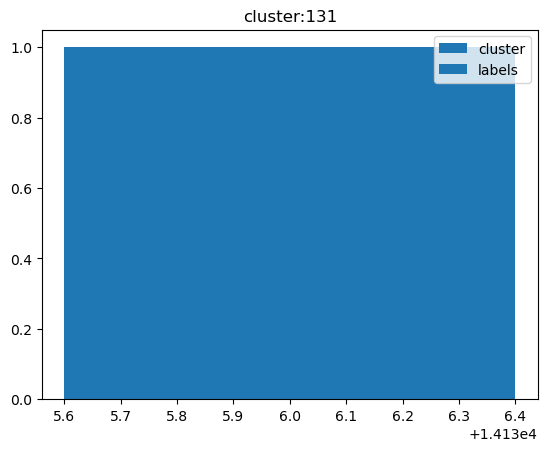

   0,     1, 0.0


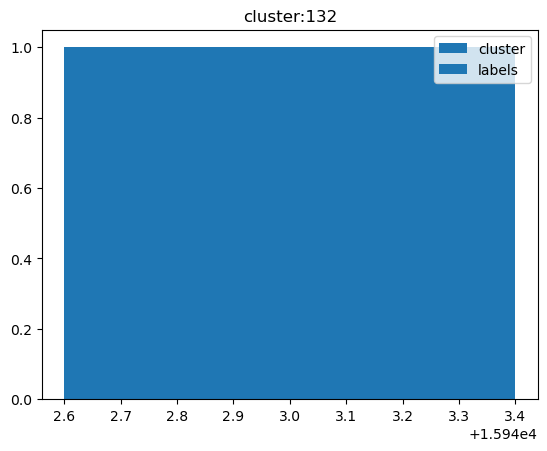

   0,     1, 0.0


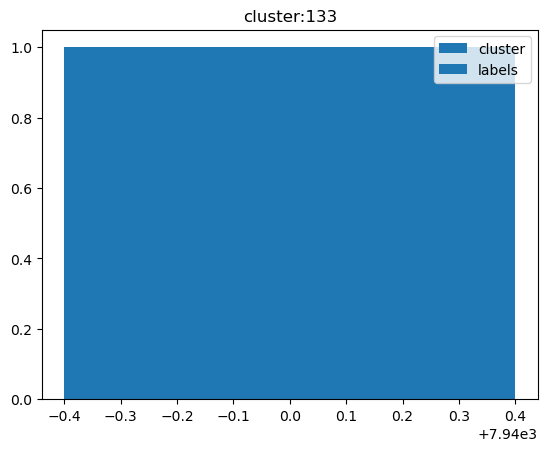

   0,     1, 0.0


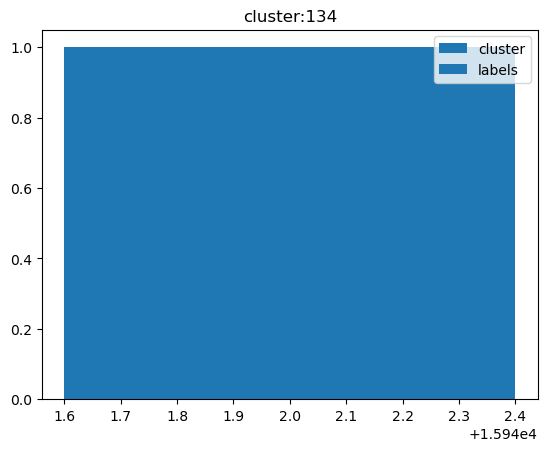

   0,     1, 0.0


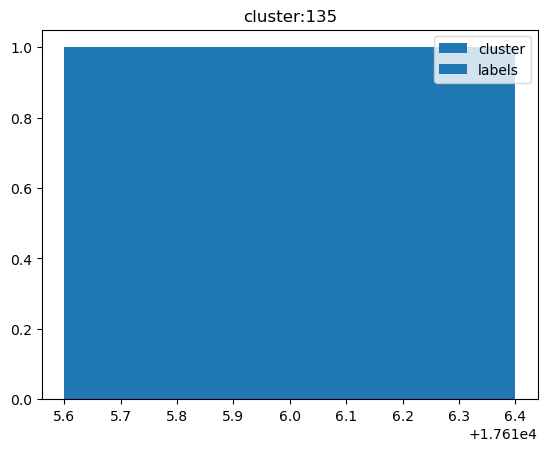

   0,     1, 0.0


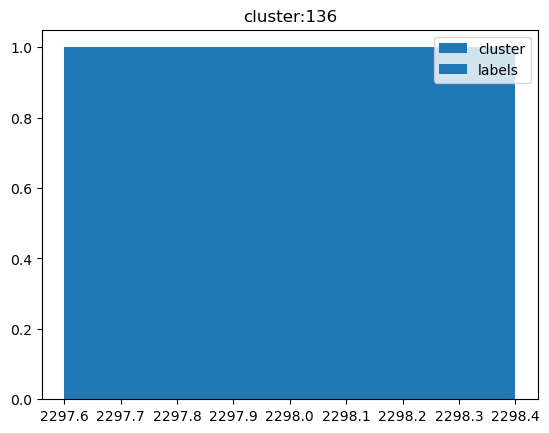

   0,     1, 0.0


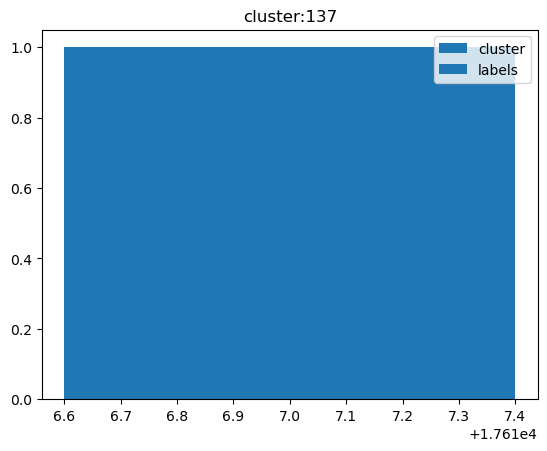

   0,     1, 0.0


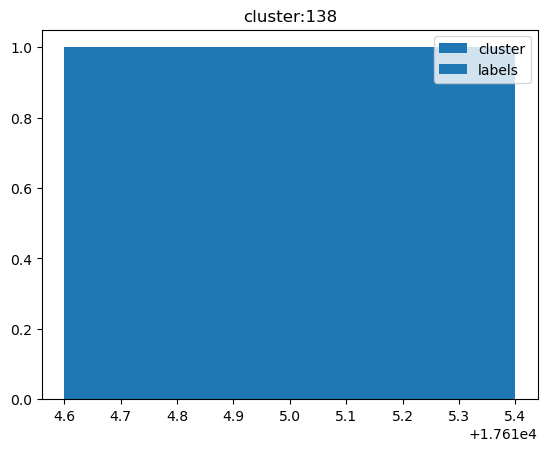

   0,     1, 0.0


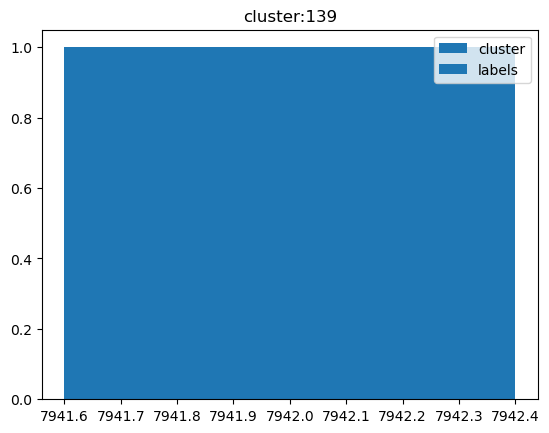

   1,     1, 100.0


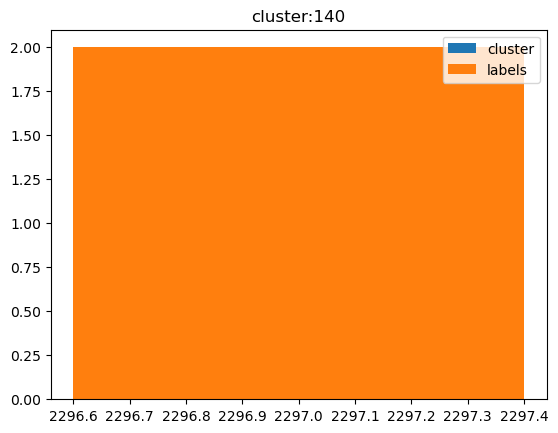

   0,     1, 0.0


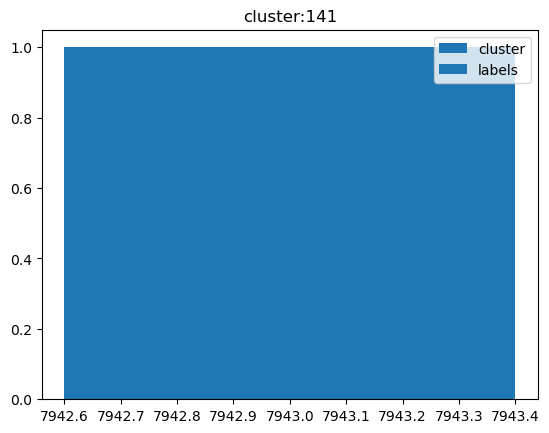

   0,     1, 0.0


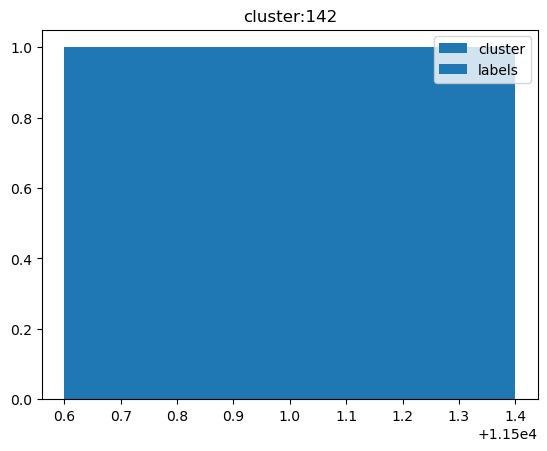

   0,     1, 0.0


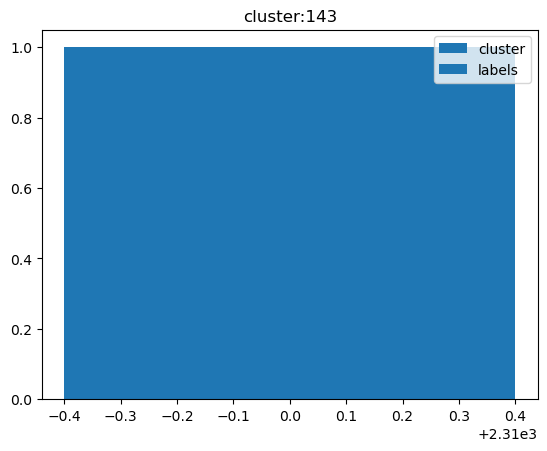

   0,     1, 0.0


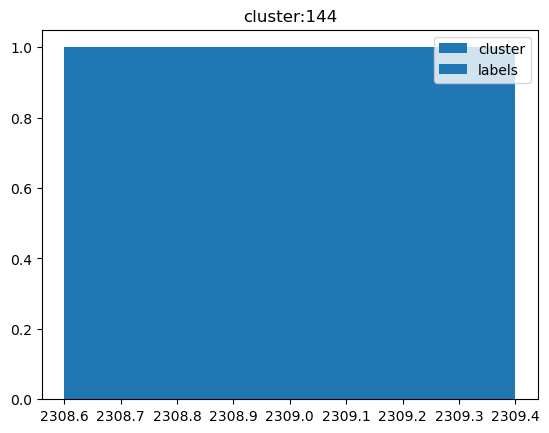

   0,     1, 0.0


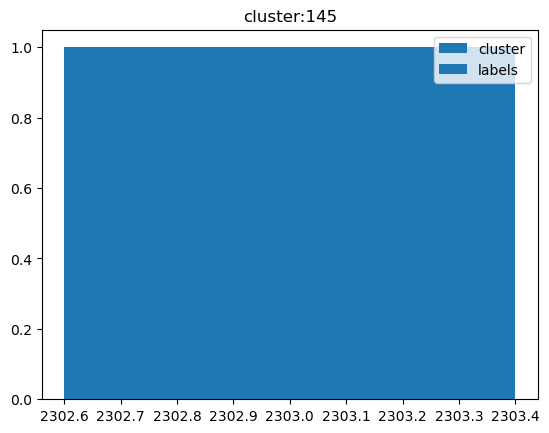

   0,     1, 0.0


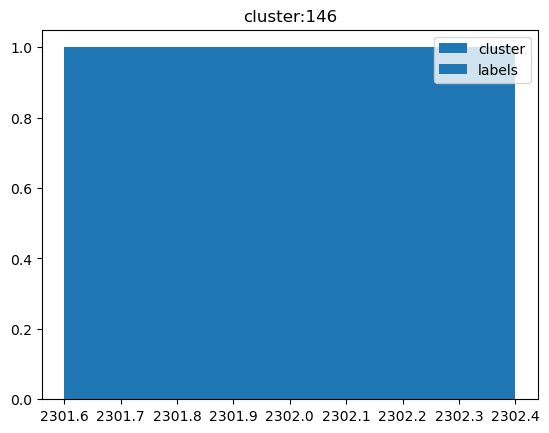

   0,     1, 0.0


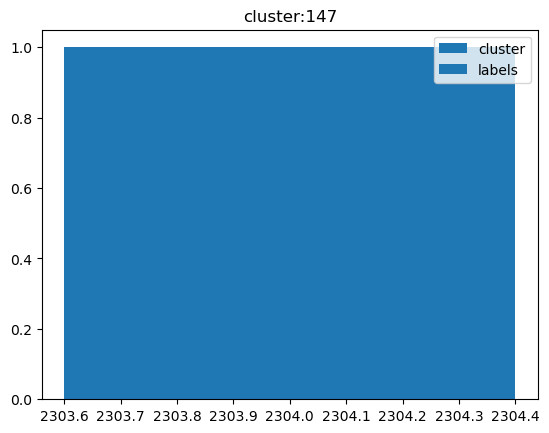

   0,     1, 0.0


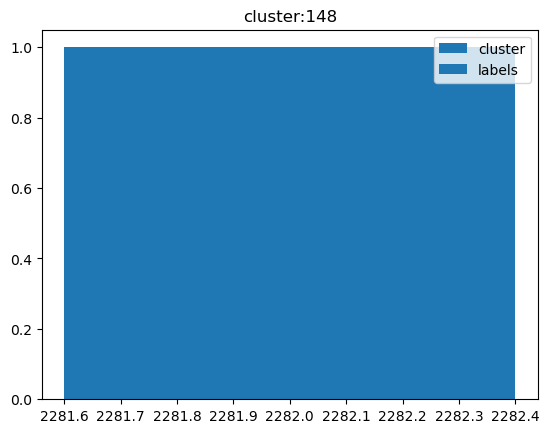

   0,     1, 0.0


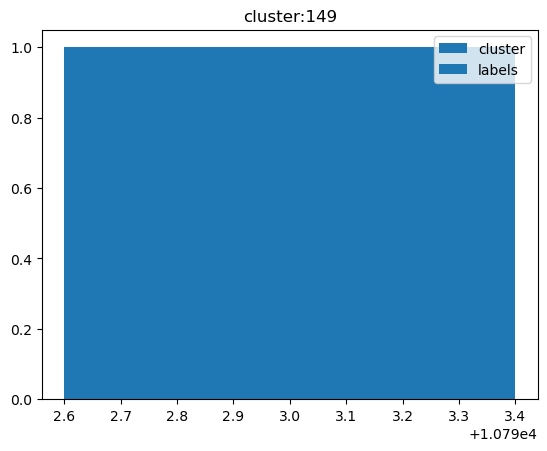

   0,     1, 0.0


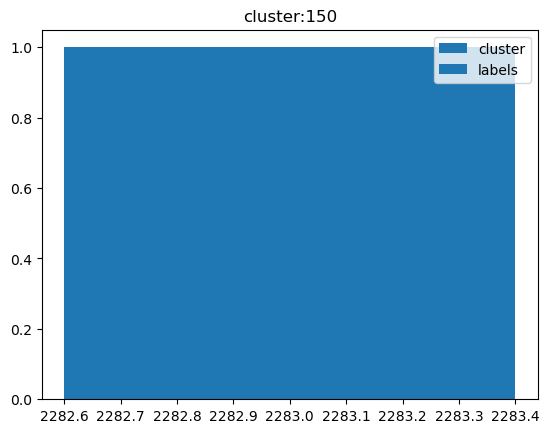

   0,     1, 0.0


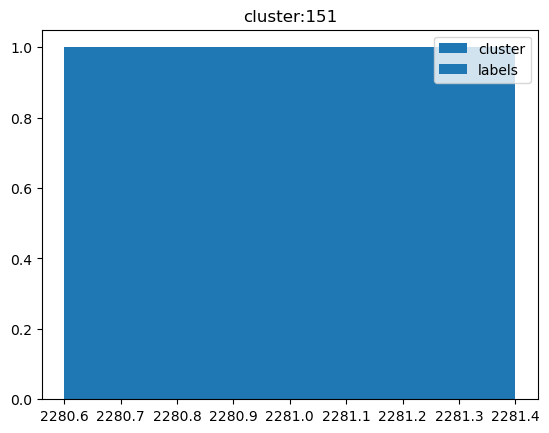

   0,     1, 0.0


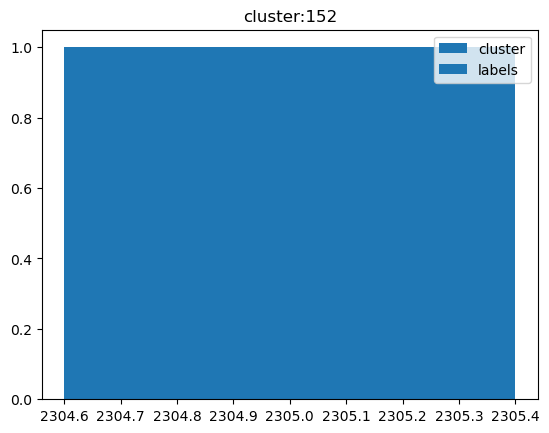

   0,     1, 0.0


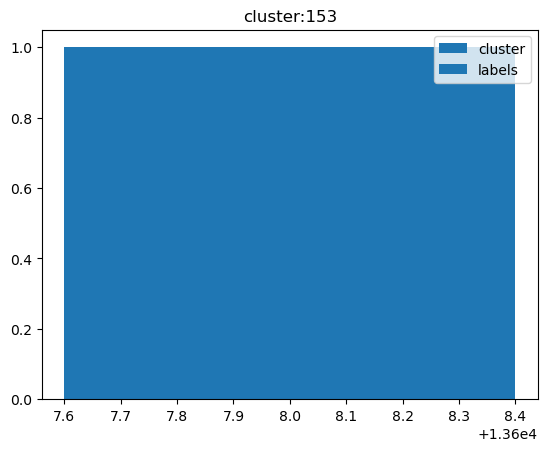

   1,     1, 100.0


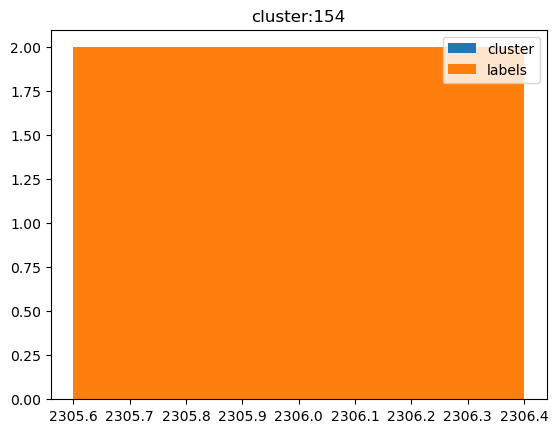

   0,     1, 0.0


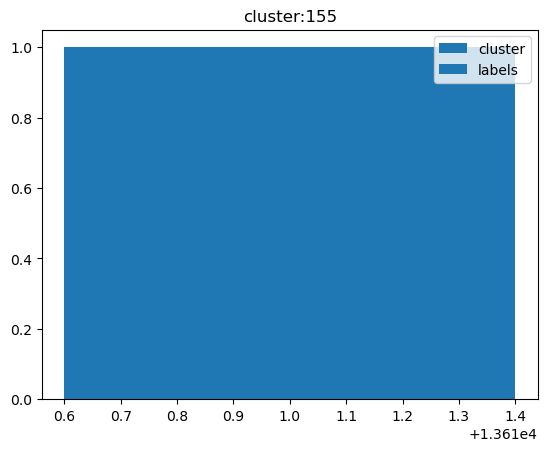

   0,     1, 0.0


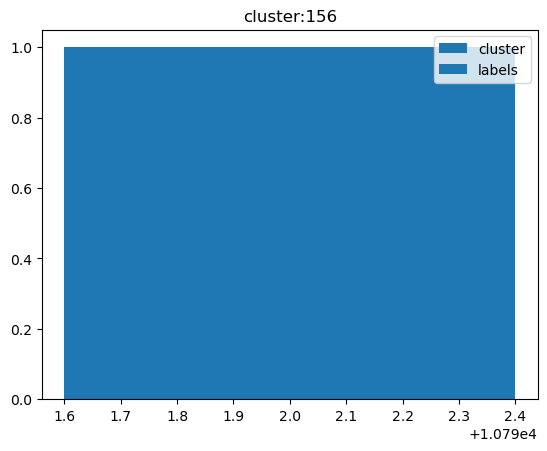

   0,     1, 0.0


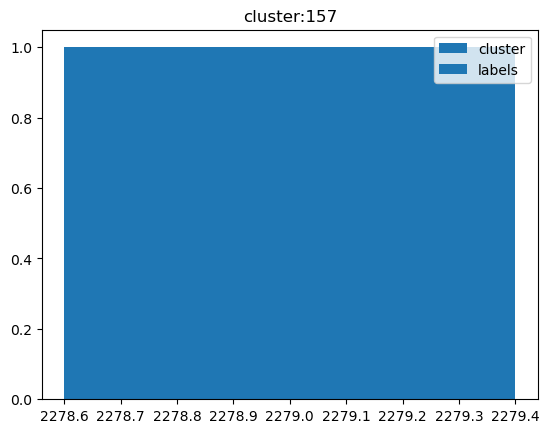

   0,     1, 0.0


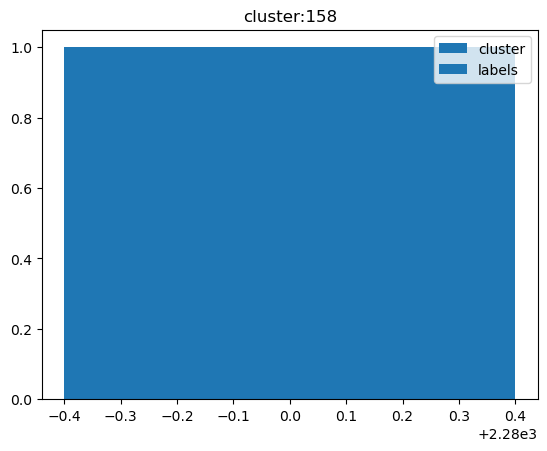

   0,     1, 0.0


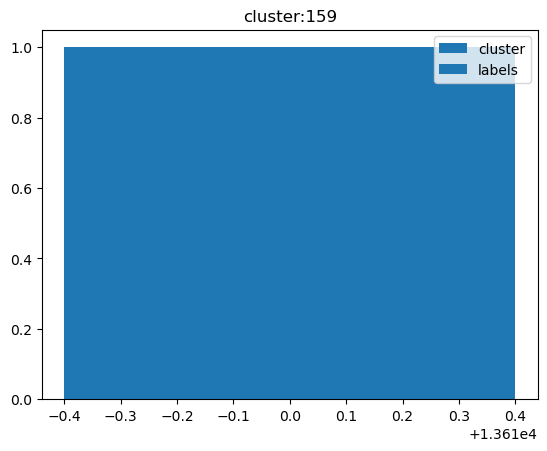

   0,     1, 0.0


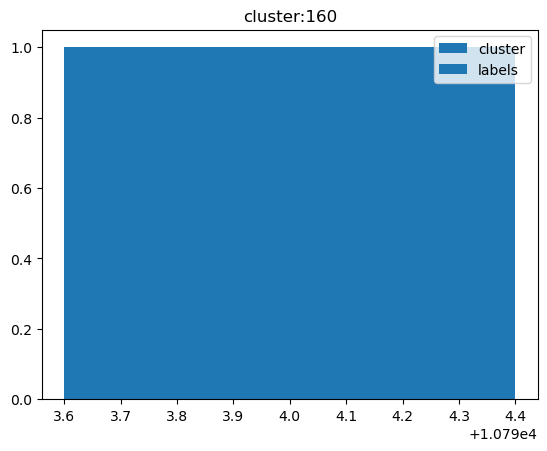

   0,     1, 0.0


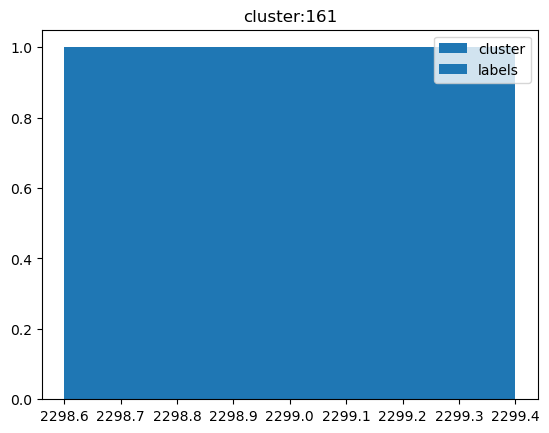

   0,     1, 0.0


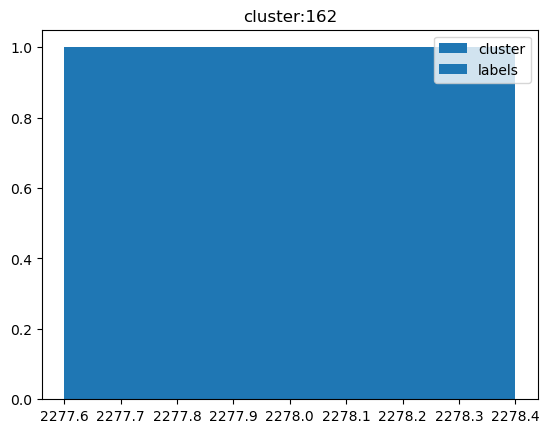

   0,     1, 0.0


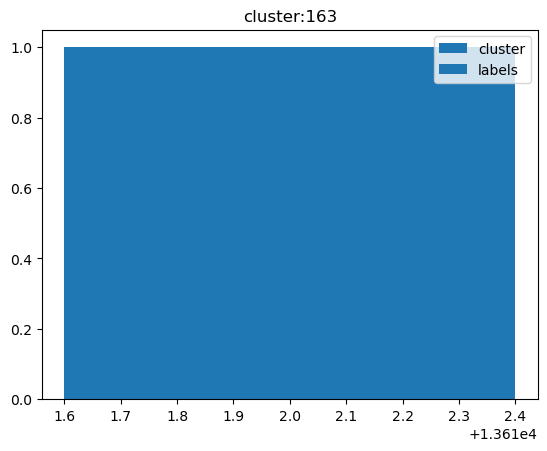

   0,     1, 0.0


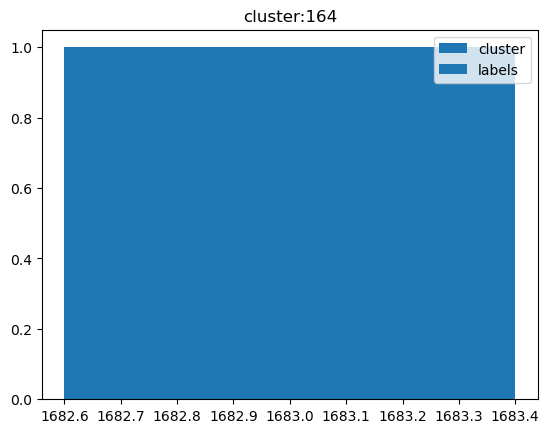

   0,     1, 0.0


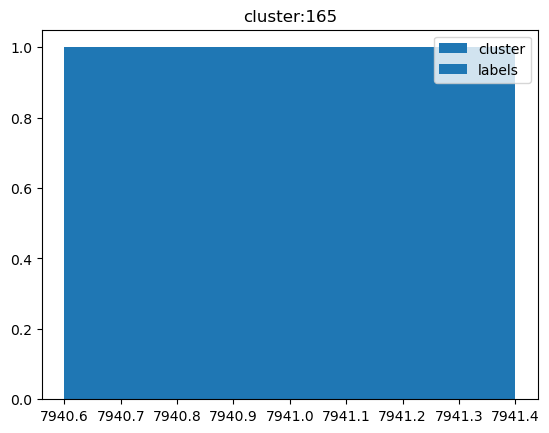

   0,     1, 0.0


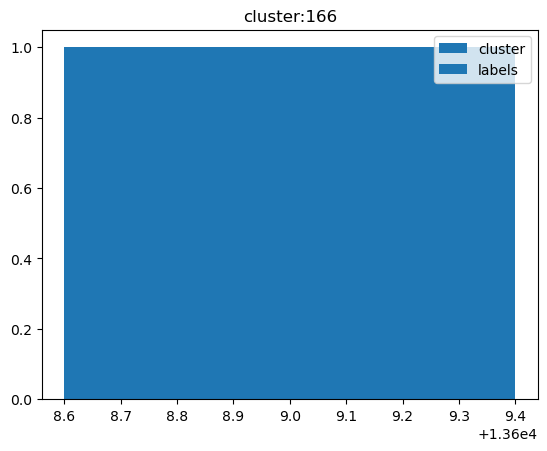

   0,     1, 0.0


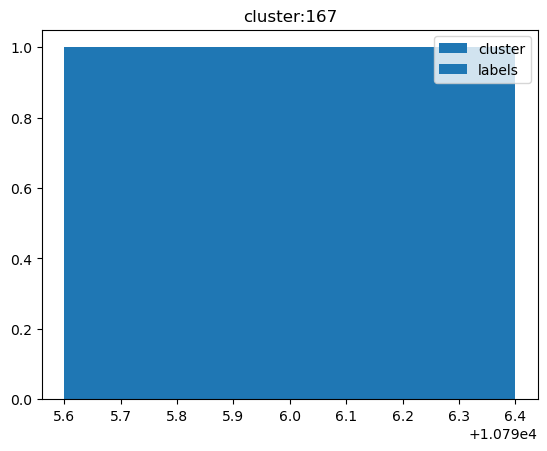

   0,     1, 0.0


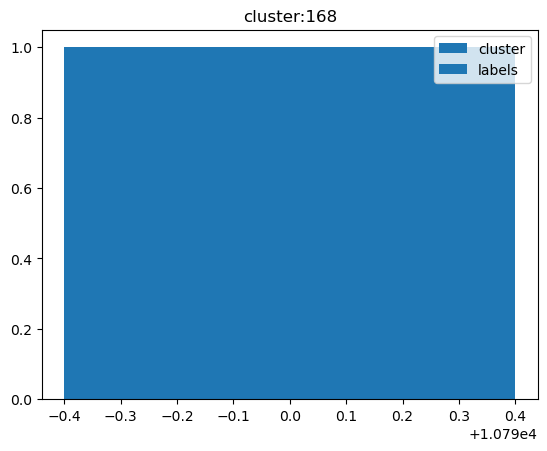

   0,     1, 0.0


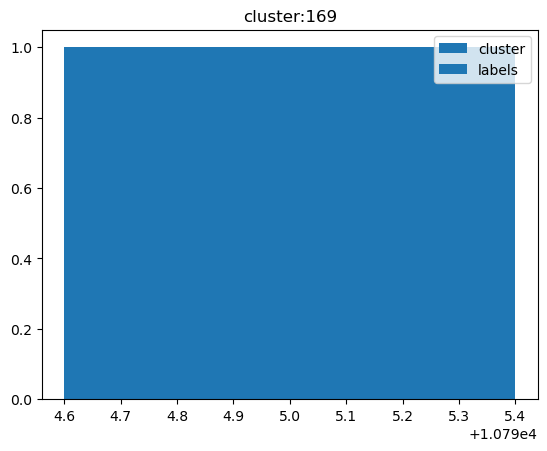

   0,     1, 0.0


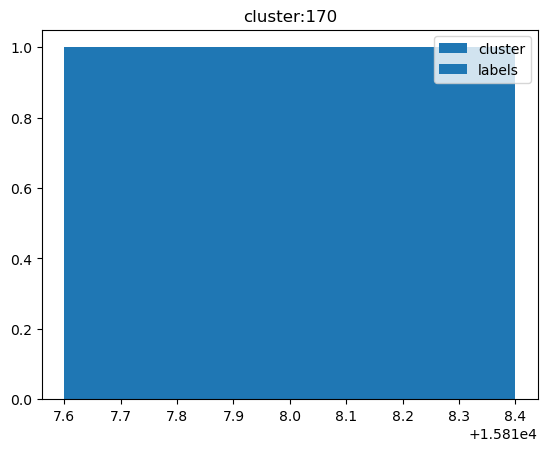

   0,     1, 0.0


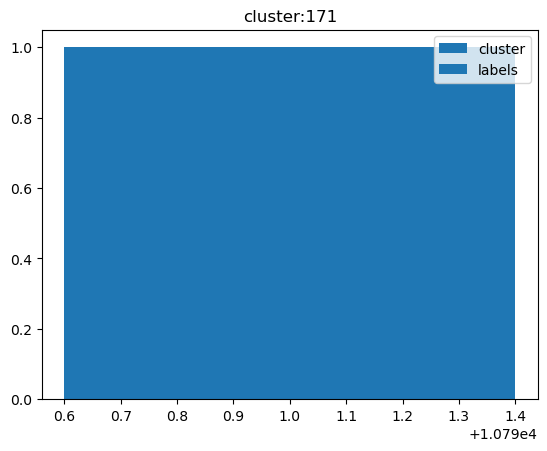

   0,     1, 0.0


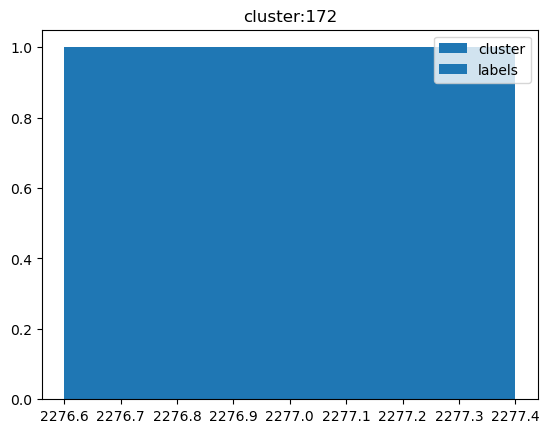

   0,     1, 0.0


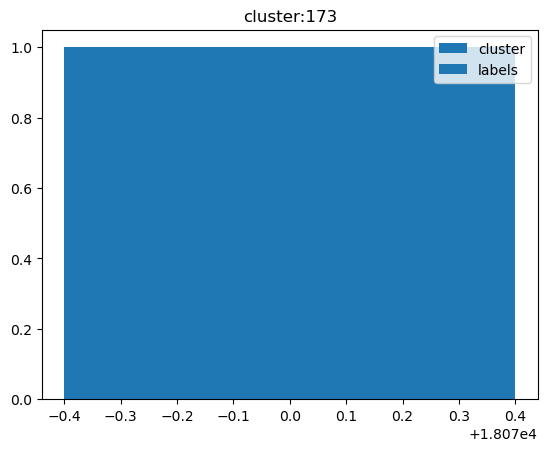

   0,     1, 0.0


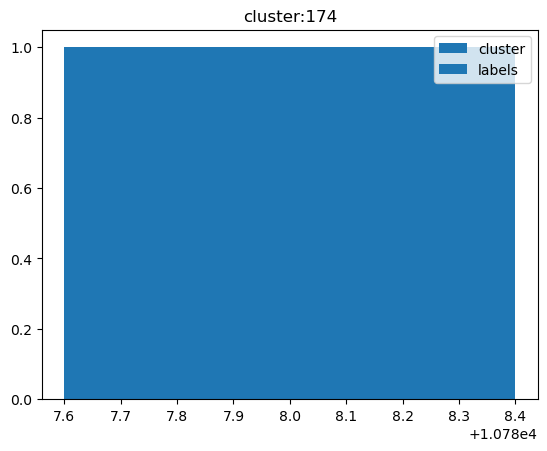

   0,     1, 0.0


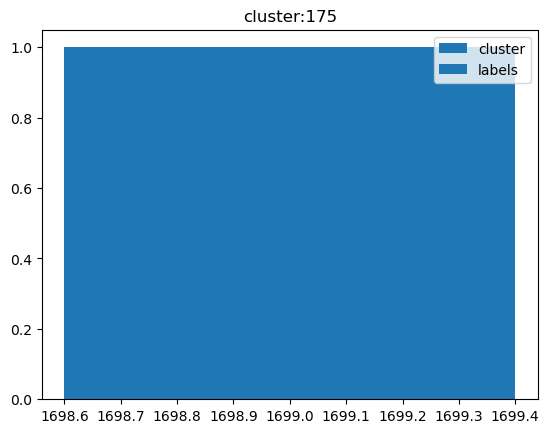

   0,     1, 0.0


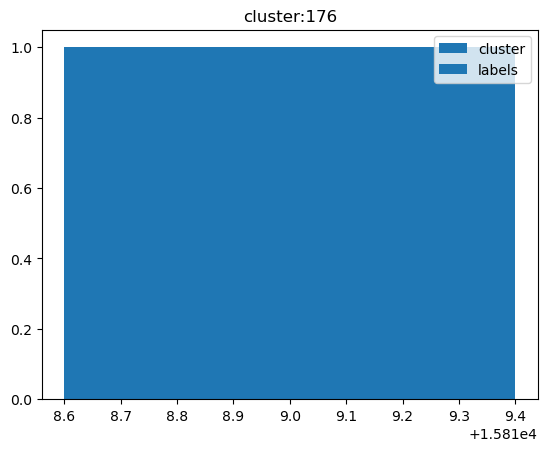

   0,     1, 0.0


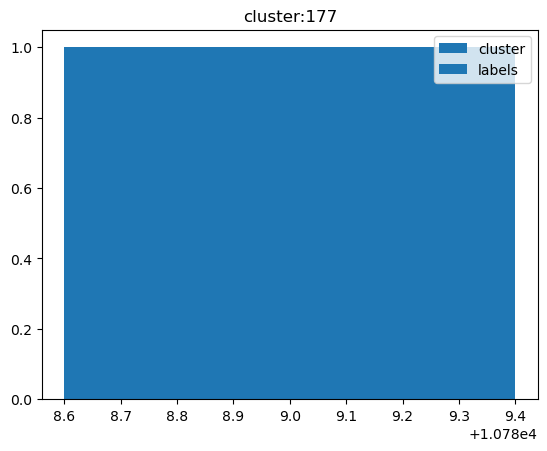

   0,     1, 0.0


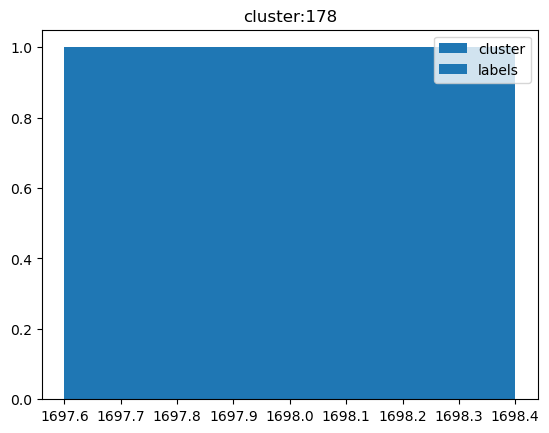

   0,     1, 0.0


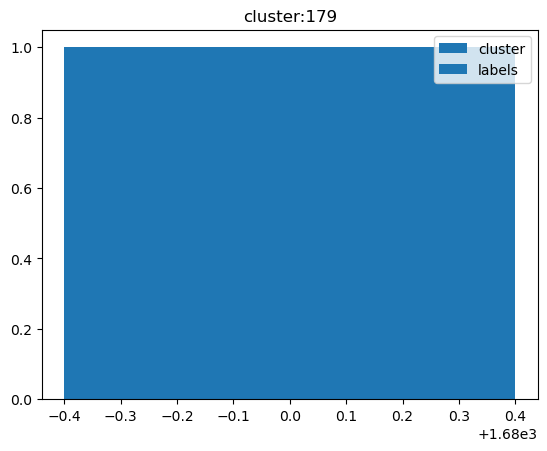

   0,     1, 0.0


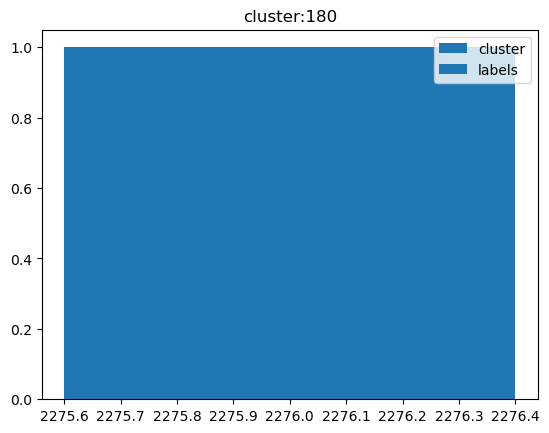

   0,     1, 0.0


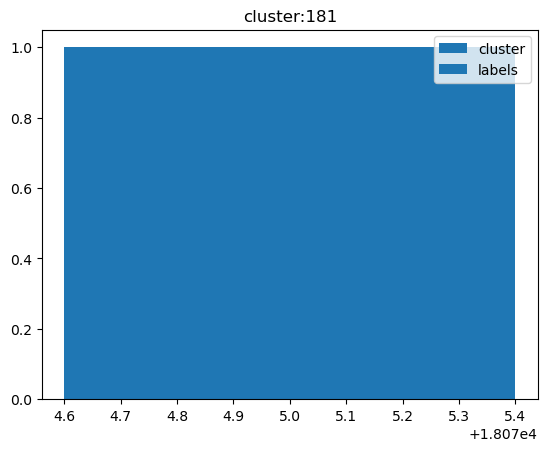

   0,     1, 0.0


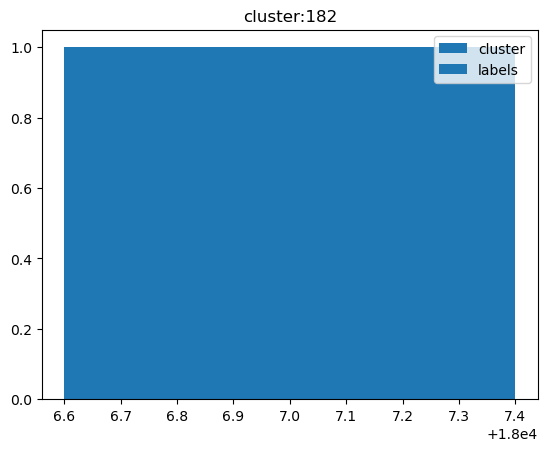

   1,     2, 50.0


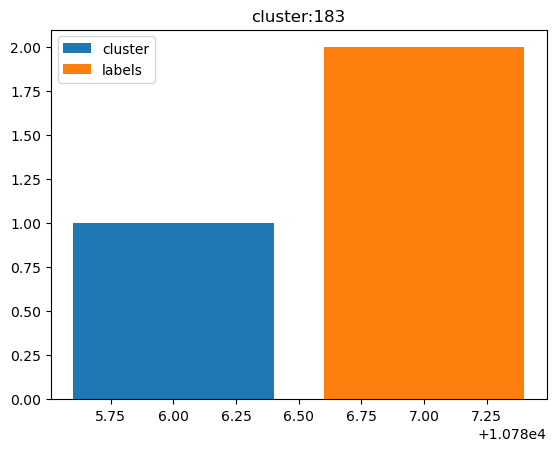

   0,     1, 0.0


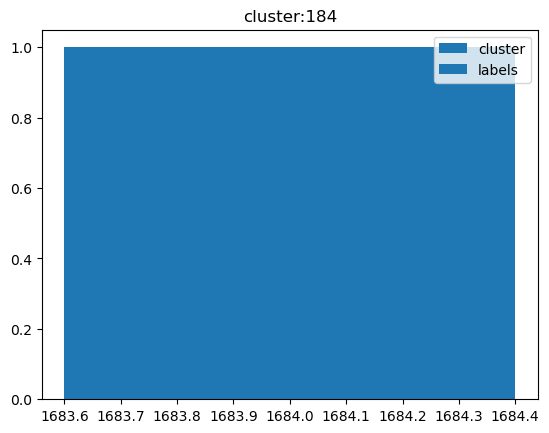

   0,     1, 0.0


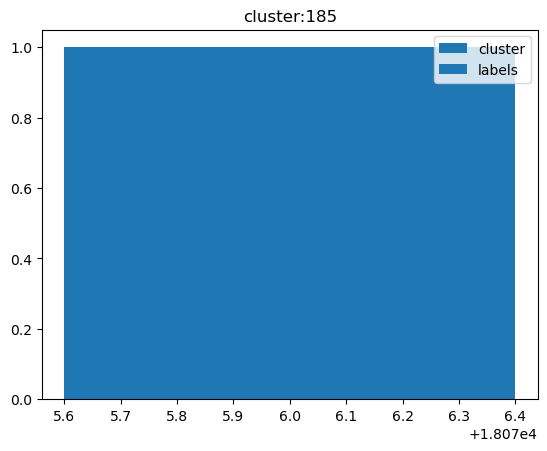

   0,     1, 0.0


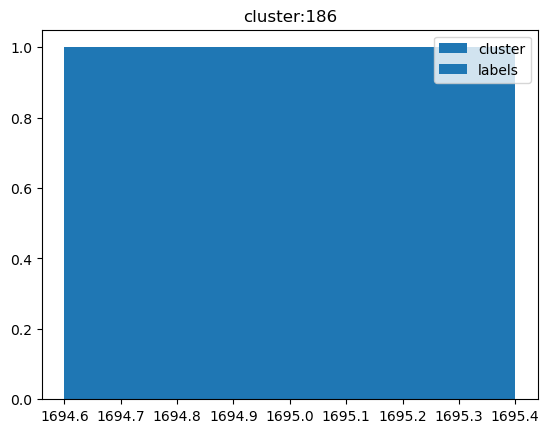

   0,     1, 0.0


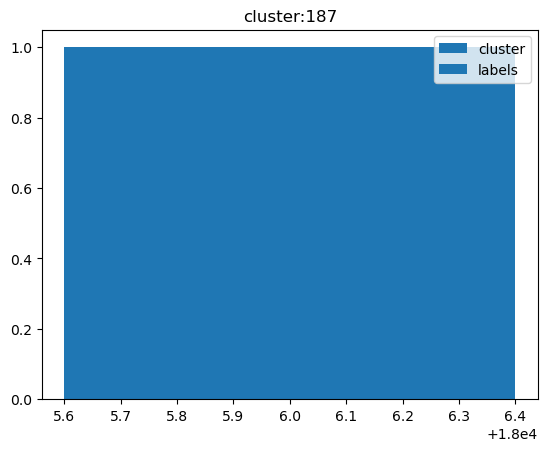

   0,     1, 0.0


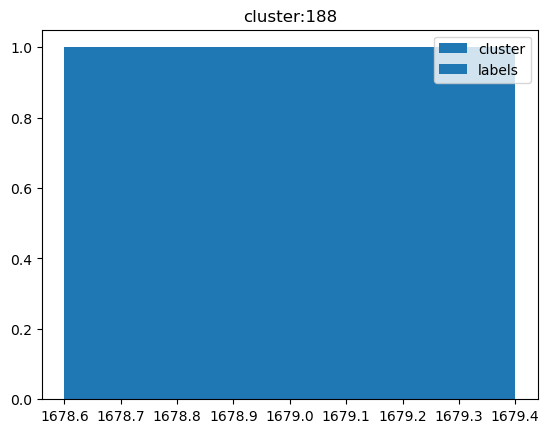

   0,     1, 0.0


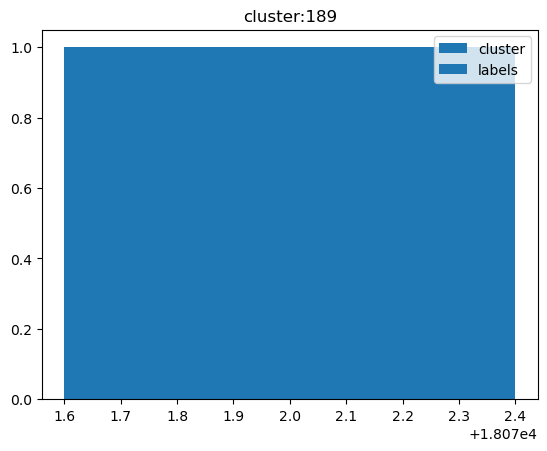

   0,     1, 0.0


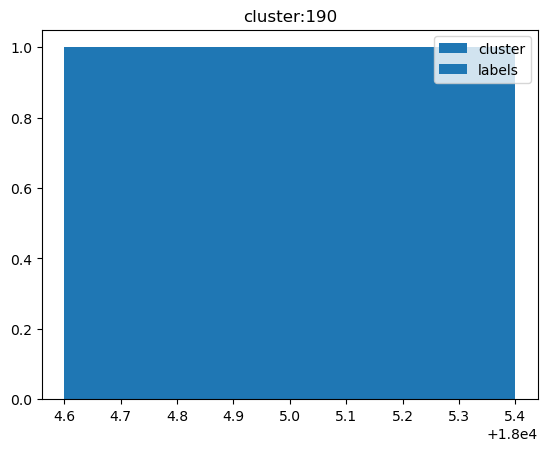

   0,     1, 0.0


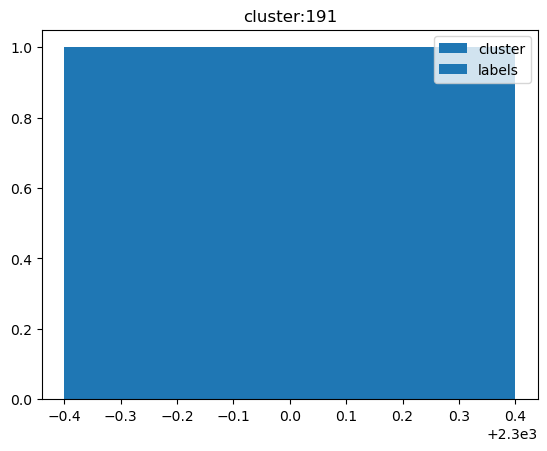

   0,     1, 0.0


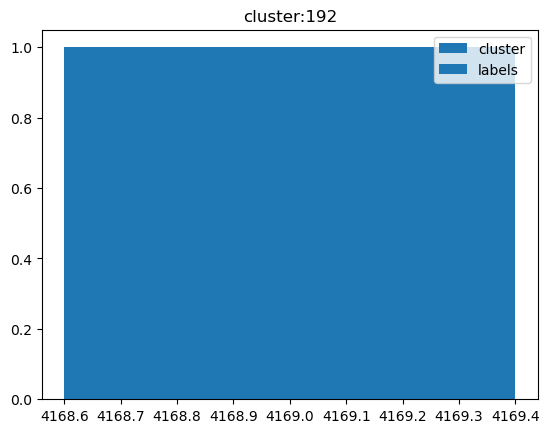

   0,     1, 0.0


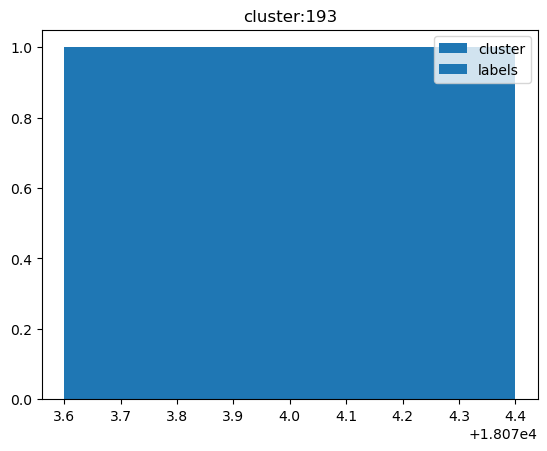

   0,     1, 0.0


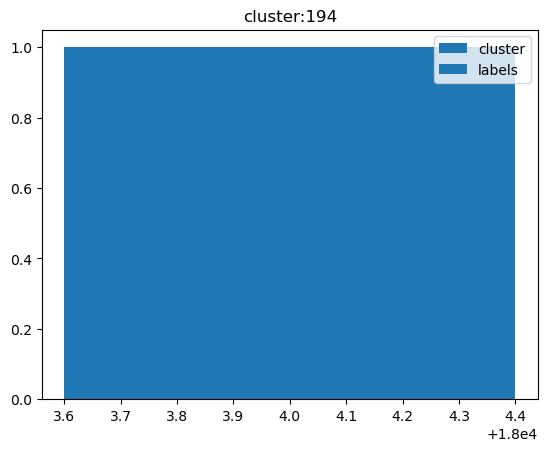

   0,     1, 0.0


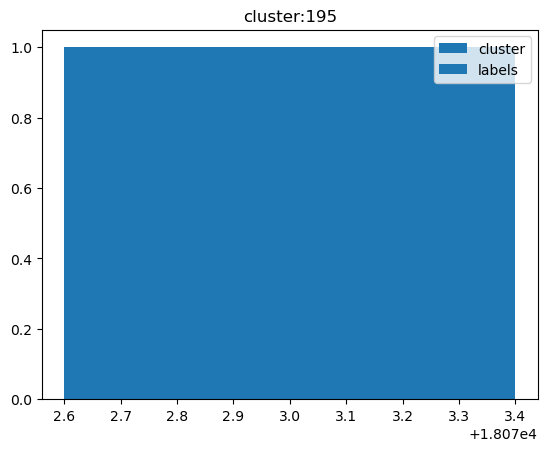

   0,     1, 0.0


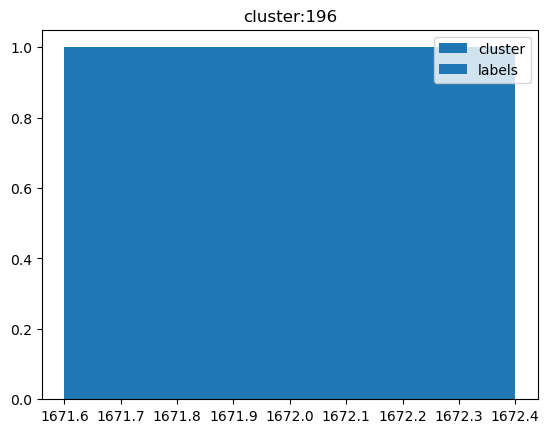

   0,     1, 0.0


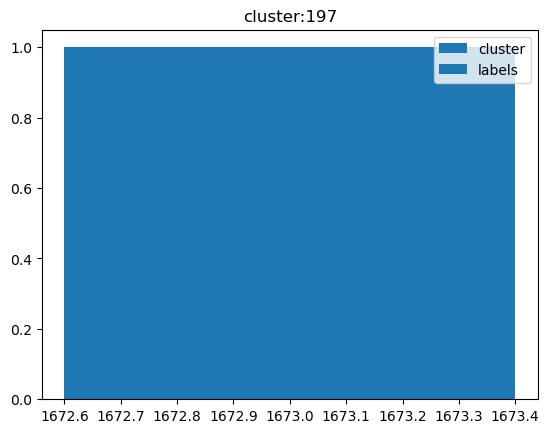

   0,     1, 0.0


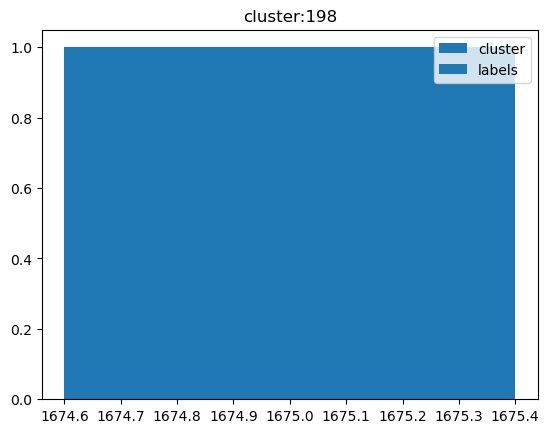

   0,     1, 0.0


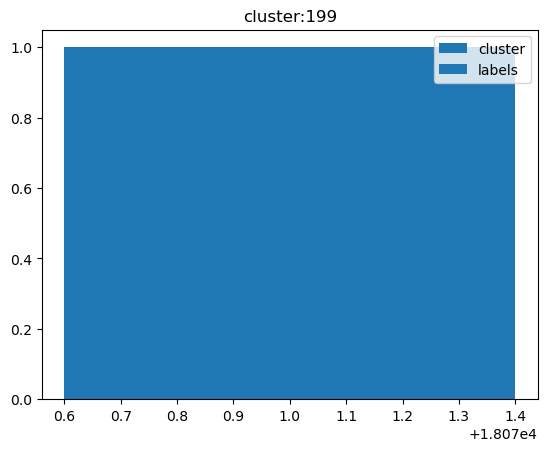

   0,     1, 0.0


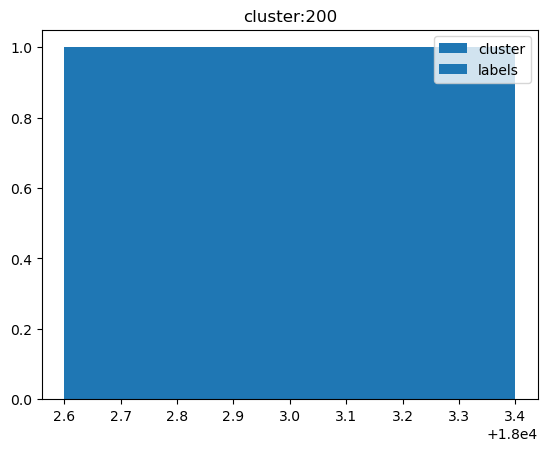

   1,     1, 100.0


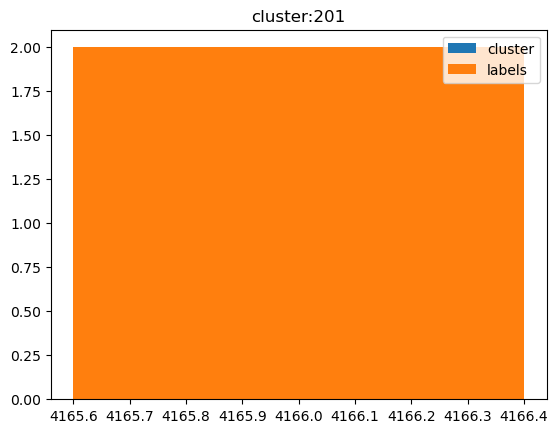

   0,     1, 0.0


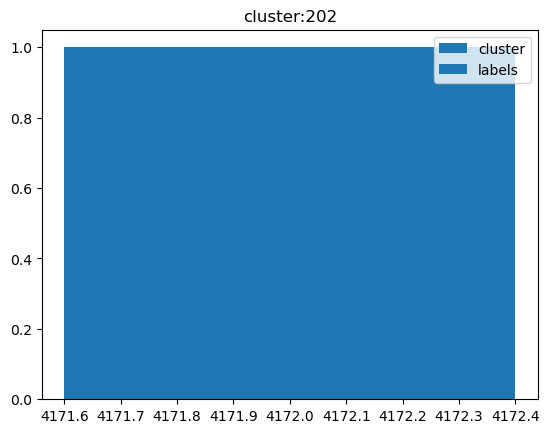

   0,     1, 0.0


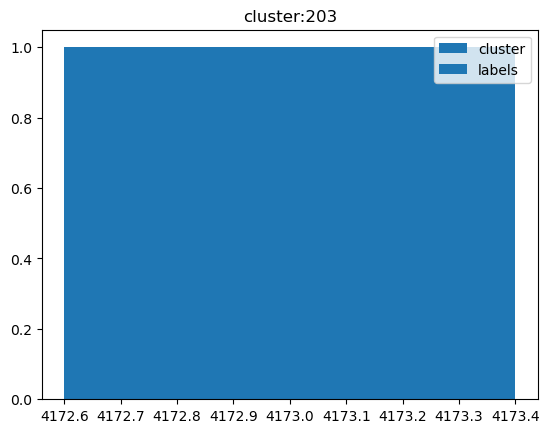

   0,     1, 0.0


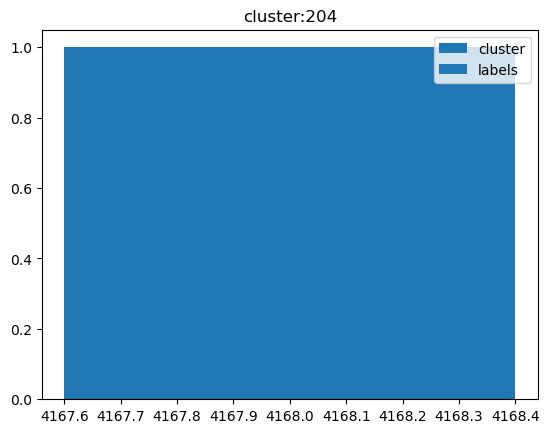

   0,     1, 0.0


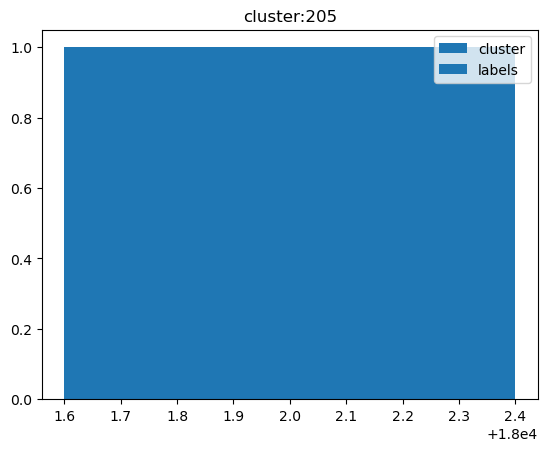

   0,     1, 0.0


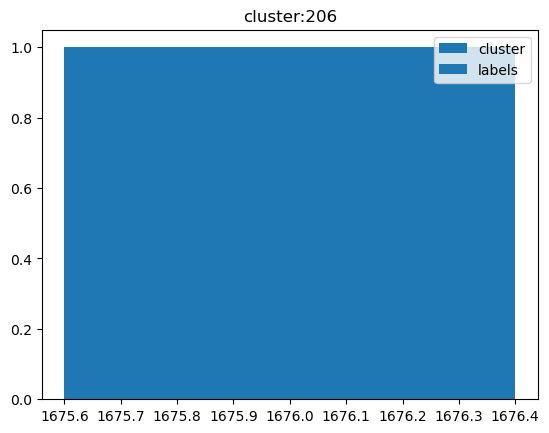

   0,     1, 0.0


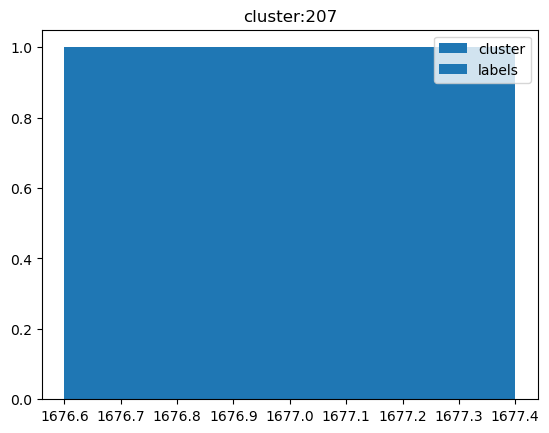

   0,     1, 0.0


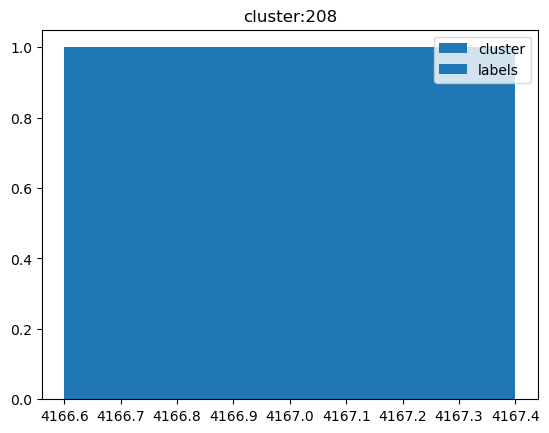

   0,     1, 0.0


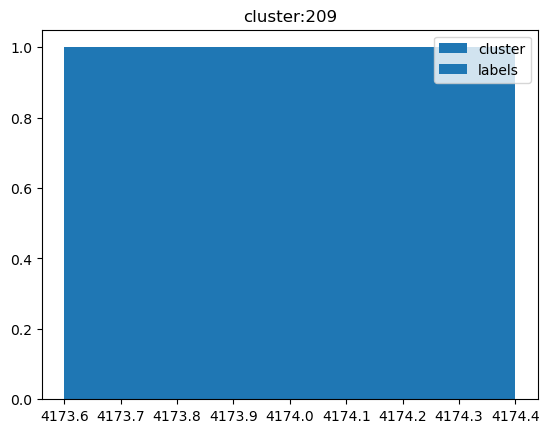

   0,     1, 0.0


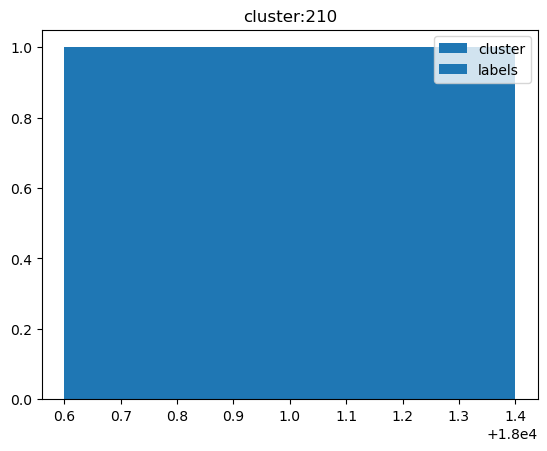

   0,     1, 0.0


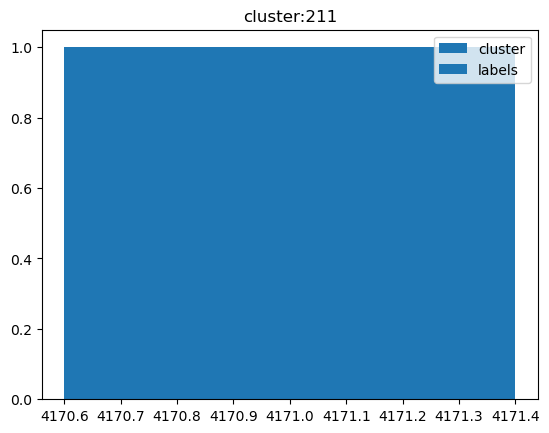

   1,     1, 100.0


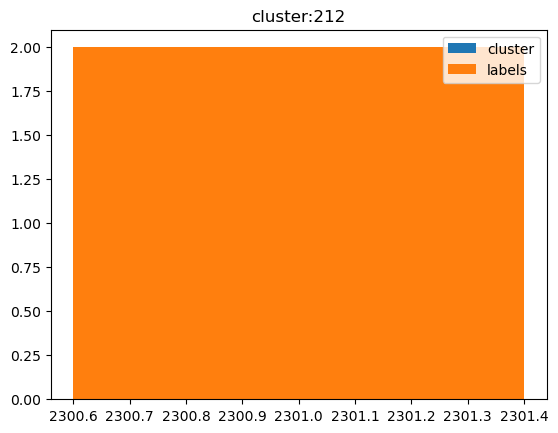

   0,     1, 0.0


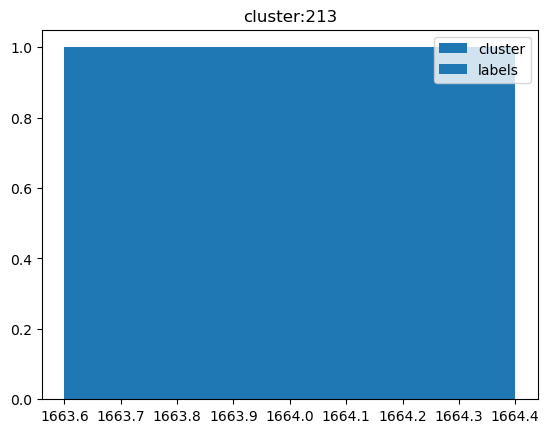

   0,     1, 0.0


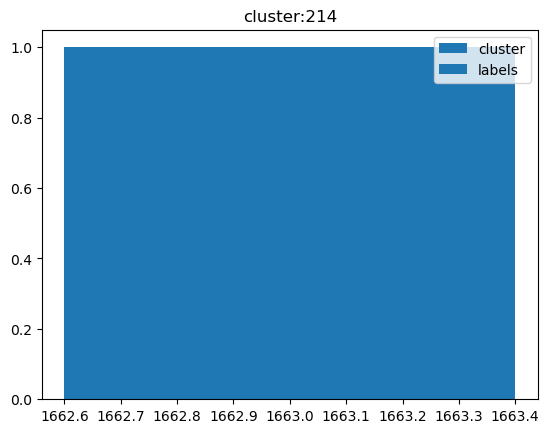

   0,     1, 0.0


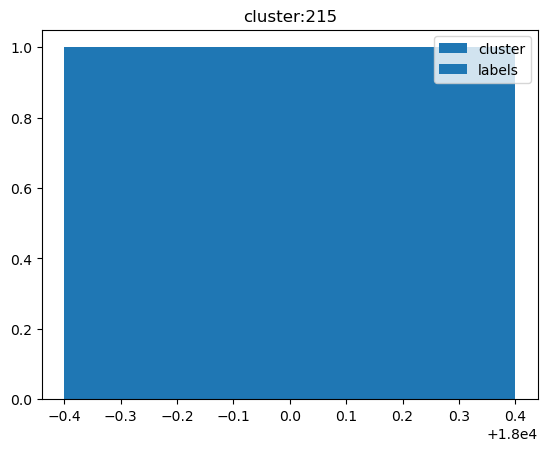

   0,     1, 0.0


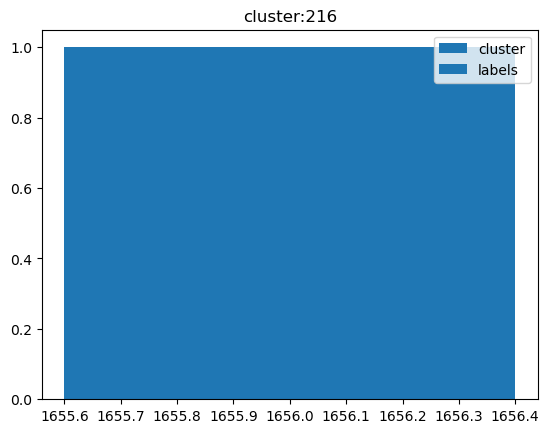

   0,     1, 0.0


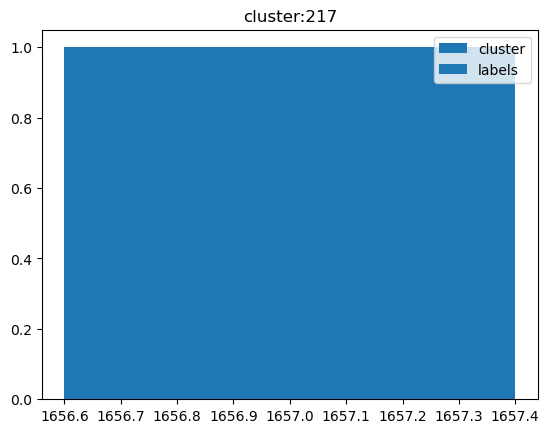

   0,     1, 0.0


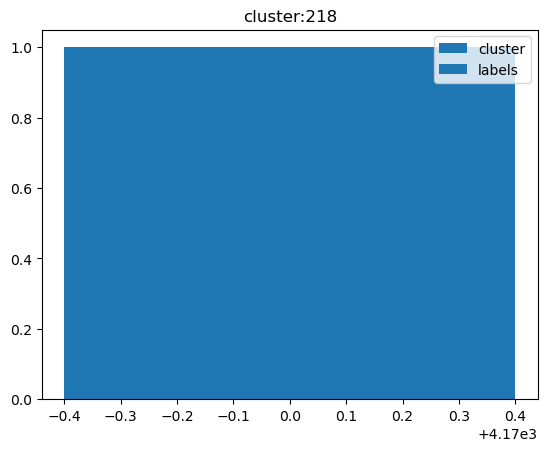

   0,     1, 0.0


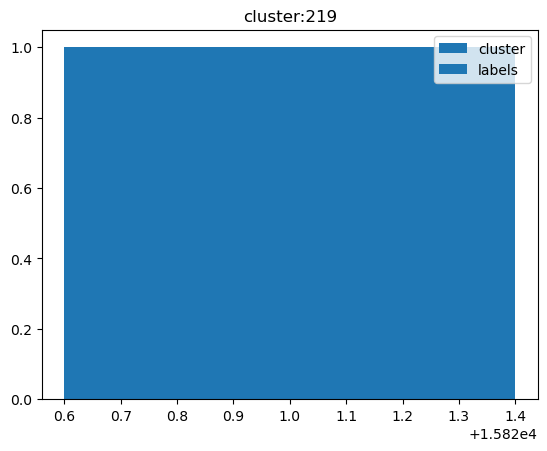

   0,     1, 0.0


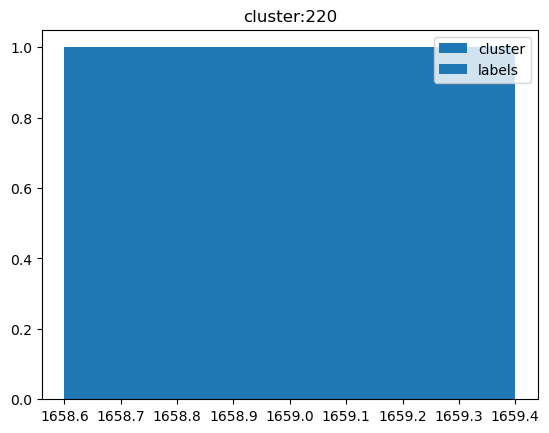

   0,     1, 0.0


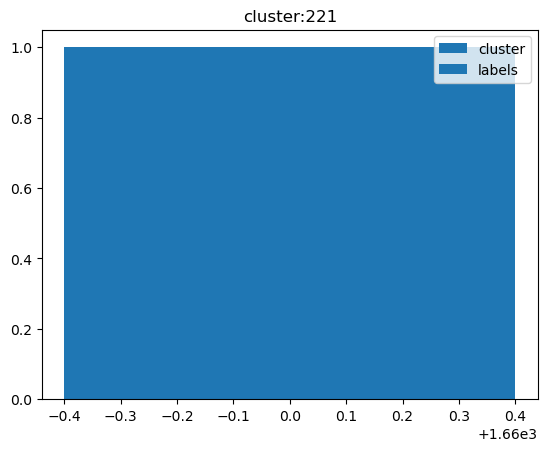

   0,     1, 0.0


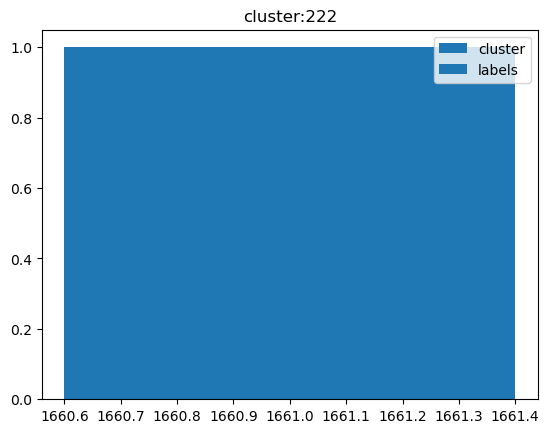

   0,     1, 0.0


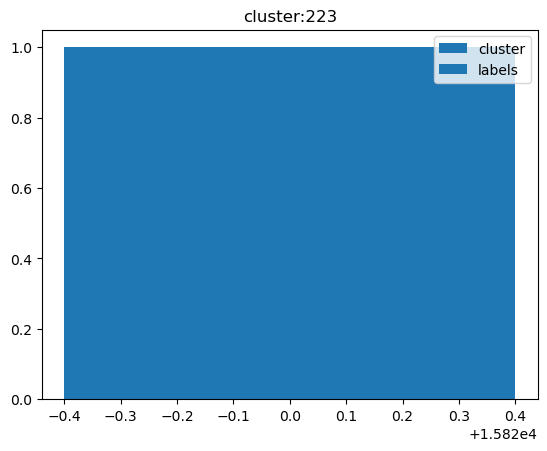

   0,     1, 0.0


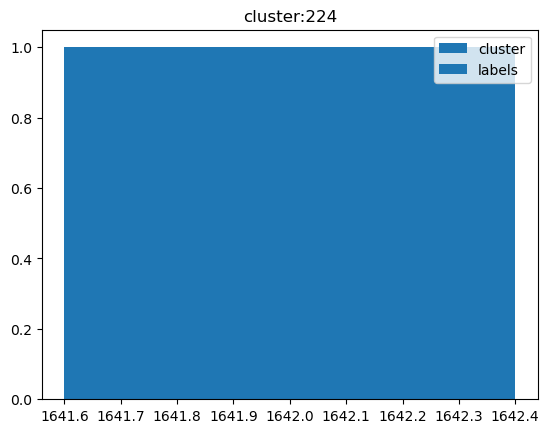

   0,     1, 0.0


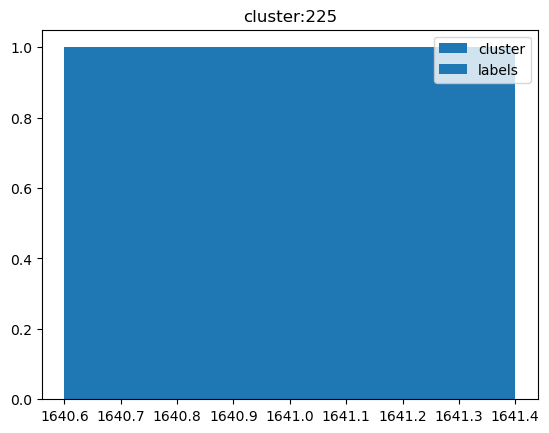

   0,     1, 0.0


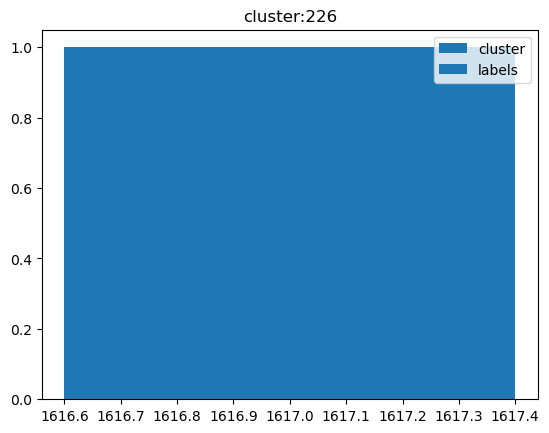

   0,     1, 0.0


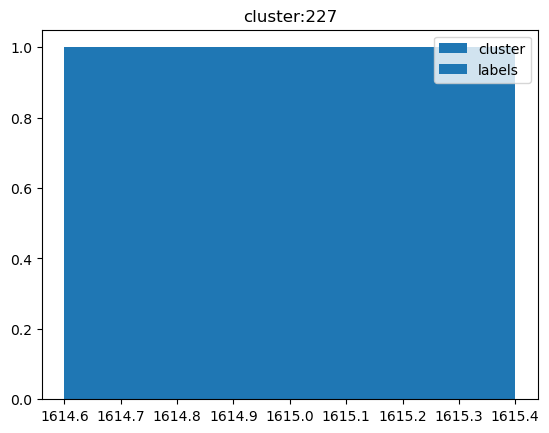

   0,     1, 0.0


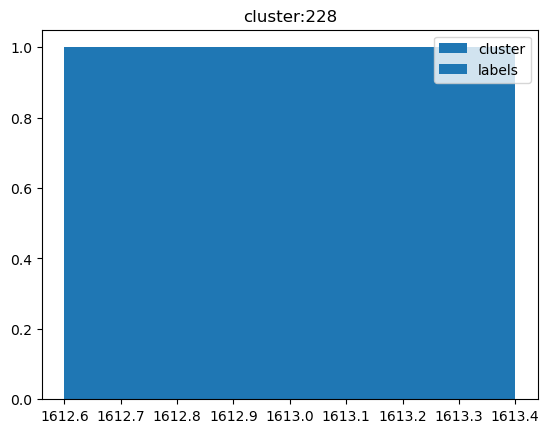

   0,     1, 0.0


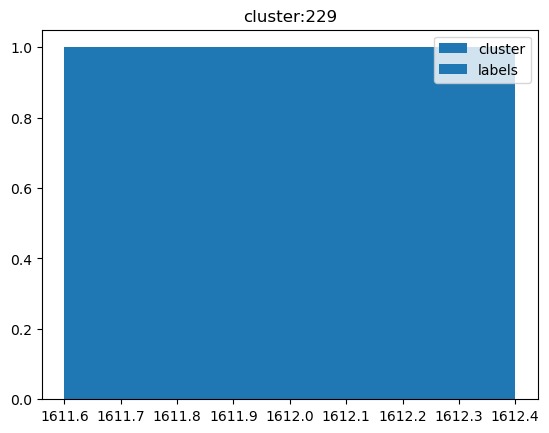

   0,     1, 0.0


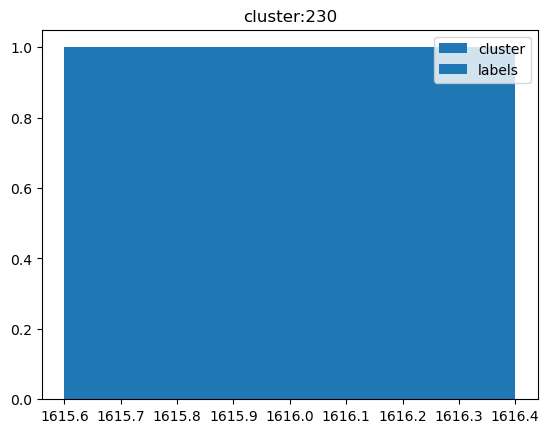

   0,     1, 0.0


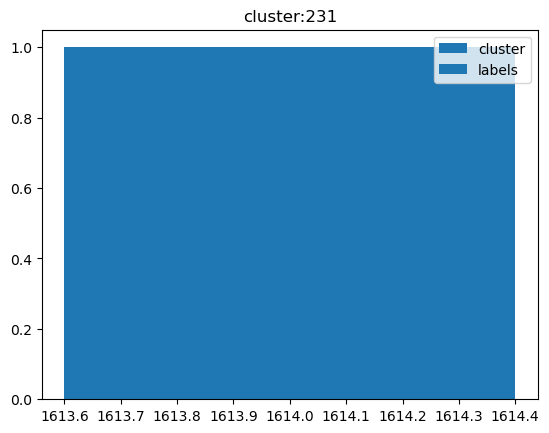

   0,     9, 0.0


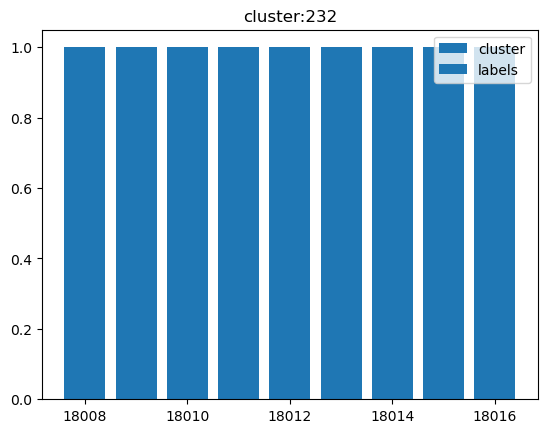

   0,     1, 0.0


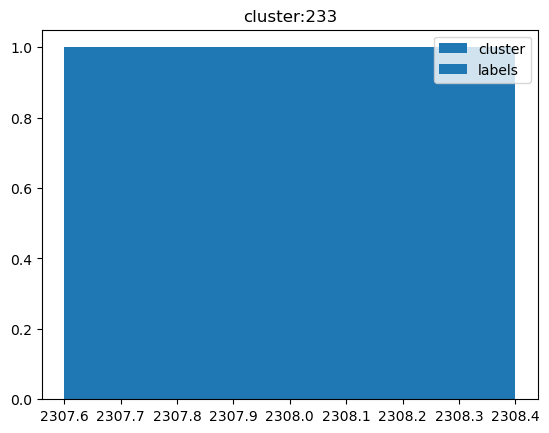

   0,     1, 0.0


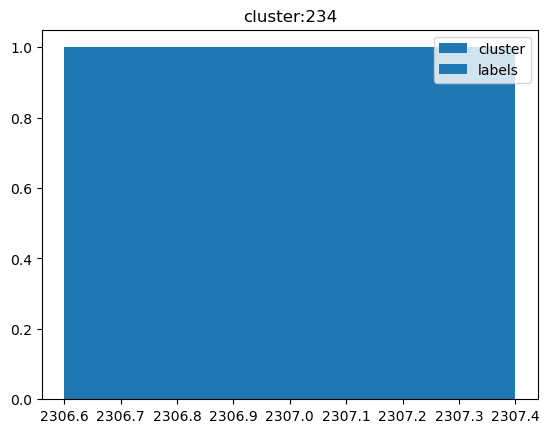

   0,     1, 0.0


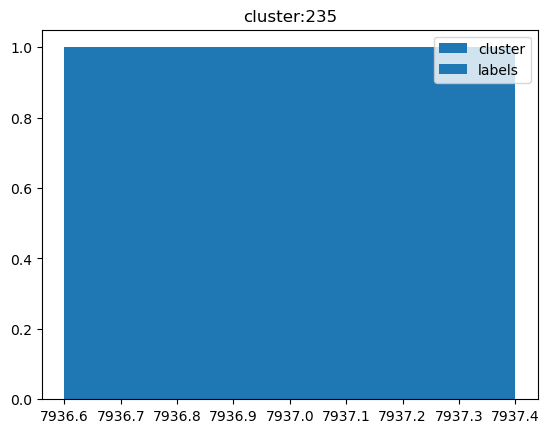

   0,     1, 0.0


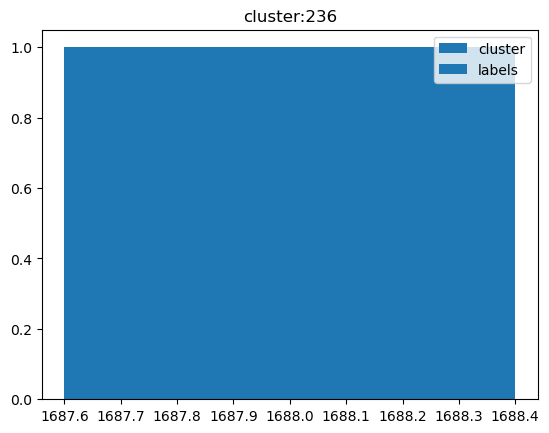

   0,     2, 0.0


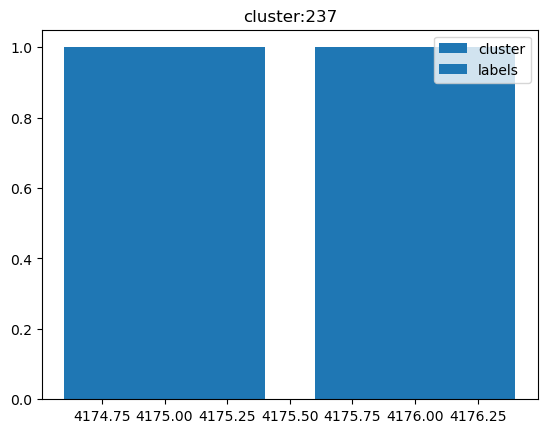

   0,     1, 0.0


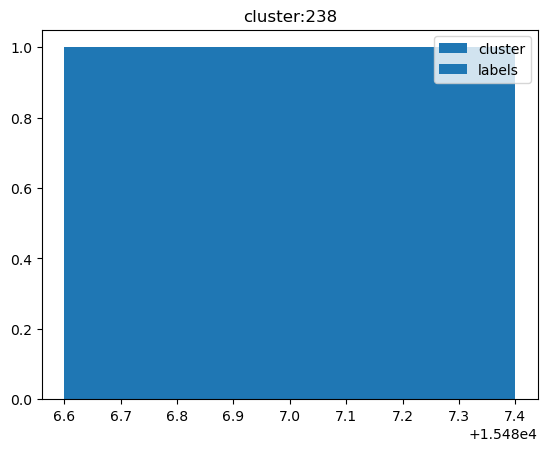

   0,     1, 0.0


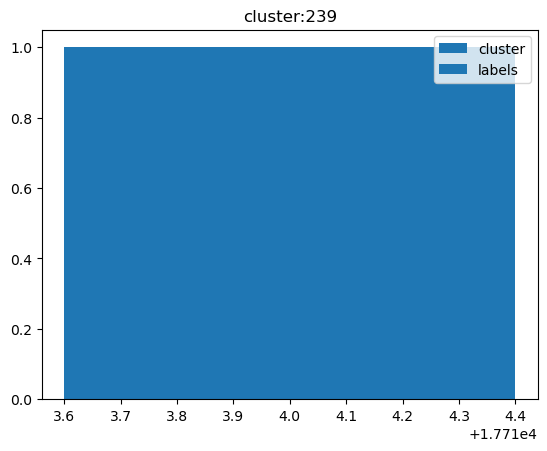

   0,     2, 0.0


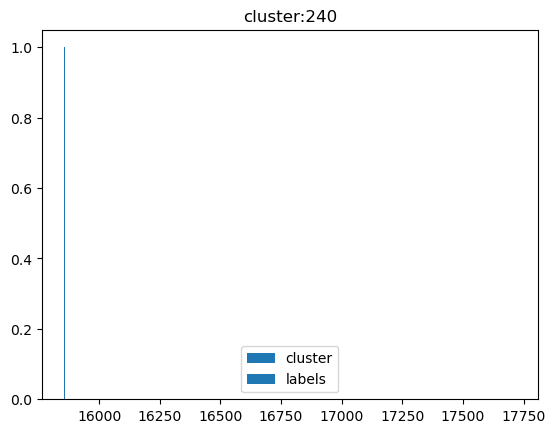

   0,     1, 0.0


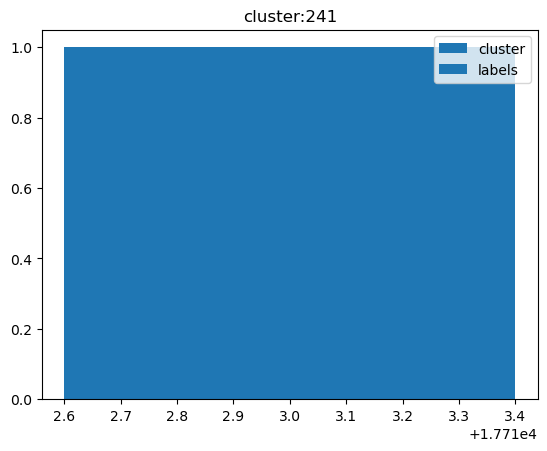

   0,     2, 0.0


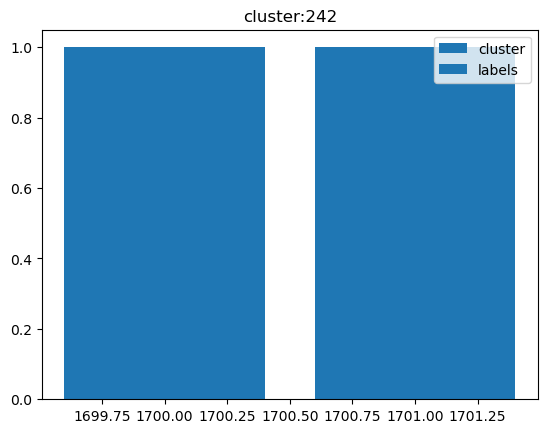

   0,     1, 0.0


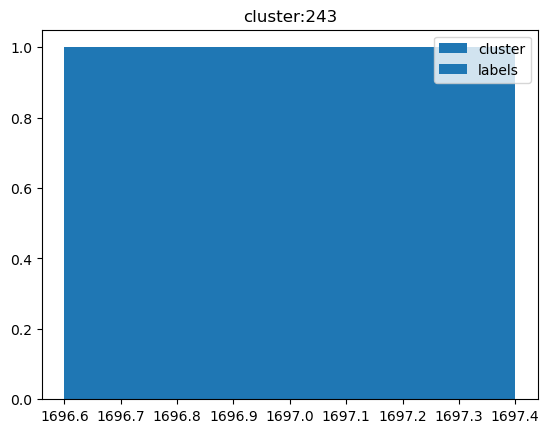

   0,     1, 0.0


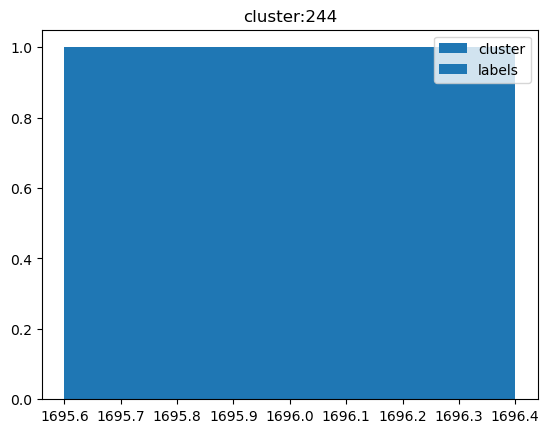

   0,     1, 0.0


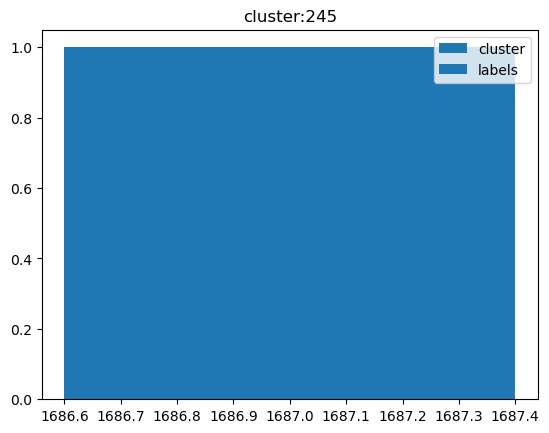

   0,     1, 0.0


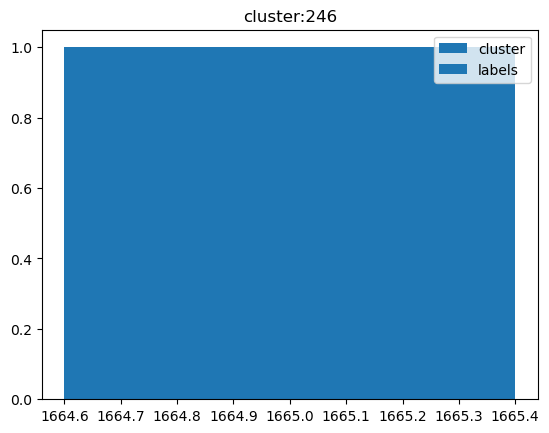

   0,     1, 0.0


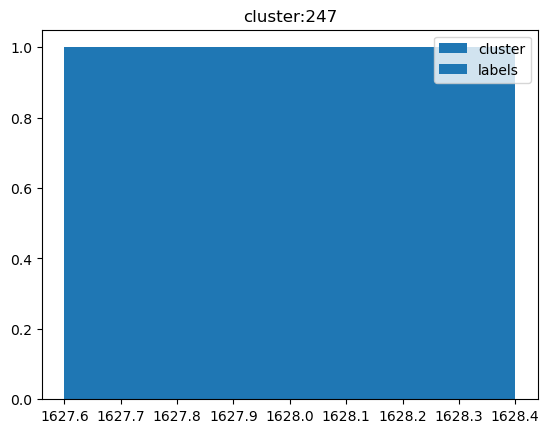

   0,     1, 0.0


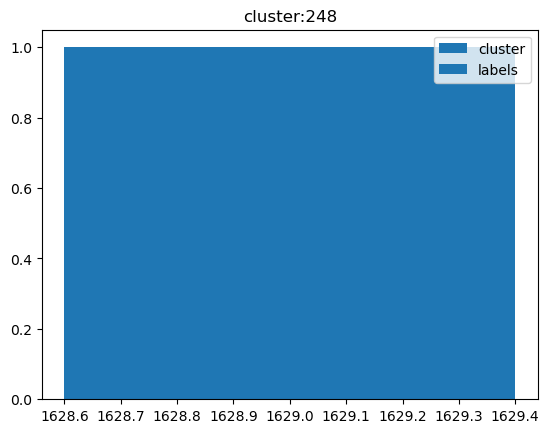

   0,     1, 0.0


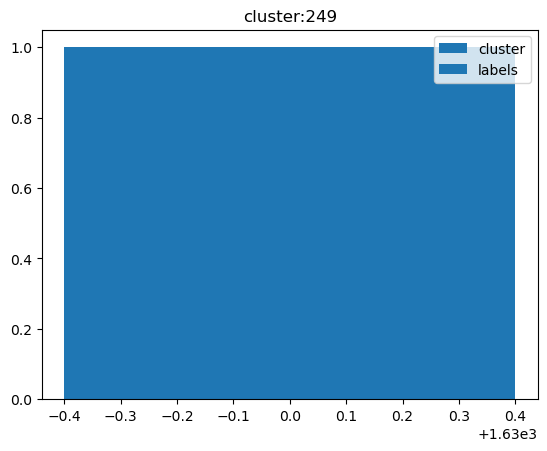

   0,     1, 0.0


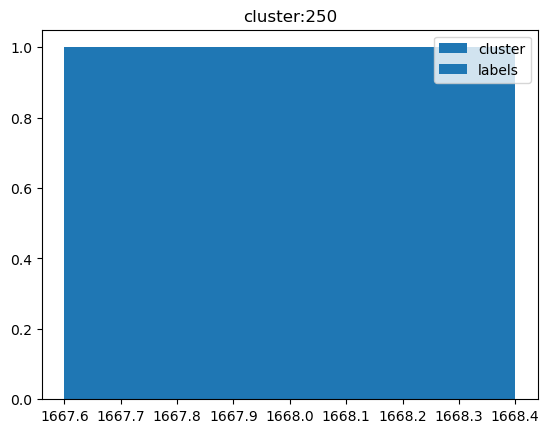

   0,     1, 0.0


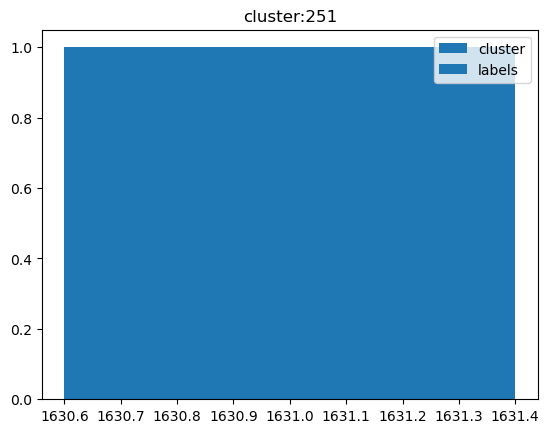

   0,     1, 0.0


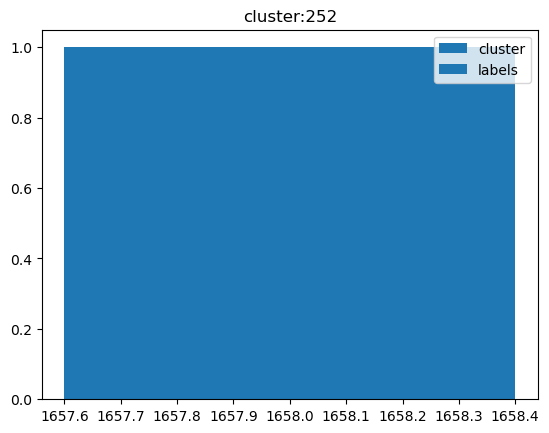

   0,     1, 0.0


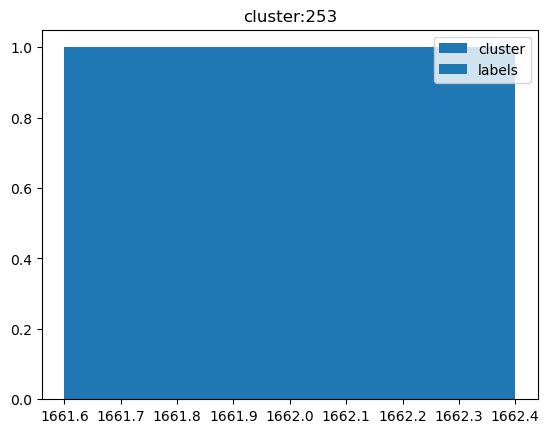

   0,     1, 0.0


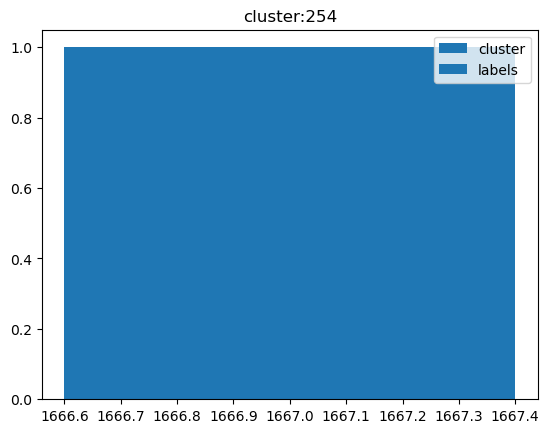

   0,     1, 0.0


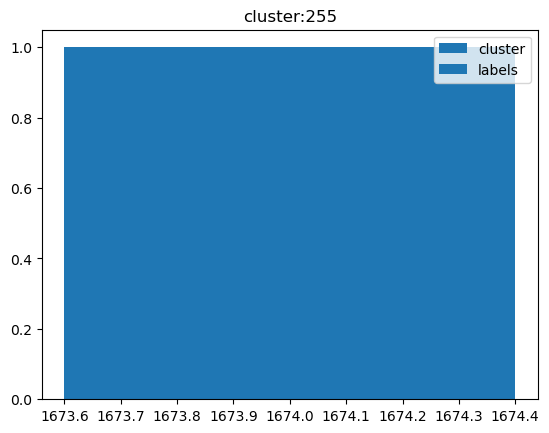

   0,     1, 0.0


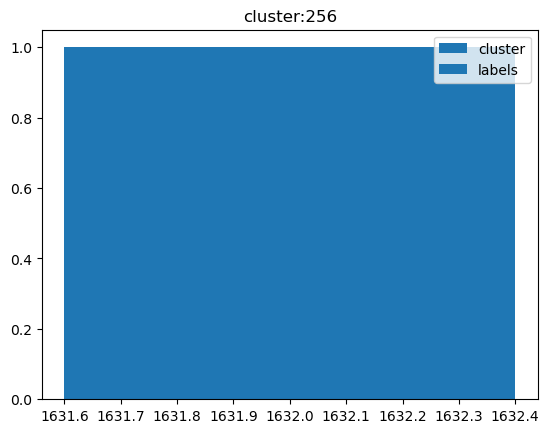

   0,     1, 0.0


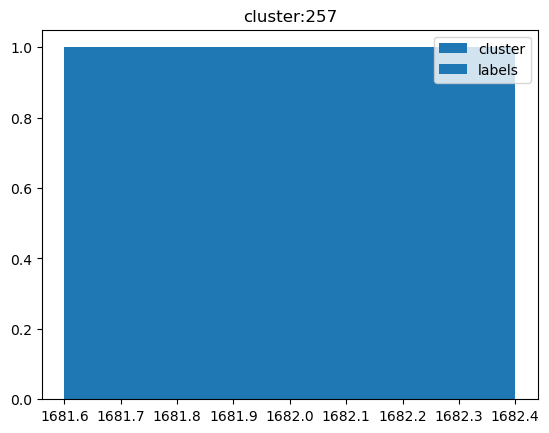

   0,     1, 0.0


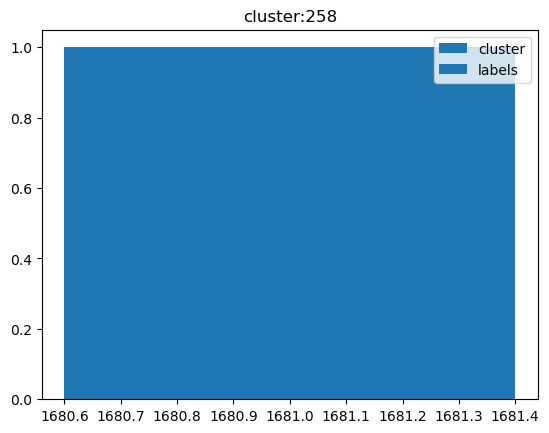

   0,     1, 0.0


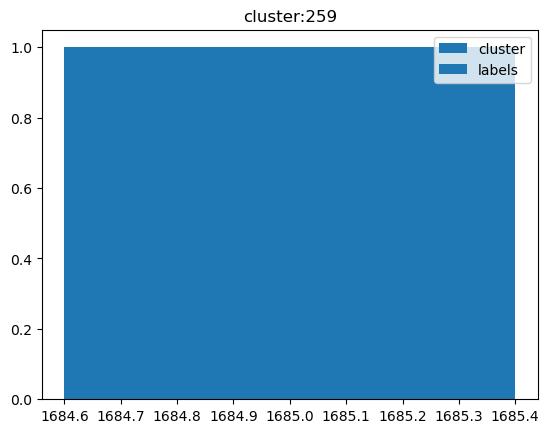

   0,     1, 0.0


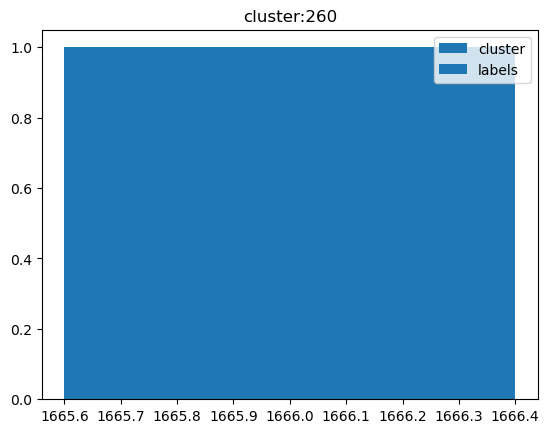

   0,     1, 0.0


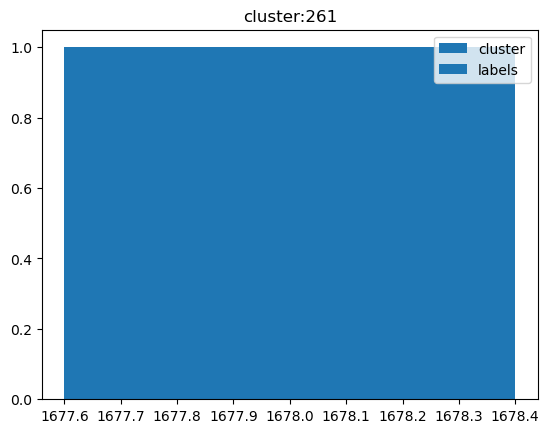

   0,     1, 0.0


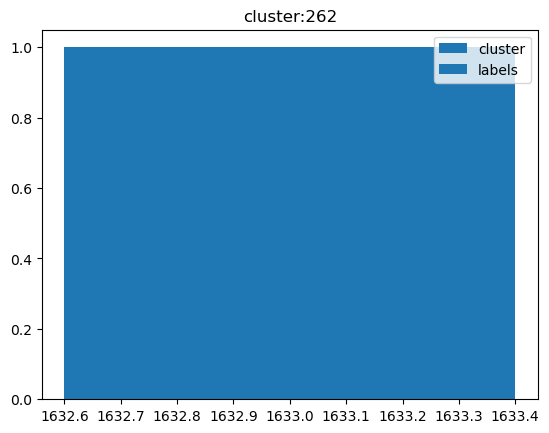

   0,     1, 0.0


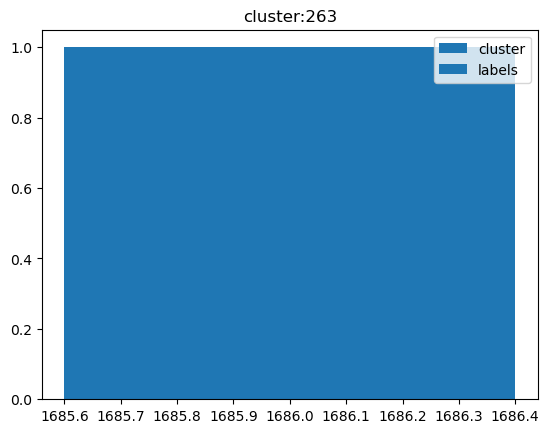

   0,     1, 0.0


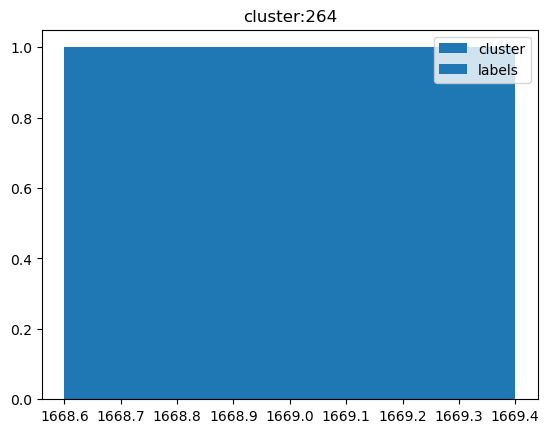

_____________


In [543]:
for cur_file in np.array(files)[mases_order][:1]:
    calc_misses(cur_file, labels, verbose=True)
    print("_____________")

In [544]:
len(np.where(a)[0])

17

<BarContainer object of 7 artists>

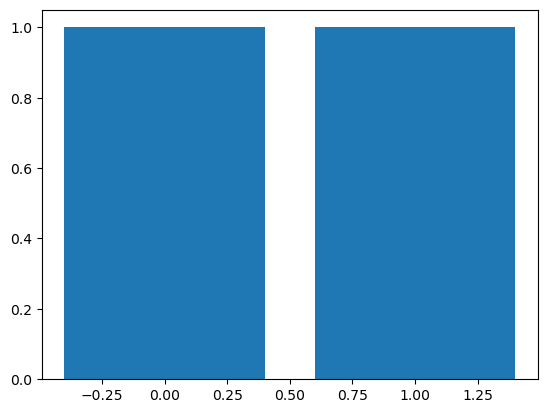

In [545]:
mask = np.array([True, False, True, False, False, True, True])
plt.bar(mask, 1)

In [399]:
np.argwhere(mask).shape

(2, 1)

In [400]:
mask.shape

(4,)

<BarContainer object of 4 artists>

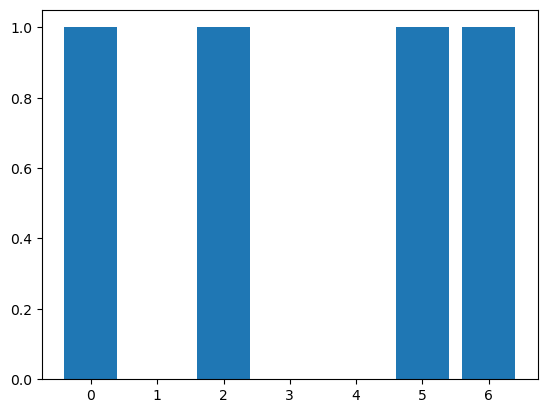

In [403]:
plt.bar(np.argwhere(mask)[:, 0], 1)

best_mae_file

In [388]:
data = pd.read_csv(os.path.join(DIR, best_mae_file))
match_res = format_string.match(best_mae_file) 
ind, alg, n, w = [match_res[i] for i in [1, 2, 3, 4]]
n, w = [int(x) for x in [n, w]]
data = data.to_numpy()

In [348]:
for ind in range(len(files)):
    max_cl = np.argmax(cluster_sizes[ind])
    tmp = (cur_mases[ind][max_cl][cur_mases[ind][max_cl] < np.percentile(cur_mases[ind][max_cl], 95)]).mean()
    if tmp < 10:
        print(files[ind], f"{tmp:.3}")

28_Kmeans_N2_w10.csv 0.899
24_Agglomer_N2_w5.csv 0.824
20_MeanShift_N39_w1.csv 2.89
29_Kmeans_N5_w10.csv 1.23
28_Agglomer_N2_w10.csv 0.749
26_Agglomer_N9_w5.csv 2.59
26_Kmeans_N9_w5.csv 0.88
24_Kmeans_N2_w5.csv 0.83
20_Agglomer_N2_w1.csv 1.05
22_MeanShift_N265_w10.csv 0.935
20_Kmeans_N2_w1.csv 0.928
21_MeanShift_N142_w5.csv 1.04


In [281]:
mase_on_max_cluster[ind_mae]

5137265847021.687

In [190]:
dataset_y = labels[-data.shape[0]:]
dataset_y.shape

(18377,)

In [389]:
predicted_labels = np.zeros(data.shape[0])
misses = [0] * n
threshold = 0.01
TP, FP, TN, FN = 0, 0, 0, 0 #positive - anomaly
for cl in range(n):
    mask = data[:, -2] == cl
    if not mask.any():
        continue
    lab, lab_cnt = np.unique(dataset_y[mask], return_counts=True)
    cnt = np.array([0, 0])
    cnt[lab] = lab_cnt
#     print(f"{cl=}, {cnt=}")
    cluster_label = (1 if cnt[1]/(cnt[0] + cnt[1]) > threshold else 0)
    predicted_labels[mask] = cluster_label
    misses[cl] = cnt[1 - cluster_label]
    print(f"cl={cl:03}, {cnt[1]:4}, {mask.sum():5}, {cnt[1] / mask.sum() * 100:.4}")

#     plt.plot(data[:, 0][dataset_y[mask]], label="a")
#     plt.plot(data[:, 0][mask], label='b')
#     plt.plot(mask, label='mask')
#     plt.plot(dataset_y[mask], label='y')
#     plt.legend()
#     plt.title(str(cnt[1] / mask.sum()))
#     plt.show()

error = sum(misses)
error, error / data.shape[0]


cl=000,    8,  3023, 0.2646
cl=001,   11,  2131, 0.5162
cl=002,    0,   217, 0.0
cl=003,   15,  3159, 0.4748
cl=004,   37,  3550, 1.042
cl=005,    0,   328, 0.0
cl=006,   26,  1162, 2.238
cl=007,   19,  3341, 0.5687
cl=008,    8,  1466, 0.5457


(4710, 0.25629863416226806)

In [130]:
np.unique(predicted_labels, return_counts=True)

(array([0., 1.]), array([13665,  4712]))

In [87]:
np.unique(dataset_y, return_counts=True)

(array([0, 1]), array([18253,   124]))

best_mase_file

In [359]:
#"06_Agglomer_N9_w10.csv"

In [373]:
data = pd.read_csv(os.path.join(DIR, best_mase_file))
data = pd.read_csv(os.path.join(DIR, '24_Kmeans_N2_w5.csv')) #'29_Kmeans_N5_w10.csv'
data = pd.read_csv(os.path.join(DIR, '22_MeanShift_N265_w10.csv'))#'21_MeanShift_N142_w5.csv'))
match_res = format_string.match(best_mase_file) 
ind, alg, n, w = [match_res[i] for i in [1, 2, 3, 4]]
n, w = [int(x) for x in [n, w]]
data = data.to_numpy()

In [374]:
dataset_y = labels[-data.shape[0]:]
dataset_y.shape

(18377,)

In [351]:
import matplotlib as mpl
cmap = mpl.color_sequences['tab10'] 
def visualize_clusters(data, var=0, cluster_num=0, anomalies=None, L=0, R=data.shape[0]):
    conts, indices = get_continuous_parts(data, cluster_num=cluster_num)
    print()
    for cont, ind in zip(conts, indices):
        if ind.max() < L or ind.min() > R:
            continue
        plt.plot(ind, cont[:, var], "-", color=cmap[cluster_num % len(cmap)])
    if anomalies is not None:
        anom_ind = np.array(sorted(list(set(np.where(anomalies)[0]).intersection(set(np.where(data[:, -2] == cluster_num)[0])))))
        ma, mi = max([x[:, var].max() for x in conts if x.any()] + [1]), min([x[:, var].min() for x in conts])
        height = (ma - mi) * 1.3
        bottom = mi - height * 0.1
        plt.bar(np.clip(anom_ind, L, R), height, width=3, bottom=bottom, color="red")
    plt.title(f"VAR {var}, cluster {cluster_num}")
    plt.show()

def get_continuous_parts(data, cluster_num=0):
    mask = data[:, -2] == cluster_num
    cluster_indices = np.arange(data.shape[0])[mask]
    separ = np.where(np.diff(cluster_indices) > 1)[0]
    cont = np.split(data[mask], separ + 1)
    cont_mask = np.split(cluster_indices, separ + 1)
    return cont, cont_mask

In [352]:
a = np.array([
    [0, 0, 0],
    [1, 1, 0],
    [2, 1, 0],
    [3, 0, 0],
    [4, 1, 0],
    [5, 0, 0],
    
])

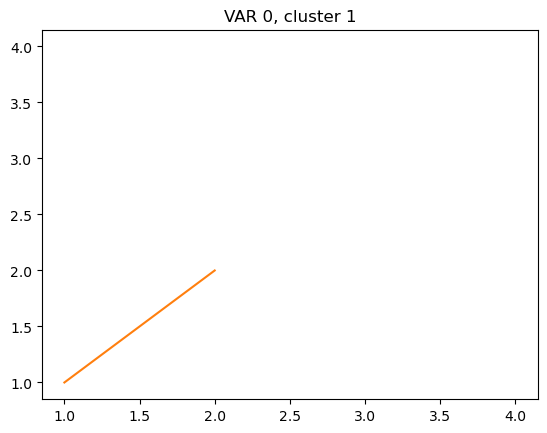

In [353]:
visualize_clusters(a, var=0, cluster_num=1)

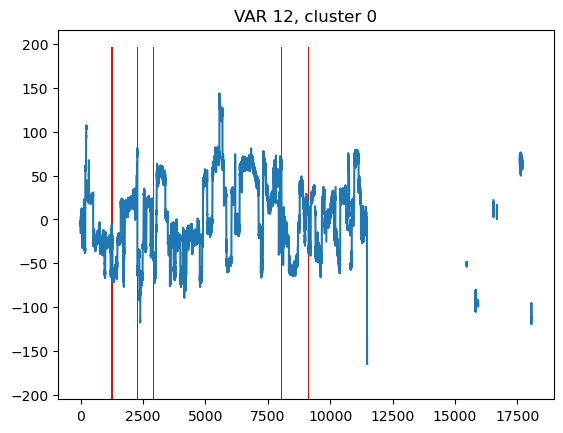

In [354]:
visualize_clusters(data, var=12, cluster_num=0, anomalies=dataset_y) #12, 26

In [355]:
np.where(dataset_y)

(array([  238,   755,   814,  1015,  1242,  1280,  1318,  1323,  1698,
         1729,  2100,  2277,  2282,  2287,  2291,  2296,  2314,  2345,
         2353,  2357,  2386,  2570,  2578,  2624,  2693,  2717,  2805,
         2900,  2924,  2942,  2950,  2978,  3501,  3577,  3579,  3727,
         3997,  4156,  4776,  4912,  5436,  6199,  6802,  7126,  7152,
         7222,  7588,  7822,  7918,  7925,  8001,  8051,  8062,  8109,
         8200,  8215,  8454,  8912,  9080,  9127,  9132,  9175,  9182,
         9391,  9410,  9502,  9821, 10016, 10142, 10220, 10777, 10796,
        10816, 10872, 11131, 11482, 11530, 11553, 11722, 11730, 11771,
        11808, 11846, 12303, 13060, 13593, 14008, 14117, 14139, 14495,
        14893, 15075, 15273, 15392, 15415, 15435, 15462, 15499, 15505,
        15510, 15546, 15569, 15623, 15626, 15642, 15648, 15684, 15688,
        15718, 15749, 15785, 15905, 16238, 16672, 16902, 17012, 17161,
        17184, 17272, 17455, 17584, 17845, 17872, 17988]),)

In [356]:
def check_labels_match(data, labels, thr=15):
    labels = labels[-data.shape[0]:]
    N_clusters = len(np.unique(data[:, -2]))
    anomalies = set(np.where(labels)[0])
    internal_anomalies = set()
    misses_for_clusters = []
    for cl in range(N_clusters):
        border, internal = 0, 0
        conts, cont_inds = get_continuous_parts(data, cluster_num=cl)
        for cont, ind in zip(conts, cont_inds):
            border += len(anomalies.intersection(set(ind[:thr]) | set(ind[-thr:])))
            if len(cont) < thr:
                print("aaa", len(cont))
                continue
            tmp = anomalies.intersection(set(ind[thr:-thr]))
            internal_anomalies |= tmp
            internal += len(tmp)
        misses_for_clusters.append((border, internal))
    return misses_for_clusters, np.array(sorted(list(internal_anomalies)))
        

In [390]:
misses_for_clusters, internal_anomalies = check_labels_match(data, dataset_y)
misses_for_clusters
internal_anomalies_mask = np.zeros(dataset_y.shape[0], dtype=np.bool_)
internal_anomalies_mask[internal_anomalies] = 1
border_anomalies_mask = np.zeros(dataset_y.shape[0], dtype=np.bool_)
border_anomalies_mask[np.array(list(set(np.where(dataset_y)[0]) - set(internal_anomalies)))] = 1
print(misses_for_clusters)
print(internal_anomalies_mask.sum())

aaa 4
aaa 6
aaa 9
aaa 9
aaa 13
aaa 6
aaa 10
aaa 9
aaa 8
[(1, 7), (2, 9), (0, 0), (1, 14), (6, 31), (0, 0), (6, 20), (3, 16), (1, 7)]
104


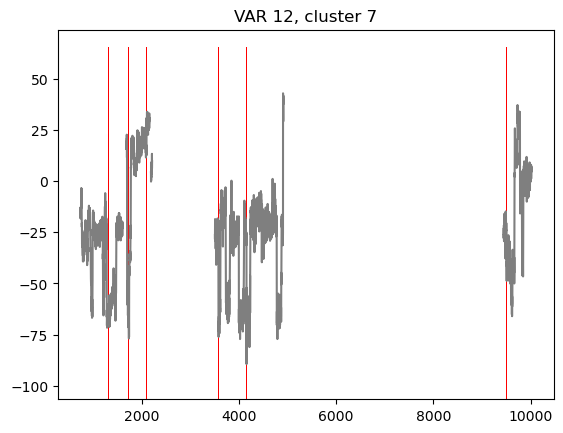

In [399]:
visualize_clusters(data, var=12, cluster_num=7, anomalies=internal_anomalies_mask)#, L=15400, R=16000) #12, 26, 1

In [370]:
n = len(np.unique(data[:, -2]))
predicted_labels = np.zeros(data.shape[0])
misses = [0] * n
threshold = 0.01
TP, FP, TN, FN = 0, 0, 0, 0 #positive - anomaly
for cl in range(n):
    mask = data[:, -2] == cl
    if not mask.any():
        continue
    lab, lab_cnt = np.unique(dataset_y[mask], return_counts=True)
    cnt = np.array([0, 0])
    cnt[lab] = lab_cnt
#     print(f"{cl=}, {cnt=}")
    cluster_label = (1 if cnt[1]/(cnt[0] + cnt[1]) > threshold else 0)
    predicted_labels[mask] = cluster_label
    misses[cl] = cnt[1 - cluster_label]
    print(f"cl={cl:03}, {cnt[1]:4}, {mask.sum():5}, {cnt[1] / mask.sum() * 100:.4}")
#     plt.plot(data[:, 0][dataset_y[mask]], label="a")
#     plt.plot(data[:, 0][mask], label='b')
#     plt.plot(mask, label='mask')
#     plt.plot(dataset_y[mask], label='y')
#     plt.legend()
#     plt.title(str(cnt[1] / mask.sum()))
#     plt.show()

error = sum(misses)
error, error / data.shape[0]

cl=000,  101, 17846, 0.566
cl=001,    0,   116, 0.0
cl=002,    0,    55, 0.0
cl=003,    0,    11, 0.0
cl=004,    0,    11, 0.0
cl=005,    0,    12, 0.0
cl=006,    0,    11, 0.0
cl=007,    0,    10, 0.0
cl=008,    0,     9, 0.0
cl=009,    0,     9, 0.0
cl=010,    0,     7, 0.0
cl=011,    0,     9, 0.0
cl=012,    0,     7, 0.0
cl=013,    0,     7, 0.0
cl=014,    0,     7, 0.0
cl=015,    1,    24, 4.167
cl=016,    0,     7, 0.0
cl=017,    0,     6, 0.0
cl=018,    6,     6, 100.0
cl=019,    0,     7, 0.0
cl=020,    0,     5, 0.0
cl=021,    5,     5, 100.0
cl=022,    0,     5, 0.0
cl=023,    0,     4, 0.0
cl=024,    0,     4, 0.0
cl=025,    0,    12, 0.0
cl=026,    0,     3, 0.0
cl=027,    0,     3, 0.0
cl=028,    0,     3, 0.0
cl=029,    0,     3, 0.0
cl=030,    0,     3, 0.0
cl=031,    0,     3, 0.0
cl=032,    0,     3, 0.0
cl=033,    0,     2, 0.0
cl=034,    0,     2, 0.0
cl=035,    0,     2, 0.0
cl=036,    0,     2, 0.0
cl=037,    0,     3, 0.0
cl=038,    0,     2, 0.0
cl=039,    0,    

(124, 0.006747564890896229)

In [374]:
np.unique(predicted_labels, return_counts=True)

(array([0.]), array([18377]))

In [363]:
np.unique(data[:, -2], return_counts=True)

(array([0., 1.]), array([ 6786, 11591]))

In [331]:
(dataset_y[1:] != dataset_y[:-1]).sum() / dataset_y.shape[0]

/tmp/ipykernel_3152838/936030697.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  (dataset_y[1:] != dataset_y[:-1]).sum() / dataset_y.shape[0]


ValueError: Can only compare identically-labeled Series objects

In [237]:
#без кластеризации
cur_maes, cur_mases, cluster_sizes, files = [], [], [], []
format_string = re.compile("W([0-90]+)_original.*.csv")
for i, file in enumerate(os.listdir("./pulp")):
    print(i, file)
    match_res = format_string.match(file) 
    if match_res is None:
        print("No match")
        continue

    w = int(match_res[1])
    data = pd.read_csv(os.path.join("./pulp", file))
    files.append(file)

    cur_maes.append(calc_mae(data, N_clusters=1, mode=2)) #(cl, Q)
    cur_mases.append(calc_mase(data, N_clusters=1, mode=2))
    

0 W10_group1
No match
1 W30_original_N39_w1.csv


/tmp/ipykernel_2609316/4001881807.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


naive 1.781078270372094
2 W10_original.csv


/tmp/ipykernel_2609316/4001881807.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


naive 1.7801743660095204
3 W20_group1
No match
4 W30_group1
No match
5 W20_group2
No match
6 W20_original.csv


/tmp/ipykernel_2609316/4001881807.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


naive 1.7806839218913981
7 W5_original.csv
naive 1.7799486880442832


/tmp/ipykernel_2609316/4001881807.py:36: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  continuity = np.logical_and((d[1:, -2] == d[:-1, -2]), mask[:-1])


In [238]:
mae_on_max_cluster = np.array([cur_maes[i][0].mean() for i in range(len(cur_maes))]) 
mase_on_max_cluster = np.array([cur_mases[i][0].mean() for i in range(len(cur_maes))]) 

In [239]:
mae_on_max_cluster

array([1.71694237, 1.71278286, 1.7158682 , 1.72114385])

In [240]:
mase_on_max_cluster

array([9.55115607e+08, 2.56937529e+08, 2.28575794e+08, 8.78600461e+07])

In [245]:
cur_mases[0].shape

(1, 60)

In [258]:
for ind in range(len(files)):
    print(files[ind], cur_mases[ind][0][cur_mases[ind][0] < np.percentile(cur_mases[ind][0], 100)].mean())

W30_original_N39_w1.csv 0.9934705634866519
W10_original.csv 0.981339691573659
W20_original.csv 0.9831204710200774
W5_original.csv 0.9833545645303465


In [252]:
cur_mases[0][0] > 1e9

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

(array([59.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([5.36490161e-01, 5.73069364e+09, 1.14613873e+10, 1.71920809e+10,
        2.29227745e+10, 2.86534682e+10, 3.43841618e+10, 4.01148554e+10,
        4.58455491e+10, 5.15762427e+10, 5.73069363e+10]),
 <BarContainer object of 10 artists>)

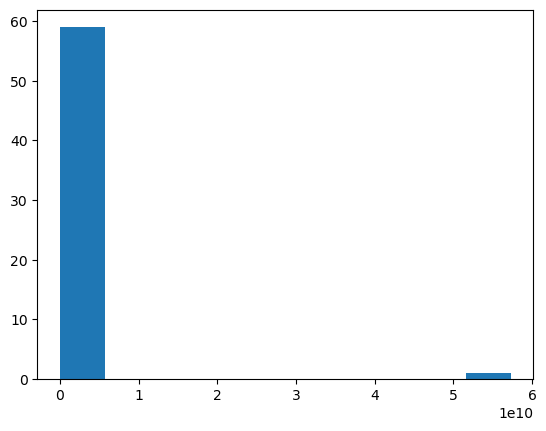

In [246]:
plt.hist(cur_mases[0][0])

In [437]:
data = pd.read_csv('./pulp/W20_group1/29_Agglomer_N5_w10.csv')

In [441]:
n=5

<BarContainer object of 5 artists>

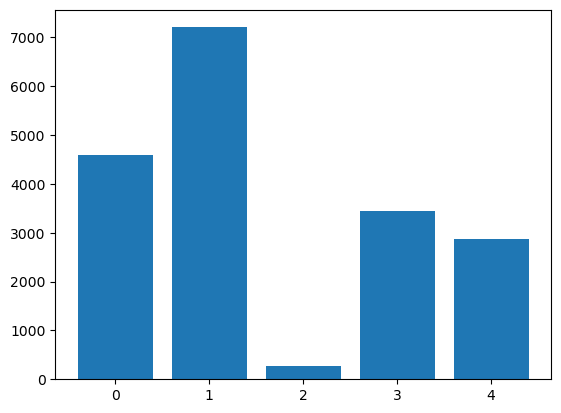

In [438]:
_, cluster_sizes = np.unique(data.to_numpy()[:, -2], return_counts=True)
plt.bar(np.arange(cluster_sizes.shape[0]), cluster_sizes)

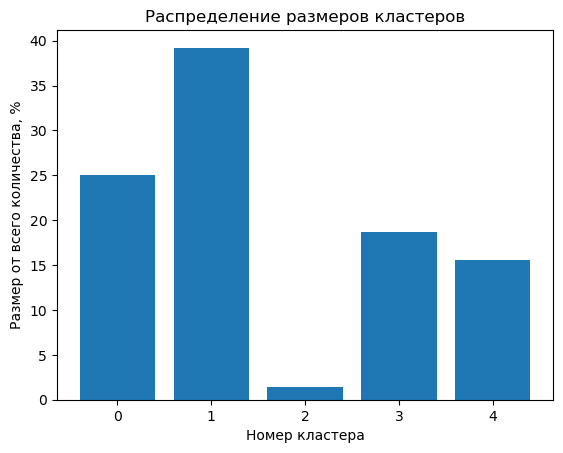

In [439]:
plt.bar(np.arange(cluster_sizes.shape[0]), cluster_sizes / np.sum(cluster_sizes) * 100)
plt.ylabel("Размер от всего количества, %")
plt.xlabel("Номер кластера")
plt.title("Распределение размеров кластеров")
plt.show()

In [455]:
cur_mases[ind].min(), cur_mases[ind].max(), cur_mases[ind].mean()

(0.0, 3.319493706309822, 1.0044152398200423)

In [442]:
cur_maes = calc_mae(data, N_clusters=n)
cur_mases = calc_mase(data, N_clusters=n)

In [464]:
cur_mases[3].mean()

1.1401263357150635

In [ ]:
mean(cur_m)

In [446]:
ind=0

In [451]:
for a in range(len(cur_mases)):
    cur_mases[a][cur_mases[a] > 10] = 0

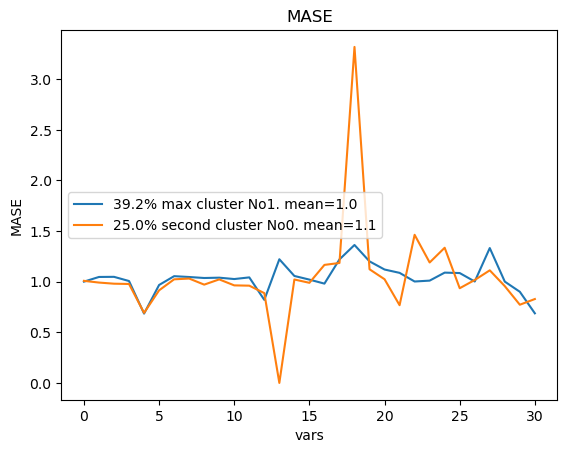

In [454]:
ind1, ind2, ind3, ind4 = 1, 0, 3, 4
# cur_mases_ = cur_mases[cur_mases]
plt.plot(np.arange(cur_mases_[ind1].shape[0]), cur_mases_[ind1], 
         label=f"{cluster_sizes[ind1] / cluster_sizes.sum() * 100:.3}% max cluster No{ind1}. mean={cur_mases_[ind1].mean():.2}")
plt.plot(np.arange(cur_mases_[ind2].shape[0]), cur_mases_[ind2], 
         label=f"{cluster_sizes[ind2] / cluster_sizes.sum() * 100:.3}% second cluster No{ind2}. mean={cur_mases_[ind2].mean():.2}")
# plt.plot(np.arange(cur_mases_[ind3].shape[0]), cur_mases_[ind3], 
#          label=f"{cluster_sizes[ind3] / cluster_sizes.sum() * 100:.3}% third cluster No{ind3}. mean={cur_mases_[ind3].mean():.2}")
# plt.plot(np.arange(cur_mases_[ind4].shape[0]), cur_mases_[ind4], 
#          label=f"{cluster_sizes[ind4] / cluster_sizes.sum() * 100:.3}% third cluster No{ind4}. mean={cur_mases_[ind4].mean():.2}")

plt.title("MASE")
plt.legend()
plt.xlabel('vars')
plt.ylabel("MASE")
plt.show()
# plt.yscale('log')